# Analysis of Global Compact COP reports

For this analysis we download from [here](https://www.unglobalcompact.org/participation/report/cop/create-and-submit/active) all COP reports submitted up to 2018. We only take into account the reports submitted in English.

Please specify below the focus year of this analysis. It will be consider as the end point of historical analyses, as well as the year for annual analyses.

In [1]:
focus_year = "2018"

Please select the focus language using one of the following values:
- en (English, default option)
- de (German)
- es (Spanish)
- fr (French)
- pt (Portuguese)

In [2]:
focus_language = 'en'

In [3]:
language_ref = { 'en' : { 'name' : 'English', 'min_coocurrence' : 10},
                 'de' : { 'name' : 'German', 'min_coocurrence' : 2},
                 'es' : { 'name' : 'Spanish', 'min_coocurrence' : 2},
                 'fr' : { 'name' : 'French', 'min_coocurrence' : 2},
                 'pt' : { 'name' : 'Portuguese', 'min_coocurrence' : 2},
               }

## 1. Gathering information about COP reports available from the UN Global Compact website
The [UN Global Compact website](https://www.unglobalcompact.org/participation/report/cop/create-and-submit/active) contains entries for each COP report, describing the sector of the company submitting the report, country and year, as well as the language in which the repoort was written in and a link to a PDF file with the full report.

**The results in this section give a general view of the available COPs, it's not yet restricted by the focus_year and focus_language.**

In [4]:
import requests
import re
from bs4 import BeautifulSoup

gc_url = "https://www.unglobalcompact.org/participation/report/cop/create-and-submit/active?page=1&per_page=10"
gc_base_url = "https://www.unglobalcompact.org"

gc_home = requests.get(gc_url)

soup = BeautifulSoup(gc_home.content, 'lxml')

header = soup.h2.string

total_num_cops = re.search(r'(?<=: )[0-9]+', header)[0]
print("Total number of COPs available: %s" % total_num_cops)

Total number of COPs available: 38907


---

In [5]:
import pandas as pd

reports_index_csv_filename = "../data/cops/reports_index.csv"

df_pdfs = pd.read_csv(reports_index_csv_filename, sep='\t', encoding='utf-8', index_col=0, dtype={'year': object})
pdfs = df_pdfs.to_dict(orient='index')

## 2. Selecting COP reports that match required criteria (up to focus_year, written in focus_language)

In [6]:
selected_sectors = {}
selected_countries = {}
selected_years = {}
selected_countries_years = {}
selected_sectors_years = {}

selected_pdfs = {}

for pdf in pdfs.keys():
    language = pdfs[pdf]["language"]
    year = pdfs[pdf]["year"]
    country = pdfs[pdf]["country"]
    sector = pdfs[pdf]["sector"]

    if language == language_ref[focus_language]['name'] and int(year) <= int(focus_year):
        selected_pdfs[pdf] = pdfs[pdf]
        
        selected_sectors[sector] = selected_sectors.get(sector,0) + 1
        selected_countries[country] = selected_countries.get(country,0) + 1
        selected_years[year] = selected_years.get(year,0) + 1
        if country in selected_countries_years.keys():
            selected_countries_years[country][year] = selected_countries_years[country].get(year,0) + 1
        else:
            selected_countries_years[country] = {year : 1} 
            
        if sector in selected_sectors_years.keys():
            selected_sectors_years[sector][year] = selected_sectors_years[sector].get(year,0) + 1
        else:
            selected_sectors_years[sector] = {year : 1}

## 4. Extracting text from the PDF file of each report

A folder should be specified as the location where text files will be saved at ('txts_folder' variable below).

This process may fail to extract the text from some PDF files.

If this process has been run before and some text files are already available in the specified folder, they won't be processed again.

In [7]:
filenameregex = re.compile(r'(?<=/)[^$/]+(?=$)')

In [8]:
txts_folder = "../data/cops/txts/"

## 5. Analysing the text of reports: searching for health and climate mentions

### Keywords

In [9]:
import json
import os
import re

keywords_file = os.path.join("..", "keywords", focus_language + ".json")

climate_dict = []
health_dict = []
compound_terms = []

def normalise_keywords(dictionary): #lowercases and handles compounds
    for i in range(0, len(dictionary)):
        keyword = dictionary[i].lower()
        compound = keyword.replace(' ','_')
        if compound != keyword:
            keyword = compound
            words = tuple(compound.split('_'))
            compound_terms.append(words)
        dictionary[i] = keyword
    return dictionary

def generate_hashtags(dictionary):
    hashtags_dict = []
    for keyword in dictionary:
        hashtags_dict.append("#" + keyword.replace('_',''))
    return hashtags_dict

with open(keywords_file) as f:
    data = json.load(f)

climate_dict = normalise_keywords(data['climate'])
health_dict = normalise_keywords(data['health'])

climate_hashtag_dict = generate_hashtags(climate_dict)
health_hashtag_dict = generate_hashtags(health_dict)

In [10]:
health_dict

['malaria',
 'diarrhoea',
 'infection',
 'disease',
 'sars',
 'measles',
 'pneumonia',
 'epidemic',
 'pandemic',
 'public_health',
 'healthcare',
 'epidemiology',
 'health_care',
 'health',
 'mortality',
 'morbidity',
 'nutrition',
 'illness',
 'infectious',
 'ncd',
 'non-communicable_disease',
 'noncommunicable_disease',
 'communicable_disease',
 'air_pollution',
 'nutrition',
 'malnutrition',
 'mental_disorder',
 'stunting']

In [11]:
climate_dict

['climate_change',
 'global_warming',
 'green_house',
 'temperature',
 'extreme_weather',
 'global_environmental_change',
 'climate_variability',
 'greenhouse',
 'low_carbon',
 'ghge',
 'renewable_energy',
 'carbon_emission',
 'co2_emission',
 'climate_pollutant']

In [12]:
who_regions = {}

who_regions["Africa"] = ["Algeria", "Angola", "Benin", "Botswana", "British Indian Ocean Territory", 
                         "Burkina Faso", "Burundi", "Cabo Verde", "Cameroon", "Central African Republic", 
                         "Chad", "Comoros", "Congo, Democratic Republic of the", "Cote d'Ivoire", 
                         "Democratic Republic of the Congo", "Congo, Republic of the", 
                         "Equatorial Guinea", "Eritrea", "Ethiopia", "French Southern Territories", "Gabon", 
                         "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Kenya", "Lesotho", "Liberia", 
                         "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Mayotte", "Mozambique", 
                         "Namibia", "Niger", "Nigeria", "Rwanda", "Réunion", "Saint Helena", 
                         "Sao Tome And Principe", "Senegal", "Seychelles", "Sierra Leone", "South Africa", 
                         "South Sudan", "Swaziland", "Togo", "Uganda", "Tanzania, United Republic of", 
                         "Western Sahara", "Zambia", "Zimbabwe"]

who_regions["Eastern Mediterranean"] = ["Afghanistan", "Bahrain", "Djibouti", "Egypt", 
                                        "Iran, Islamic Republic of", "Iraq", "Jordan", "Kuwait", "Lebanon", 
                                        "Libya", "Morocco", "Oman", "Pakistan", "Qatar", "Saudi Arabia", 
                                        "Somalia", "Palestine, State of", "Sudan", "Syrian Arab Republic", 
                                        "Tunisia", "United Arab Emirates", "Yemen"]

who_regions["Europe"] = ["Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus", "Belgium", 
                         "Bosnia-Herzegovina", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark", 
                         "Estonia", "Faroe Islands", "Finland", "France", "Georgia", "Germany", "Gibraltar", 
                         "Greece", "Guernsey", "Holy See", "Hungary", "Iceland", "Ireland", "Isle of Man", 
                         "Israel", "Italy", "Jersey", "Kazakhstan", "Kyrgyzstan", "Latvia", "Liechtenstein", 
                         "Lithuania", "Luxembourg", "Malta", "Monaco", "Montenegro", "Netherlands", "North Macedonia", "Norway", 
                         "Poland", "Portugal", "Moldova, Republic of", "Romania", "Russian Federation", 
                         "San Marino", "Sark", "Serbia", "Slovakia", "Slovenia", "Spain", 
                         "Svalbard and Jan Mayen Islands", "Sweden", "Switzerland", "Tajikistan", 
                         "Macedonia, The former Yugoslav Republic of", "Turkey", "Turkmenistan", "Ukraine", 
                         "United Kingdom", "Uzbekistan", 
                         "Åland Islands"]

who_regions["Latin America and the Caribbean"] = ["Anguilla", "Antigua and Barbuda", "Argentina", "Aruba", 
                                                  "Bahamas", "Barbados", "Belize", "Bolivia", "Bonaire", 
                                                  "Bouvet Island", "Brazil", "British Virgin Islands", 
                                                  "Cayman Islands", "Chile", "Colombia", "Costa Rica", "Cuba", 
                                                  "Curaçao", "Dominica", "Dominican Republic", "Ecuador", 
                                                  "El Salvador", "Falkland Islands (Malvinas)", "French Guiana", 
                                                  "Grenada", "Guadeloupe", "Guatemala", "Guyana", "Haiti", 
                                                  "Honduras", "Jamaica", "Martinique", "Mexico", "Montserrat", 
                                                  "Nicaragua", "Panama", "Paraguay", "Peru", "Puerto Rico", 
                                                  "Saint Barthթlemy", "Saint Kitts and Nevis", "Saint Lucia", 
                                                  "Saint Martin", "Saint Vincent and the Grenadines", 
                                                  "Sint Maarten", "South Georgia and the South Sandwich Islands", 
                                                  "Suriname", "Trinidad And Tobago", "Turks and Caicos Islands", 
                                                  "Virgin Islands", "Uruguay", "Venezuela"]

who_regions["North America"] = ["Bermuda", "Canada", "Greenland", "Saint Pierre and Miquelon", 
                                "United States of America"]

who_regions["South-East Asia"] = ["Bangladesh", "Bhutan", "Democratic People's Republic of Korea", "India", 
                                  "Indonesia", "Maldives", "Myanmar", "Nepal", "Sri Lanka", "Thailand", 
                                  "Timor-Leste"]

who_regions["Western Pacific"] = ["American Samoa", "Australia", "Brunei", "Cambodia", "China", 
                                  "Hong Kong", "Macao", "Taiwan", "Christmas Island", "Cocos (Keeling) Islands", 
                                  "Cook Islands", "Fiji", "French Polynesia", "Guam", 
                                  "Heard Island and McDonald Islands", "Japan", "Kiribati", 
                                  "Laos", "Malaysia", "Marshall Islands", "Micronesia", "Mongolia", "Nauru", 
                                  "New Caledonia", "New Zealand", "Niue", "Norfolk Island", 
                                  "Northern Mariana Islands", "Palau", "Papua New Guinea", "Philippines", 
                                  "Pitcairn", "Korea, Republic of", "Samoa", "Singapore", "Solomon Islands", 
                                  "Tokelau", "Tonga", "Tuvalu", "Minor Outlying Islands", "Vanuatu", 
                                  "Viet Nam", "Wallis and Futuna Islands"]

In [ ]:
def get_who_region(country):
    for region in who_regions:
        if country in who_regions[region]:
            return region
    if "..." in country:
        abrev_country_name = re.search(r'(?<=^)[^\.]+', country)[0]
        for region in who_regions:
            for c in who_regions[region]:
                if re.match(abrev_country_name, c):
                    return region
    print("Country not found among WHO regions: %s" % country)
    return False

selected_regions_years = {}
for region in who_regions.keys():
    selected_regions_years[region] = {}
for country in selected_countries_years.keys():
    region = get_who_region(country)
    if region:
        for year in selected_countries_years[country].keys():
            selected_regions_years[region][year] = selected_regions_years[region].get(year, 0) + selected_countries_years[country][year]

In [46]:
new_regions = {}
new_regions['sids'] = ["American Samoa", "Anguilla", "Antigua and Barbuda", "Bahamas", "Bahrain", "Barbados", "Belize", "Bermuda", "Cape Verde", "Comoros", "Cook Islands", "Cuba", "Dominica", "Fiji", "Grenada", "Guam", "Guinea-Bissau", "Guyana", "Haiti", "Jamaica", "Kiribati", "Maldives", "Marshall Islands", "Mauritius", "Micronesia", "Montserrat", "Nauru", "New Caledonia", "Niue", "Palau", "Papua New Guinea", "Puerto Rico", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines", "Samoa", "Sao Tome and Principe", "Seychelles", "Singapore", "Solomon Islands", "Suriname", "Timor-Leste", "Tonga", "Trinidad and Tobago", "Tuvalu", "Vanuatu"]
new_regions['tier1'] = ["United States of America", "China"]
new_regions['tier2'] = ["Poland", "Australia", "South Africa", "Brazil", "India", "France", "Germany", "Indonesia", "United Kingdom"]

other = []
def get_new_region(country):
    for region in new_regions:
        if country in new_regions[region]:
            return region
    if "..." in country:
        abrev_country_name = re.search(r'(?<=^)[^\.]+', country)[0]
        for region in new_regions:
            for c in new_regions[region]:
                if re.match(abrev_country_name, c):
                    return region
    print("Country not found among new regions: %s" % country)
    other.append(country)
    return False
new_regions['other'] = other

selected_regions_years = {}
for region in new_regions.keys():
    selected_regions_years[region] = {}
    
for country in selected_countries_years.keys():
    region = get_new_region(country)
    if region:
        for year in selected_countries_years[country].keys():
            selected_regions_years[region][year] = selected_regions_years[region].get(year, 0) + selected_countries_years[country][year]

Country not found among new regions: Turkey
Country not found among new regions: Pakistan
Country not found among new regions: Belgium
Country not found among new regions: Israel
Country not found among new regions: Kuwait
Country not found among new regions: Luxembourg
Country not found among new regions: Spain
Country not found among new regions: Switzerland
Country not found among new regions: Thailand
Country not found among new regions: Denmark
Country not found among new regions: Mexico
Country not found among new regions: Netherlands
Country not found among new regions: Sweden
Country not found among new regions: Finland
Country not found among new regions: Philippines
Country not found among new regions: Norway
Country not found among new regions: Italy
Country not found among new regions: Lithuania
Country not found among new regions: Hungary
Country not found among new regions: Nigeria
Country not found among new regions: Korea, Repub...
Country not found among new regions: U

In [22]:
from nltk.tokenize import MWETokenizer

def get_context(index, wordlist):
    lowest_index = max(0, index-25)
    highest_index = min(index+1+25, len(wordlist))
    return wordlist[lowest_index:index] + wordlist[index+1:highest_index]

tokenizer = MWETokenizer(compound_terms)
regex = re.compile(r'^.{1,3}$') # words with 3 or less chars

types_count = {}
tokens_count = 0

per_sector = {}
average_per_sector = {}
proportion_per_sector = {}
###
per_sector_year_health = {}
average_per_sector_year_health = {}
proportion_per_sector_year_health = {}
per_sector_year_climate = {}
average_per_sector_year_climate = {}
proportion_per_sector_year_climate = {}
per_sector_year_intersection = {}
average_per_sector_year_intersection = {}
proportion_per_sector_year_intersection = {}
###
per_country = {}
per_country_focusyear = {}
average_per_country_focusyear = {}
proportion_per_country_focusyear = {}
per_year = {}
average_per_year = {}
proportion_per_year = {}
per_region = {}
per_region_year_intersection = {}
average_per_region_year_intersection = {}
proportion_per_region_year_intersection = {}
histogram_number_of_mentions = {}
histogram_tokens_count = []

global_count_health_keywords = {}
global_health_contexts = []
global_count_climate_keywords = {}
global_climate_contexts = []
global_intersection_contexts = []

cooccurrence_matrix = {}

for termset in ["health", "climate", "intersection"]:
    per_sector[termset] = {}
    average_per_sector[termset] = {}
    proportion_per_sector[termset] = {}
    per_country[termset] = {}
    per_country_focusyear[termset] = {}
    average_per_country_focusyear[termset] = {}
    proportion_per_country_focusyear[termset] = {}
    per_year[termset] = {}
    average_per_year[termset] = {}
    proportion_per_year[termset] = {}
    per_region[termset] = {}
    histogram_number_of_mentions[termset] = {}
    
for region in new_regions.keys():
    per_region_year_intersection[region] = {}
    average_per_region_year_intersection[region] = {}
    proportion_per_region_year_intersection[region] = {}
###
for sector in selected_sectors.keys():
    per_sector_year_health[sector] = {}
    average_per_sector_year_health[sector] = {}
    proportion_per_sector_year_health[sector] = {}
    per_sector_year_climate[sector] = {}
    average_per_sector_year_climate[sector] = {}
    proportion_per_sector_year_climate[sector] = {}
    per_sector_year_intersection[sector] = {}
    average_per_sector_year_intersection[sector] = {}
    proportion_per_sector_year_intersection[sector] = {}
###
for pdf in selected_pdfs.keys():
    filenametxt = txts_folder + filenameregex.search(pdf)[0] + ".txt"
    print("Loading %s" % (filenametxt))

    try:
        txtFileObj = open(filenametxt, 'r')
    except:
        print("Could not open {}".format(filenametxt))
        continue

    wordlist = re.split(r'[\W0-9]+', txtFileObj.read().lower())
    tokens_count += len(wordlist)
    histogram_tokens_count.append(len(wordlist))
    
    for word in wordlist:
        types_count[word] = types_count.get(word, 0) + 1
    
    compounds_wordlist = tokenizer.tokenize(wordlist)
    filtered_compounds_wordlist = [w for w in compounds_wordlist if (len(w) > 3)]

    health_contexts = []
    climate_contexts = []
    health_words = []
    
    for i in range(0,len(filtered_compounds_wordlist)):
        word = filtered_compounds_wordlist[i]
        if word in health_dict:
            context = get_context(i, filtered_compounds_wordlist)
            health_contexts.append(context)
            health_words.append(word)            
            global_count_health_keywords[word] = global_count_health_keywords.get(word, 0) + 1
            global_health_contexts.extend(context)
            
        if word in climate_dict:
            context = get_context(i, filtered_compounds_wordlist)
            climate_contexts.append(context)
            global_count_climate_keywords[word] = global_count_climate_keywords.get(word, 0) + 1
            global_climate_contexts.extend(context)

    total_health_mentions = len(health_contexts)
    
    total_climate_mentions = len(climate_contexts)
        
    total_intersection_mentions = 0
    for i in range(0, len(health_contexts)):
        mention = health_contexts[i]
        hword = health_words[i]
        if hword not in cooccurrence_matrix.keys():
            cooccurrence_matrix[hword] = {}        
        for cword in climate_dict:
            if cword in mention:
                total_intersection_mentions += 1
                global_intersection_contexts.extend(mention)
                cooccurrence_matrix[hword][cword] = cooccurrence_matrix[hword].get(cword, 0) + 1                
        
    language = selected_pdfs[pdf]["language"]
    year = selected_pdfs[pdf]["year"]
    country = selected_pdfs[pdf]["country"]
    sector = selected_pdfs[pdf]["sector"]
    region = get_new_region(country)
    
    histogram_number_of_mentions["health"][total_health_mentions] = histogram_number_of_mentions["health"].get(total_health_mentions, 0) + 1
    histogram_number_of_mentions["climate"][total_climate_mentions] = histogram_number_of_mentions["climate"].get(total_climate_mentions, 0) + 1
    histogram_number_of_mentions["intersection"][total_intersection_mentions] = histogram_number_of_mentions["intersection"].get(total_intersection_mentions, 0) + 1
    
    per_sector["health"][sector] = per_sector["health"].get(sector,0) + total_health_mentions
    per_sector["climate"][sector] = per_sector["climate"].get(sector,0) + total_climate_mentions
    per_sector["intersection"][sector] = per_sector["intersection"].get(sector,0) + total_intersection_mentions  
    
    per_sector_year_health[sector][year] = per_sector_year_health[sector].get(year,0) + total_health_mentions    
    per_sector_year_climate[sector][year] = per_sector_year_climate[sector].get(year,0) + total_climate_mentions
    per_sector_year_intersection[sector][year] = per_sector_year_intersection[sector].get(year,0) + total_intersection_mentions
   
    per_country["health"][country] = per_country["health"].get(country,0) + total_health_mentions
    per_country["climate"][country] = per_country["climate"].get(country,0) + total_climate_mentions
    per_country["intersection"][country] = per_country["intersection"].get(country,0) + total_intersection_mentions

    if year == focus_year:
        per_country_focusyear["health"][country] = per_country_focusyear["health"].get(country,0) + total_health_mentions
        per_country_focusyear["climate"][country] = per_country_focusyear["climate"].get(country,0) + total_climate_mentions
        per_country_focusyear["intersection"][country] = per_country_focusyear["intersection"].get(country,0) + total_intersection_mentions

    if region != False:
        per_region["health"][region] = per_region["health"].get(region,0) + total_health_mentions
        per_region["climate"][region] = per_region["climate"].get(region,0) + total_climate_mentions
        per_region["intersection"][region] = per_region["intersection"].get(region,0) + total_intersection_mentions
        per_region_year_intersection[region][year] = per_region_year_intersection[region].get(year,0) + total_intersection_mentions

    per_year["health"][year] = per_year["health"].get(year,0) + total_health_mentions
    per_year["climate"][year] = per_year["climate"].get(year,0) + total_climate_mentions
    per_year["intersection"][year] = per_year["intersection"].get(year,0) + total_intersection_mentions

    if total_health_mentions > 0:
        proportion_per_year["health"][year] = proportion_per_year["health"].get(year,0) + 1
        proportion_per_sector["health"][sector] = proportion_per_sector["health"].get(sector,0) + 1
        if year == focus_year:
            proportion_per_country_focusyear["health"][country] = proportion_per_country_focusyear["health"].get(country,0) + 1
        proportion_per_sector_year_health[sector][year] = proportion_per_sector_year_health[sector].get(year,0) + 1

    if total_climate_mentions > 0:
        proportion_per_year["climate"][year] = proportion_per_year["climate"].get(year,0) + 1
        proportion_per_sector["climate"][sector] = proportion_per_sector["climate"].get(sector,0) + 1
        if year == focus_year:
            proportion_per_country_focusyear["climate"][country] = proportion_per_country_focusyear["climate"].get(country,0) + 1
        proportion_per_sector_year_climate[sector][year] = proportion_per_sector_year_climate[sector].get(year,0) + 1

    if total_intersection_mentions > 0:
        proportion_per_year["intersection"][year] = proportion_per_year["intersection"].get(year,0) + 1        
        proportion_per_sector["intersection"][sector] = proportion_per_sector["intersection"].get(sector,0) + 1        
        if year == focus_year:
            proportion_per_country_focusyear["intersection"][country] = proportion_per_country_focusyear["intersection"].get(country,0) + 1
        proportion_per_region_year_intersection[region][year] = proportion_per_region_year_intersection[region].get(year,0) + 1
        proportion_per_sector_year_intersection[sector][year] = proportion_per_sector_year_intersection[sector].get(year,0) + 1

for year in selected_years.keys():
    average_per_year["health"][year] = per_year["health"][year]/selected_years[year]
    average_per_year["climate"][year] = per_year["climate"][year]/selected_years[year]
    average_per_year["intersection"][year] = per_year["intersection"][year]/selected_years[year]

    proportion_per_year["health"][year] = proportion_per_year["health"].get(year,0)/selected_years[year] * 100
    proportion_per_year["climate"][year] = proportion_per_year["climate"].get(year,0)/selected_years[year] * 100
    proportion_per_year["intersection"][year] = proportion_per_year["intersection"].get(year,0)/selected_years[year] * 100
    
for country in selected_countries_years.keys():
    if focus_year in selected_countries_years[country].keys():
        average_per_country_focusyear["health"][country] = per_country_focusyear["health"].get(country, 0)/selected_countries_years[country][focus_year]
        average_per_country_focusyear["climate"][country] = per_country_focusyear["climate"].get(country, 0)/selected_countries_years[country][focus_year]
        average_per_country_focusyear["intersection"][country] = per_country_focusyear["intersection"].get(country, 0)/selected_countries_years[country][focus_year]

        proportion_per_country_focusyear["health"][country] = proportion_per_country_focusyear["health"].get(country,0)/selected_countries_years[country][focus_year] * 100
        proportion_per_country_focusyear["climate"][country] = proportion_per_country_focusyear["climate"].get(country,0)/selected_countries_years[country][focus_year] * 100
        proportion_per_country_focusyear["intersection"][country] = proportion_per_country_focusyear["intersection"].get(country,0)/selected_countries_years[country][focus_year] * 100

for region in selected_regions_years.keys():
    for year in selected_regions_years[region].keys():
        average_per_region_year_intersection[region][year] = per_region_year_intersection[region].get(year,0)/selected_regions_years[region][year]
        proportion_per_region_year_intersection[region][year] = proportion_per_region_year_intersection[region].get(year,0)/selected_regions_years[region][year] * 100        
      
for sector in selected_sectors.keys():
    average_per_sector["health"][sector] = per_sector["health"][sector]/selected_sectors[sector]
    average_per_sector["climate"][sector] = per_sector["climate"][sector]/selected_sectors[sector]
    average_per_sector["intersection"][sector] = per_sector["intersection"][sector]/selected_sectors[sector]

    proportion_per_sector["health"][sector] = proportion_per_sector["health"].get(sector,0)/selected_sectors[sector] * 100
    proportion_per_sector["climate"][sector] = proportion_per_sector["climate"].get(sector,0)/selected_sectors[sector] * 100
    proportion_per_sector["intersection"][sector] = proportion_per_sector["intersection"].get(sector,0)/selected_sectors[sector] * 100

for sector in selected_sectors_years.keys():
    for year in selected_sectors_years[sector].keys():
        average_per_sector_year_health[sector][year] = per_sector_year_health[sector].get(year,0)/selected_sectors_years[sector][year]
        average_per_sector_year_climate[sector][year] = per_sector_year_climate[sector].get(year,0)/selected_sectors_years[sector][year]
        average_per_sector_year_intersection[sector][year] = per_sector_year_intersection[sector].get(year,0)/selected_sectors_years[sector][year]
        
        proportion_per_sector_year_health[sector][year] = proportion_per_sector_year_health[sector].get(year,0)/selected_sectors_years[sector][year] * 100        
        proportion_per_sector_year_climate[sector][year] = proportion_per_sector_year_climate[sector].get(year,0)/selected_sectors_years[sector][year] * 100        
        proportion_per_sector_year_intersection[sector][year] = proportion_per_sector_year_intersection[sector].get(year,0)/selected_sectors_years[sector][year] * 100          

Loading ../data/cops/txts/BUTECH-_COMMUNICATION_ON_PROGRESS-2011.pdf?1303481463.txt
Loading ../data/cops/txts/UNGC_COP_2011.pdf?1303705875.txt
Loading ../data/cops/txts/ubeon_-_GLOBAL_COMPACT_COP_2011.pdf?1303799951.txt
Loading ../data/cops/txts/TEVA_UNGC_Second_CommunicationonProgress_April201__final.pdf?1303803422.txt
Loading ../data/cops/txts/CEO_s_Letter_to_UNGC.pdf?1303804488.txt
Loading ../data/cops/txts/UN_Global_Compact_-_Anti-Corruption.pdf?1303804488.txt
Loading ../data/cops/txts/UN_Global_Compact_-_Environment.pdf?1303804488.txt
Loading ../data/cops/txts/UN_Global_Compact_-_Human_Rights.pdf?1303804488.txt
Loading ../data/cops/txts/UN_Global_Compact_-_Labour.pdf?1303804488.txt
Loading ../data/cops/txts/Agility_Code_of_Ethics.pdf?1303804488.txt
Loading ../data/cops/txts/Agility_Competition_Compliance_Policy.pdf?1303804488.txt
Loading ../data/cops/txts/Ness_Techologies_UNGC_COP_2011_final.pdf?1303806381.txt
Loading ../data/cops/txts/AR_2010CARGOLUX.pdf?1303808746.txt
Loading ..

Loading ../data/cops/txts/UN_Global_Compact_COP_2011.pdf?1305772581.txt
Loading ../data/cops/txts/MN_MARCH_2011_EPS_M10_Hovercraft_Layouts-1.pdf?1305772581.txt
Loading ../data/cops/txts/CSR.Engelsk_udgave.UK.pdf?1305790306.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT_COP_2010_completed_on_09_May_2011.pdf?1305797302.txt
Loading ../data/cops/txts/UNGC0910w.pdf?1305802408.txt
Loading ../data/cops/txts/Communication_of_Progress_2011.pdf?1305806103.txt
Loading ../data/cops/txts/Wienerberger_NB2010_englisch_gesamt.pdf?1305806103.txt
Loading ../data/cops/txts/KPN_CSRreport_ENG_2010.pdf?1305807005.txt
Loading ../data/cops/txts/KPN_CSR_GRI_ENG_2010.pdf?1305807005.txt
Loading ../data/cops/txts/Ernst_and_Young_Ukraine_Corporate_Responsibility_Report_2010_ENG.pdf?1305814265.txt
Loading ../data/cops/txts/Piraeus_Bank_Corporate_Responsibility_Report_2010.pdf?1305815776.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT.pdf?1305878889.txt
Loading ../data/cops/txts/Deutsche_Post_DHL___UNGC_COP_CR_Repo

Loading ../data/cops/txts/BACKUS_RDS2009.pdf?1308091458.txt
Loading ../data/cops/txts/TARKETT_global_compact_final_2010.pdf?1308131298.txt
Loading ../data/cops/txts/Volvo_Corporate_report_ENG_2010_locked.pdf?1308140751.txt
Loading ../data/cops/txts/Volvo_Cars_2010_GRI_report_LOCKED.pdf?1308140751.txt
Loading ../data/cops/txts/lafarge_sustainability_report_2010.pdf?1308149826.txt
Loading ../data/cops/txts/CoP_2010-11_R_my_Cointreau.pdf?1308151565.txt
Loading ../data/cops/txts/SR2010_Eng.pdf?1308172090.txt
Loading ../data/cops/txts/Global_Compact_COP2011_English_.pdf?1308193721.txt
Loading ../data/cops/txts/ELARD_COP-10_principles_June_2011.pdf?1308225730.txt
Loading ../data/cops/txts/LGE_2010SR_english.pdf?1308273473.txt
Loading ../data/cops/txts/Bene_Nachhaltigkeitsbericht_EN.pdf?1308290340.txt
Loading ../data/cops/txts/KORAIL_COP.pdf?1308296693.txt
Loading ../data/cops/txts/BDO_s_Report_on_Corporate_Social_Responsibility_2011.pdf?1308311879.txt
Loading ../data/cops/txts/Reed_Elsevier_

Loading ../data/cops/txts/SD_REPORT_2010_-_Final.pdf?1310138141.txt
Loading ../data/cops/txts/rdd_uk2010.pdf?1310142366.txt
Loading ../data/cops/txts/Technicolor_UNGC_2010_COP.pdf?1310232388.txt
Loading ../data/cops/txts/COP-2011.pdf?1310363833.txt
Loading ../data/cops/txts/UNGC_BT_COP_2011.pdf?1310374331.txt
Loading ../data/cops/txts/LH-sustainability-report-2011.pdf?1310382166.txt
Loading ../data/cops/txts/2010_Promega_CR_Report.pdf?1310407749.txt
Loading ../data/cops/txts/2010_KEPCO_E_C_Sustainability_Report.pdf?1310452003.txt
Loading ../data/cops/txts/CSR-2010-EN.pdf?1310474031.txt
Loading ../data/cops/txts/Report_Sustainability_Sabesp_2010.pdf?1310476064.txt
Loading ../data/cops/txts/COP_2011-MJL_Co.pdf?1310503045.txt
Loading ../data/cops/txts/COP_2011-MJLIM.pdf?1310503173.txt
Loading ../data/cops/txts/ASBCT_annualreport09forweb.pdf?1310529804.txt
Loading ../data/cops/txts/www.nokia.com-corporate-responsibility-reporting-united-nations-global-compact.pdf?1310540647.txt
Loading ../

Loading ../data/cops/txts/2010_CSR_B-373.pdf?1312819126.txt
Loading ../data/cops/txts/COP_2010-11_letter0001.pdf?1312850979.txt
Loading ../data/cops/txts/cop-2.pdf?1312863222.txt
Loading ../data/cops/txts/UNGC_COP_2011_09.08.11.pdf?1312897483.txt
Loading ../data/cops/txts/vkg_SAA2010_eng_v2.pdf?1312952405.txt
Loading ../data/cops/txts/Communication_on_Progress_-_WaterHealth_India_-_2011_Version_2_.pdf?1312956935.txt
Loading ../data/cops/txts/Outotec_Sustainability_Report_2010.pdf?1312976167.txt
Loading ../data/cops/txts/Ryerson_s_Global_Compact_COP_-_11-17-09.pdf?1312985621.txt
Loading ../data/cops/txts/Rodovalho_Advogados_Comunication_on_Progress_on_Global_Compact_2010-2011.pdf?1313011964.txt
Loading ../data/cops/txts/2010_CSR_FOURLIS_Group_Report.pdf?1313047341.txt
Loading ../data/cops/txts/COP_2011_Fiducial_Office_Solutions.pdf?1313081947.txt
Loading ../data/cops/txts/Comunicaci_n_de_Progreso_Grupo_SID_2011.pdf?1313091085.txt
Loading ../data/cops/txts/ITT_Water_and_Wastewater_UNGC_S

Loading ../data/cops/txts/Communication_in_Progress_Global_Compact_2011.pdf?1315311634.txt
Loading ../data/cops/txts/2010_Sustainability_Report.pdf?1315324698.txt
Loading ../data/cops/txts/CSR_Grindeks_2010.pdf?1315371927.txt
Loading ../data/cops/txts/2010-social-entrepreneurship-report-vestergaard-frandsen.pdf?1315373291.txt
Loading ../data/cops/txts/2010_.pdf?1315383251.txt
Loading ../data/cops/txts/Statutory_report_on_CSR.pdf?1315403829.txt
Loading ../data/cops/txts/Stakeholder_magazine_2010.pdf?1315403830.txt
Loading ../data/cops/txts/Final_Communication_on_progress_E_low_res.pdf?1315471047.txt
Loading ../data/cops/txts/Nefab_COP_110908.pdf?1315480131.txt
Loading ../data/cops/txts/Global_Compact_CoP_2011-09-08.pdf?1315490019.txt
Loading ../data/cops/txts/cop2011.pdf?1315494319.txt
Loading ../data/cops/txts/2011_08_Groupe_Grimaud_commitment_to_the_United_Nation_Global_Compact_-_versionWeb_-_Anglais.pdf?1315494446.txt
Loading ../data/cops/txts/GLOBAL_COMPACT_sept2011.pdf?1315495643.t

Loading ../data/cops/txts/Livret_pacte_mondial-Version_anglaise-BD.pdf?1317903438.txt
Loading ../data/cops/txts/GRI_table_of_identification_GC_principles_2010.pdf?1317910685.txt
Loading ../data/cops/txts/Sustainability_report_2010.pdf?1317910685.txt
Loading ../data/cops/txts/Banca_Intesa_Beograd_-_COP_2010.pdf?1317912819.txt
Loading ../data/cops/txts/Banca_Intesa_Beograd_-_COP_2010.pdf?1317912843.txt
Loading ../data/cops/txts/Maplecroft_UNGC_CoP_Oct_2011_FINAL.pdf?1317921757.txt
Loading ../data/cops/txts/2011_The_Korea_Teachers_Pension_Sustainability_Report_Eng_.pdf?1317946913.txt
Loading ../data/cops/txts/UDC_COP_2010-2011.pdf?1317978631.txt
Loading ../data/cops/txts/2011_COP_UN_Global_Compact_Maxibit.pdf?1317995236.txt
Loading ../data/cops/txts/2010_.pdf?1318036813.txt
Loading ../data/cops/txts/CIMBRIA_EAST_AFRICA_Ltd._2011_COP.pdf?1318079493.txt
Loading ../data/cops/txts/RRKL_COP_2011.pdf?1318229365.txt
Loading ../data/cops/txts/Ahold_CR2010.pdf?1318232543.txt
Loading ../data/cops/t

Loading ../data/cops/txts/11fulle-all.pdf?1320834980.txt
Loading ../data/cops/txts/COP_2011_KEDRION_SpA__Vers.English_.pdf?1320836379.txt
Loading ../data/cops/txts/UNGC_COP_7_November_2011.pdf?1320852786.txt
Loading ../data/cops/txts/Communication_on_Progress_November_2011.pdf?1320856143.txt
Loading ../data/cops/txts/COP_-_TICO_Digital_Grouop.pdf?1320912980.txt
Loading ../data/cops/txts/SanLucar_CorporateResponsibilityReport.pdf?1320918472.txt
Loading ../data/cops/txts/informe_Prointec_SA.pdf?1320919190.txt
Loading ../data/cops/txts/Salini_SR_2010.pdf?1320925863.txt
Loading ../data/cops/txts/Salini_group_SR_2010.pdf?1320926854.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT_PROGRESS_REPORT.pdf?1320936238.txt
Loading ../data/cops/txts/ALI_UN-COP.pdf?1320965152.txt
Loading ../data/cops/txts/A_Green_Agenda_COP_2011.pdf?1321008622.txt
Loading ../data/cops/txts/An-El_Communication_on_Progress_2011.pdf?1321011302.txt
Loading ../data/cops/txts/COP_Tchibo_2010_EN.pdf?1321013260.txt
Loading ../

Loading ../data/cops/txts/COP_2011.pdf?1323686772.txt
Loading ../data/cops/txts/BAW_UNGC_COP_GRI_aligned._12_December_2011.pdf?1323704317.txt
Loading ../data/cops/txts/carta_apoyo_continuo_Toks_Pacto_Mundial_2011.pdf?1323714675.txt
Loading ../data/cops/txts/VIP_Packaging_UNGC_COP_2011_FINAL.pdf?1323753554.txt
Loading ../data/cops/txts/csr_report2011_default.pdf?1323769319.txt
Loading ../data/cops/txts/Global_Compact_3.pdf?1323776427.txt
Loading ../data/cops/txts/COP.pdf?1323784985.txt
Loading ../data/cops/txts/Whirlpool_Latin_America_Sustainability_Report_english.pdf?1323801014.txt
Loading ../data/cops/txts/En_Masse_UNGC_COP_17_Dec_2011.pdf?1323812976.txt
Loading ../data/cops/txts/Hikma_COP_2010.pdf?1323849710.txt
Loading ../data/cops/txts/Sustainability_Report_2010_published.pdf?1323852909.txt
Loading ../data/cops/txts/Freshfields_2011_CR_report.pdf?1323867051.txt
Loading ../data/cops/txts/COP_report_2010-2011.pdf?1323875358.txt
Loading ../data/cops/txts/COP_onlinegestellt.pdf?1323885

Loading ../data/cops/txts/QAFCO_SUSTAINABILITY_REPORT_2010.pdf?1327225232.txt
Loading ../data/cops/txts/full_edition.pdf?1327288992.txt
Loading ../data/cops/txts/Edita_Vastra_Aros_COP_2011_UN_Global_Compact.pdf?1327335966.txt
Loading ../data/cops/txts/EPOS_UNGC_CoP_2011.pdf?1327373352.txt
Loading ../data/cops/txts/CSR_Report2011_en.pdf?1327383200.txt
Loading ../data/cops/txts/Minebea_Group_Code_of_Conduct.pdf?1327383200.txt
Loading ../data/cops/txts/UNGC_COP_2011.pdf?1327390440.txt
Loading ../data/cops/txts/HL_Display_Corporate_report_10.pdf?1327418167.txt
Loading ../data/cops/txts/Communication_on_Progress-_SQ_Celsius_Limited.pdf?1327563648.txt
Loading ../data/cops/txts/Statement.pdf?1327563648.txt
Loading ../data/cops/txts/110224_MaerskLine_Sustainability_Progress_Report_2010.pdf?1327617496.txt
Loading ../data/cops/txts/ebara_csr_e11-00.pdf?1327621027.txt
Loading ../data/cops/txts/GC_Rieber_CSR_report_2011.pdf?1327666061.txt
Loading ../data/cops/txts/COP_for_2011_English.pdf?13276670

Loading ../data/cops/txts/NB_KSS_2009_eng.pdf?1330352600.txt
Loading ../data/cops/txts/PACTO_GLOBAL.pdf?1330356288.txt
Loading ../data/cops/txts/110224_MaerskLine_Sustainability_Progress_Report_2010.pdf?1330362039.txt
Loading ../data/cops/txts/FY2011_Lenovo_Sustainability_Report.pdf?1330362147.txt
Loading ../data/cops/txts/Edelman_COP_2012.pdf?1330364592.txt
Loading ../data/cops/txts/anua_report_by_AFCOPB_Director.pdf?1330376088.txt
Loading ../data/cops/txts/Sustainability_CSR_Report_Dentsu_2011_en_.pdf?1330391829.txt
Loading ../data/cops/txts/MRCB_CSR_3105.pdf?1330394589.txt
Loading ../data/cops/txts/UN_GLOBALCOMPACT_2012.pdf?1330418658.txt
Loading ../data/cops/txts/Communication_on_Progress_2011_NIRAS.pdf?1330430784.txt
Loading ../data/cops/txts/Novartis_Argentina_-_Communication_on_progress_-_2011_final.pdf?1330440862.txt
Loading ../data/cops/txts/FirmenichSustainabilityReport2011.pdf?1330446641.txt
Loading ../data/cops/txts/Reaffirmation_of_FPPS.pdf?1330486473.txt
Loading ../data/c

Loading ../data/cops/txts/110111_Arla2010_CoC_ENG_web_NEW_OK.pdf?1332241300.txt
Loading ../data/cops/txts/Arla_Annual_Report_2011_EN.pdf?1332241300.txt
Loading ../data/cops/txts/COP_Hartmann_2011.pdf?1332255419.txt
Loading ../data/cops/txts/PKF_KENYA__UNGC_COMMUNICATION_ON_PROGRESS_FEBRUARY_2011-FEBRUARY_2012.pdf?1332304651.txt
Loading ../data/cops/txts/AkzoNobel_Report_2011.pdf?1332321075.txt
Loading ../data/cops/txts/Annual-report-2011_SustainDev.pdf?1332348473.txt
Loading ../data/cops/txts/Annual-report-2011_Community.pdf?1332348473.txt
Loading ../data/cops/txts/Annual-report-2011.pdf?1332348474.txt
Loading ../data/cops/txts/Maersk_Line_Sustainability_Progress_report_2011.pdf?1332365900.txt
Loading ../data/cops/txts/Maersk_Line_Sustainability_Progress_report_2011.pdf?1332366679.txt
Loading ../data/cops/txts/Maersk_Line_Sustainability_Progress_report_2011.pdf?1332367539.txt
Loading ../data/cops/txts/Maersk_Line_Sustainability_Progress_report_2011.pdf?1332368051.txt
Loading ../data/co

Loading ../data/cops/txts/UNGC_Report_2011_REP.indd.pdf_12....pdf?1334240548.txt
Loading ../data/cops/txts/tera-report-march-2011-final.pdf?1334252171.txt
Loading ../data/cops/txts/entire_shell_sr11.pdf?1334287373.txt
Loading ../data/cops/txts/COP_Report_SMART_-_Apr_2012_final.pdf?1334288937.txt
Loading ../data/cops/txts/SMEC_Holdings_Ltd_Sustainability_Report_2011-2012.pdf?1334291793.txt
Loading ../data/cops/txts/UN_Global_Compact_Communication_on_Progress_2012.pdf?1334300002.txt
Loading ../data/cops/txts/2011_Corporate_Citizenship_EN.pdf?1334305891.txt
Loading ../data/cops/txts/Edinburgh_International_UNGC_COP_April_2012.pdf?1334335128.txt
Loading ../data/cops/txts/CoP_to_Global_Compact.pdf?1334335692.txt
Loading ../data/cops/txts/Annual_Report_2011.pdf?1334344499.txt
Loading ../data/cops/txts/UN_Global_Compact_Lantm_nnen_CoP.pdf?1334344499.txt
Loading ../data/cops/txts/Global_Compact_Index_2011_Lantm_nnen.pdf?1334344499.txt
Loading ../data/cops/txts/BDP_International_Inc_Communicati

Loading ../data/cops/txts/UN_GLOBAL_COMPACT_COP_May_2012.pdf?1336292866.txt
Loading ../data/cops/txts/HENT_COP_2012.pdf?1336357295.txt
Loading ../data/cops/txts/ASSA_ABLOY_Sustainability_Report_2011.pdf?1336374509.txt
Loading ../data/cops/txts/2011_csrreport.pdf?1336381281.txt
Loading ../data/cops/txts/2011_kt_Sustainability_Report.pdf?1336382460.txt
Loading ../data/cops/txts/COP-2011.pdf?1336391957.txt
Loading ../data/cops/txts/TICKET_TO_HEAVEN_COP.pdf?1336397131.txt
Loading ../data/cops/txts/KLP_annual_report_2011.pdf?1336475324.txt
Loading ../data/cops/txts/SRI_Report_2_2011_english.pdf?1336475324.txt
Loading ../data/cops/txts/Fabege_COP_2011_Annual_Report.pdf?1336475459.txt
Loading ../data/cops/txts/2011_Fabege_AB_Communication_on_Progress_CEO_statement.pdf?1336475459.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT_2012_2_.pdf?1336477149.txt
Loading ../data/cops/txts/QFC-COP2012english.pdf?1336492870.txt
Loading ../data/cops/txts/CoP_2012_infeurope_SA.pdf?1336495615.txt
Loading ../

Loading ../data/cops/txts/Abraaj_Capital_Annual_2011_Review.pdf?1338102038.txt
Loading ../data/cops/txts/CSR_brochure_2011-_2012.pdf?1338102611.txt
Loading ../data/cops/txts/HSP_COP_IGCN_2011.pdf?1338201034.txt
Loading ../data/cops/txts/Eastern_Produce_Kenya_Limited_COP_2011.pdf?1338207192.txt
Loading ../data/cops/txts/Biodiversity_Report_EPK.pdf?1338207192.txt
Loading ../data/cops/txts/cop_2011_solidny_partner.pdf?1338207867.txt
Loading ../data/cops/txts/cop_2011_solidny_partner.pdf?1338207867.txt
Loading ../data/cops/txts/Sustainability_report_2011.pdf?1338208156.txt
Loading ../data/cops/txts/SR-2011_Eng_21-05-12.pdf?1338215547.txt
Loading ../data/cops/txts/Kontrapunkt_COP_2012_05_31_v1_final.pdf?1338285006.txt
Loading ../data/cops/txts/MCX_COP_document.pdf?1338289105.txt
Loading ../data/cops/txts/COP_Auluna_Leather_Company_2012.pdf?1338296535.txt
Loading ../data/cops/txts/CCHBC_CSR_Report_2011.pdf?1338326460.txt
Loading ../data/cops/txts/2011_Vestergaard_Frandsen_Social_Responsibili

Loading ../data/cops/txts/BritishLand_Casestudies_20120618_1_.pdf?1340009765.txt
Loading ../data/cops/txts/Corporate_social_responsibility_report_ADP_2011.pdf?1340022136.txt
Loading ../data/cops/txts/Societe_Generale_Srbija_COP_2011.pdf?1340034064.txt
Loading ../data/cops/txts/barrickresponsibility_com_2011_gindexes_1_.pdf?1340046852.txt
Loading ../data/cops/txts/2011-2012_LGE_Sustainability_Report_English.pdf?1340092013.txt
Loading ../data/cops/txts/COP_2012_final.pdf?1340136750.txt
Loading ../data/cops/txts/Sustainability_Value_Report_2012.pdf?1340158446.txt
Loading ../data/cops/txts/FINAL_f2010_Report.pdf?1340163432.txt
Loading ../data/cops/txts/FY2010_UNGC_Index.pdf?1340163432.txt
Loading ../data/cops/txts/Annual_Report_2011.pdf?1340177526.txt
Loading ../data/cops/txts/COP_2011_Borima.pdf?1340179392.txt
Loading ../data/cops/txts/SNCB_CSR_report_2011.pdf?1340181463.txt
Loading ../data/cops/txts/RelContas11_ENG.pdf?1340186732.txt
Loading ../data/cops/txts/Memoria.CSR.TextiSantanderin

Loading ../data/cops/txts/sustainability_autostrade_2011.pdf?1341416191.txt
Loading ../data/cops/txts/OMA_Sustainability_Report_2011.pdf?1341421847.txt
Loading ../data/cops/txts/Banco_do_Brasil_Annual_Report_2011_english.pdf?1341424205.txt
Loading ../data/cops/txts/COP_NEW_FINAL.pdf?1341462681.txt
Loading ../data/cops/txts/CX_SDR2011.pdf?1341472205.txt
Loading ../data/cops/txts/Communication_on_Progress_Report_2011.pdf?1341472870.txt
Loading ../data/cops/txts/MAN_CR-Bericht_2011_en.pdf?1341475739.txt
Loading ../data/cops/txts/COP_2011_Final.pdf?1341481550.txt
Loading ../data/cops/txts/Xylem_Water_Solutions_COP_2012.pdf?1341483204.txt
Loading ../data/cops/txts/Perstorp_2011_-_Annual_and_Social_Responsibility_Report.pdf?1341492433.txt
Loading ../data/cops/txts/atos_corporate_responsibility_report_2011.pdf?1341493172.txt
Loading ../data/cops/txts/hp_fy11_gcr.pdf?1341521769.txt
Loading ../data/cops/txts/PAM_UNGC_COP_Report_2012.pdf?1341526968.txt
Loading ../data/cops/txts/COP_2012_Eng.pdf?

Loading ../data/cops/txts/UNGC-AIL-2012.pdf?1343360466.txt
Loading ../data/cops/txts/Sustainability_Report_2011.pdf?1343386955.txt
Loading ../data/cops/txts/Sustainability_Report_2011.pdf?1343387556.txt
Loading ../data/cops/txts/A._Hatzopoulos_S.A._-_2012_Communication_n_Progress.pdf?1343389158.txt
Loading ../data/cops/txts/Embraer_RA11_Book_Ing.pdf?1343419971.txt
Loading ../data/cops/txts/sus_2011digest.pdf?1343532975.txt
Loading ../data/cops/txts/2011_COP_HARTMANN_CROATIA_ENG.pdf?1343649190.txt
Loading ../data/cops/txts/COP_MTU_2012.pdf?1343721485.txt
Loading ../data/cops/txts/tetrapakcop2012firstpage.pdf?1343726354.txt
Loading ../data/cops/txts/tetrapakcop2012firstpage.pdf?1343727471.txt
Loading ../data/cops/txts/RZB_Group_CoP_2011_Final_Dispatch.pdf?1343738428.txt
Loading ../data/cops/txts/Ricoh_Europe_Sustainability_Report_2012.pdf?1343739209.txt
Loading ../data/cops/txts/Teleperformance_Communication_on_Progress-Report-2012.pdf?1343740823.txt
Loading ../data/cops/txts/OSRAM_Susta

Loading ../data/cops/txts/COP_2011.pdf?1345496024.txt
Loading ../data/cops/txts/2011_Pulmuone_Sustainability_Report.pdf?1345546191.txt
Loading ../data/cops/txts/COPGigaByteLtdEn2012.pdf?1345561623.txt
Loading ../data/cops/txts/POSCO_E_C_SustainabilityReport_2011.pdf?1345621587.txt
Loading ../data/cops/txts/Itella_Annual_Report_2011.pdf?1345622602.txt
Loading ../data/cops/txts/Global_Compact_COP_2012.pdf?1345625518.txt
Loading ../data/cops/txts/Dover_Vantage_UN_Progress.pdf?1345629301.txt
Loading ../data/cops/txts/IMI_plc_Annual_Report_2011_FINAL_for_web.pdf?1345629960.txt
Loading ../data/cops/txts/IMI_Way_EN_web_2012.pdf?1345629960.txt
Loading ../data/cops/txts/TSKB_-_2012_COP_Report.pdf?1345635548.txt
Loading ../data/cops/txts/ANASOFT__COP_2012.pdf?1345642829.txt
Loading ../data/cops/txts/2011_KOGAS_ENG_FINAL.pdf?1345683950.txt
Loading ../data/cops/txts/RMA_UN_Global_Compact_Define_COP_2012.pdf?1345693171.txt
Loading ../data/cops/txts/AE12.pdf?1345695994.txt
Loading ../data/cops/txts/

Loading ../data/cops/txts/Memoria_Banco_popular_parte1.pdf?1347386568.txt
Loading ../data/cops/txts/Memoria_Banco_popular_parte2.pdf?1347386568.txt
Loading ../data/cops/txts/United_Nations_Global_Compact_-_2012_COP.pdf?1347405107.txt
Loading ../data/cops/txts/MedineLimited_COP_2011_Vers2.pdf?1347423674.txt
Loading ../data/cops/txts/IRPC_Cover_Eng_2012.pdf?1347435748.txt
Loading ../data/cops/txts/ar2011_en.pdf?1347435748.txt
Loading ../data/cops/txts/AccessBank_CSR_Report_2011.pdf?1347439041.txt
Loading ../data/cops/txts/VUB_CSR_report_GC.pdf?1347447200.txt
Loading ../data/cops/txts/COP.pdf?1347452807.txt
Loading ../data/cops/txts/TCCL_COP2012final.pdf?1347459503.txt
Loading ../data/cops/txts/Communication_on_Progress_2012.pdf?1347460307.txt
Loading ../data/cops/txts/csr_report2012_e.pdf?1347509879.txt
Loading ../data/cops/txts/Allianz_Group_UN_Global_Compact_CoP_2011.pdf?1347520881.txt
Loading ../data/cops/txts/FINAL_English_SR_KPC_2010_complete.pdf?1347523503.txt
Loading ../data/cops/

Loading ../data/cops/txts/UN_GLOBAL_COMPACT_NGS.pdf?1349350543.txt
Loading ../data/cops/txts/Net_Balance_Communication_on_Progress_5102012.pdf?1349418296.txt
Loading ../data/cops/txts/CSRreport2012_MizuhoFinancialGroup_eng.pdf?1349423703.txt
Loading ../data/cops/txts/informe_Eserman_SA.pdf?1349424738.txt
Loading ../data/cops/txts/informe_Asociaci_n_Alanna.pdf?1349425264.txt
Loading ../data/cops/txts/informe_GADISA_-_Gallega_de_Distribuidores_de_Alimentaci_n_SA.pdf?1349425796.txt
Loading ../data/cops/txts/informe_Galletas_Gull_n_SA.pdf?1349426306.txt
Loading ../data/cops/txts/informe_Mas_Cerca_SAM.pdf?1349427254.txt
Loading ../data/cops/txts/CliffordChance_CRR12_PF.pdf?1349428629.txt
Loading ../data/cops/txts/2012_Communication_on_Progress.pdf?1349430617.txt
Loading ../data/cops/txts/Sustainability_Report_2011_Generali_Group.pdf?1349435114.txt
Loading ../data/cops/txts/Mets_Group_Sustainability_Report_2011.pdf?1349438468.txt
Loading ../data/cops/txts/Annual_Report_2011.pdf?1349440743.tx

Loading ../data/cops/txts/LSCo_Global_Compact_COP_2012.pdf?1351293254.txt
Loading ../data/cops/txts/2011english.pdf?1351485544.txt
Loading ../data/cops/txts/_____.pdf?1351511799.txt
Loading ../data/cops/txts/CSR_Garrigues_2011.pdf?1351517814.txt
Loading ../data/cops/txts/Inmet_2011_CR_Report.pdf?1351520835.txt
Loading ../data/cops/txts/China_Mobile_2011_Sustainability_Report.pdf?1351563324.txt
Loading ../data/cops/txts/Sustainability_Report_2012.pdf?1351574784.txt
Loading ../data/cops/txts/Communication_on_Progress_2012.pdf?1351598793.txt
Loading ../data/cops/txts/MTN_2012_Communication_on_Progress.pdf?1351688767.txt
Loading ../data/cops/txts/ERM_UNGC_Communication_on_Progress_2012.pdf?1351688806.txt
Loading ../data/cops/txts/COP_2012.pdf?1351690814.txt
Loading ../data/cops/txts/Virtusa_Corp._Sustainability_Report_2011-12.pdf?1351700419.txt
Loading ../data/cops/txts/Communication_on_Progress_2011.pdf?1351702363.txt
Loading ../data/cops/txts/Global_Compact_COP_2012.pdf?1351706964.txt
Lo

Loading ../data/cops/txts/kaigai-E-2012.pdf?1353569835.txt
Loading ../data/cops/txts/2011_Activity_and_SD_Report.pdf?1353575360.txt
Loading ../data/cops/txts/Lettre_Engagement_Technip.pdf?1353575360.txt
Loading ../data/cops/txts/Communication_on_Progress_v1_2.pdf?1353580783.txt
Loading ../data/cops/txts/DTEK_CSR_Ukraine_statement_18_10_2012.pdf?1353580783.txt
Loading ../data/cops/txts/Austrian_Post_Sustainability_Report_2011.pdf?1353586984.txt
Loading ../data/cops/txts/DM9DDB_Sustainability_Report.pdf?1353588828.txt
Loading ../data/cops/txts/Korozo_Sustainability_Report_2011-2012.pdf?1353591227.txt
Loading ../data/cops/txts/AR_Obolon_CSR_Web22.pdf?1353652603.txt
Loading ../data/cops/txts/Annual_Report_2011-2012_low_res.pdf?1353662246.txt
Loading ../data/cops/txts/Microsoft_Word_-_COP_2012.pdf?1353664436.txt
Loading ../data/cops/txts/Wessex_Water_Global_Compact_COP_2012.pdf?1353666584.txt
Loading ../data/cops/txts/2630_Indicators_web_booklet_2012_web_final_.pdf?1353666584.txt
Loading ..

Loading ../data/cops/txts/Goodyear_Brazil_-_2012_COP.pdf?1355752351.txt
Loading ../data/cops/txts/Goodyear_Brazil_-_CEO_Letter_2012.pdf?1355752351.txt
Loading ../data/cops/txts/UN_COP_2012.pdf?1355754758.txt
Loading ../data/cops/txts/Katvig_COP_Report_2012_V1.pdf?1355832962.txt
Loading ../data/cops/txts/REPORTE_DE_SUSTENTABILIDAD_INGLES.pdf?1355839623.txt
Loading ../data/cops/txts/2012-12_ASR_Nederland_UN_Global_Compact_COP_2012.pdf?1355846545.txt
Loading ../data/cops/txts/2012_Communication_on_Progress.pdf?1355847730.txt
Loading ../data/cops/txts/UNGC_Report_2012.pdf?1355850055.txt
Loading ../data/cops/txts/UN_Communication_on_Progress_2012.pdf?1355850097.txt
Loading ../data/cops/txts/2012_Annual_Report.pdf?1355883313.txt
Loading ../data/cops/txts/2012_en_all_1_.pdf?1355905888.txt
Loading ../data/cops/txts/UNGC_-_Dietsmann_Communication_on_Progress_2012.pdf?1355928571.txt
Loading ../data/cops/txts/TIDA_ACTIVITIES_2011-2012_ENGLISH_doc.pdf?1355940323.txt
Loading ../data/cops/txts/COP_2

Loading ../data/cops/txts/2012_Global_Compact_COP.pdf?1358522775.txt
Loading ../data/cops/txts/Global_Compact_2012.pdf?1358523220.txt
Loading ../data/cops/txts/DTTL_2012GlobalReport.pdf?1358543453.txt
Loading ../data/cops/txts/DTTL_2012GlobalReport_UNGlobalCompactIndex.pdf?1358543453.txt
Loading ../data/cops/txts/DTTL_2012GlobalReport_GRIIndex.pdf?1358543453.txt
Loading ../data/cops/txts/Human_Rights_COPS.pdf?1358544587.txt
Loading ../data/cops/txts/Anti-Corruption_COPS.pdf?1358544587.txt
Loading ../data/cops/txts/Environment_COPS.pdf?1358544587.txt
Loading ../data/cops/txts/Labour_COPS.pdf?1358544587.txt
Loading ../data/cops/txts/DAW_UNGC_CoP_en_20130117.pdf?1358753469.txt
Loading ../data/cops/txts/complast_industries_cop_2012.pdf?1358775084.txt
Loading ../data/cops/txts/Edita_Vastra_Aros_COP_2012_UN_Global_Compact.pdf?1358775314.txt
Loading ../data/cops/txts/indra-informe-anual-eng_2011.pdf?1358789764.txt
Loading ../data/cops/txts/MCHC_KAITEKI_Report2012.pdf?1358843083.txt
Loading ..

Loading ../data/cops/txts/IPPAG_Global_Promotions_Corporate_Social_Responsibility_Code_of_Conduct_2_.pdf?1360526286.txt
Loading ../data/cops/txts/GlobalCompact2012-2013.pdf?1360558875.txt
Loading ../data/cops/txts/Communication_On_Progress_-_KR.pdf?1360560894.txt
Loading ../data/cops/txts/YES_BANK_COP_2013.pdf?1360569659.txt
Loading ../data/cops/txts/UNGC_2013_COP.pdf?1360598204.txt
Loading ../data/cops/txts/Tridonic_NZ_2012-13_Corporate_Social_Responsibility.pdf?1360620408.txt
Loading ../data/cops/txts/UNGC_2012_Impact_International_.pdf?1360673633.txt
Loading ../data/cops/txts/Dentsu_CSR_Report_2012_en_.pdf?1360719402.txt
Loading ../data/cops/txts/CASAG_CSR11_en_web.pdf?1360762577.txt
Loading ../data/cops/txts/CASAG_CSR11_en_web.pdf?1360766039.txt
Loading ../data/cops/txts/CASAG_OELG.pdf?1360766191.txt
Loading ../data/cops/txts/UN_Global_Compact_reporting_for_2012.pdf?1360768409.txt
Loading ../data/cops/txts/Communication_on_Progress_Jan_2013.pdf?1360769817.txt
Loading ../data/cops/t

Loading ../data/cops/txts/Copenhagen_Group_COP.pdf?1362861966.txt
Loading ../data/cops/txts/EFG_Hermes_COP_Report_2013.pdf?1362917948.txt
Loading ../data/cops/txts/Communication_on_Progress_Consolidated_2012-2013_-.pdf?1362985493.txt
Loading ../data/cops/txts/COP2012.pdf?1362986611.txt
Loading ../data/cops/txts/Samlet_UN_Global_Impact_2012_Final.pdf?1362997267.txt
Loading ../data/cops/txts/FINAL_COP2012.pdf?1362997913.txt
Loading ../data/cops/txts/COP_Report_2012.pdf?1363000961.txt
Loading ../data/cops/txts/FINAL_PLIVA_Second_Global_Compact_Report_eng_3_2013doc__2_113__2___2_.pdf?1363001433.txt
Loading ../data/cops/txts/COP_-_Final.pdf?1363004978.txt
Loading ../data/cops/txts/RapportAnnuel2012_A_Complet.pdf?1363009255.txt
Loading ../data/cops/txts/1518_Social_Responsibility_13.pdf?1363009355.txt
Loading ../data/cops/txts/2012_Communication_on_Progress.pdf?1363025183.txt
Loading ../data/cops/txts/MUE_Group_-_COP_2013.pdf?1363072576.txt
Loading ../data/cops/txts/COP_report_of_sustainabil

Loading ../data/cops/txts/REPORTE_002.pdf?1364846274.txt
Loading ../data/cops/txts/_2012_.pdf?1364864382.txt
Loading ../data/cops/txts/NAB_COP_2013.pdf?1364865725.txt
Loading ../data/cops/txts/NAB_CEO_Letter_2013.pdf?1364865725.txt
Loading ../data/cops/txts/GRI_2011_12.pdf?1364874334.txt
Loading ../data/cops/txts/JM_2012.pdf?1364881317.txt
Loading ../data/cops/txts/Communication_on_Progress_2012.pdf?1364884587.txt
Loading ../data/cops/txts/2012_Communication_on_Progress_Marshalls_plc.pdf?1364888806.txt
Loading ../data/cops/txts/COP_Getek_2013.pdf?1364900278.txt
Loading ../data/cops/txts/Communication_on_Progress_2013.pdf?1364913821.txt
Loading ../data/cops/txts/FullFiscal12ReportPDF.pdf?1364936014.txt
Loading ../data/cops/txts/WorleyParsons_Communcations_on_Progress_Rev_0.pdf?1364940028.txt
Loading ../data/cops/txts/memoria_castella_2011_2012_english.pdf?1364940577.txt
Loading ../data/cops/txts/ajinomoto_csr12e.pdf?1364974453.txt
Loading ../data/cops/txts/Sustainability_Report_2012.pdf

Loading ../data/cops/txts/Tata_Motors_Annual_Sustainability_Report_2011_-_12.pdf?1366177288.txt
Loading ../data/cops/txts/UN_Global_Compact_Report_-_RA_Internation_FZCO.pdf?1366179324.txt
Loading ../data/cops/txts/annual-report-2012-eng.pdf?1366186126.txt
Loading ../data/cops/txts/ING_Sustainability_Report_2012.pdf?1366205877.txt
Loading ../data/cops/txts/CDL_Annual_Report_2012.pdf?1366256239.txt
Loading ../data/cops/txts/Communication_on_progress_Coca-Cola_HBC_Croatia_15042013.pdf?1366272568.txt
Loading ../data/cops/txts/Communication_on_Progress_Report_2012.pdf?1366274012.txt
Loading ../data/cops/txts/Report2013docx.pdf?1366307394.txt
Loading ../data/cops/txts/2013_UNGC_COP.pdf?1366359867.txt
Loading ../data/cops/txts/Reporting_2013.pdf?1366365217.txt
Loading ../data/cops/txts/PPL_s_COP_2013_for_UNGC.pdf?1366373602.txt
Loading ../data/cops/txts/COP_2013.pdf?1366540598.txt
Loading ../data/cops/txts/COP_2013_eng..pdf?1366576507.txt
Loading ../data/cops/txts/COP_2013_ara..pdf?1366576507

Loading ../data/cops/txts/COP.pdf?1367839297.txt
Loading ../data/cops/txts/GMC_s_2012_COP_Report_.Part_I.pdf?1367840595.txt
Loading ../data/cops/txts/GMC_s_2012_COP_Report._Part_II_.pdf?1367840595.txt
Loading ../data/cops/txts/GMC_s_2012_COP_Report._Part_III_.pdf?1367840595.txt
Loading ../data/cops/txts/GMC_s_2012_COP_Report._Part_II_.pdf?1367840919.txt
Loading ../data/cops/txts/GMC_s_2012_COP_Report._Part_III_.pdf?1367841037.txt
Loading ../data/cops/txts/COP-Global.pdf?1367849839.txt
Loading ../data/cops/txts/COP-2.pdf?1367849839.txt
Loading ../data/cops/txts/COP_Report_-_May_2013.pdf?1367881688.txt
Loading ../data/cops/txts/CoP_BIID.pdf?1367883895.txt
Loading ../data/cops/txts/2013_UN_Global_Compact_Communication_on_Progress__COP_.pdf?1367898864.txt
Loading ../data/cops/txts/sustainability_report_2012_screenview.pdf?1367911903.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT_COP_May_2013.pdf?1367914447.txt
Loading ../data/cops/txts/CSR_report.pdf?1367921408.txt
Loading ../data/cops/tx

Loading ../data/cops/txts/Rapport_LMS_COP_2012.pdf?1368720173.txt
Loading ../data/cops/txts/BrasilPrev_RA_2012_ING_vf.pdf?1368735084.txt
Loading ../data/cops/txts/2012_Annual_Review_Sustainability_Report.pdf?1368780997.txt
Loading ../data/cops/txts/Progress_report_2013.pdf?1368786156.txt
Loading ../data/cops/txts/CEO_President_confirmation.pdf?1368788553.txt
Loading ../data/cops/txts/Report_on_corporate_social_responsibility_2012__AB_LESTO_COPY.pdf?1368796615.txt
Loading ../data/cops/txts/Swedbank_-_Communication_on_Progress_2013.pdf?1368796957.txt
Loading ../data/cops/txts/COP_Global_Compact_Deloitte_Bulgaria_2012_2013_.pdf?1368801935.txt
Loading ../data/cops/txts/Iten_Industries_COP_051713.pdf?1368803638.txt
Loading ../data/cops/txts/cop_mangubhai_keshav_lal.pdf?1368855542.txt
Loading ../data/cops/txts/cop_mangubhai_keshav_lal.pdf?1368855542.txt
Loading ../data/cops/txts/cop_mangubhai_keshav_lal.pdf?1368857089.txt
Loading ../data/cops/txts/Hilding_Anders_2013_COP_for_UN_Global_Compac

Loading ../data/cops/txts/2012_registration_document_0.pdf?1370008475.txt
Loading ../data/cops/txts/2013_Communication_on_Progress.pdf?1370008574.txt
Loading ../data/cops/txts/k_resel_2012-_ingilizce.pdf?1370012829.txt
Loading ../data/cops/txts/ICA-RS12-DET-eng.pdf?1370013924.txt
Loading ../data/cops/txts/CoP_Dominguez_Sanchez.pdf?1370014754.txt
Loading ../data/cops/txts/Summary_Report_EN.pdf?1370016988.txt
Loading ../data/cops/txts/MESA_COP_2012.pdf?1370118693.txt
Loading ../data/cops/txts/MESA_COP_2012.pdf?1370118693.txt
Loading ../data/cops/txts/2012_Registration_Document_ESSILOR.pdf?1370128493.txt
Loading ../data/cops/txts/2012-2013_Highlights.pdf?1370128493.txt
Loading ../data/cops/txts/COP_-_Grupo_MRAI_Gpo_SEICI.pdf?1370231754.txt
Loading ../data/cops/txts/Global_Compact_Reporting_of_Victoria_Group.pdf?1370258992.txt
Loading ../data/cops/txts/2013_Communication_on_Progress_Gradalogistic.pdf?1370259905.txt
Loading ../data/cops/txts/COP.pdf?1370271132.txt
Loading ../data/cops/txts/

Loading ../data/cops/txts/RSC_2012_En.pdf?1371126090.txt
Loading ../data/cops/txts/Cop_Global_Compact_12_13_R_my_Cointreau_A.pdf?1371126975.txt
Loading ../data/cops/txts/CSR_Index_-_FINAL.pdf?1371139675.txt
Loading ../data/cops/txts/Itella_Annual_and_Corporate_Responsibility_Report.pdf?1371197019.txt
Loading ../data/cops/txts/Orkla_sustainability_report_2012.pdf?1371202010.txt
Loading ../data/cops/txts/AIA_CR_REPORT_2012.pdf?1371222478.txt
Loading ../data/cops/txts/Danimex_COP_2013_lowres.pdf?1371241328.txt
Loading ../data/cops/txts/Presentacion_COP_2012_Bancamerica_.pdf?1371242276.txt
Loading ../data/cops/txts/RA_RSE_2012-GB-ok.pdf?1371251609.txt
Loading ../data/cops/txts/Nehmeh_UNGC_COP_2013.pdf?1371369491.txt
Loading ../data/cops/txts/COP-2012-_SeeYou_Company.pdf?1371383248.txt
Loading ../data/cops/txts/COP-2012-_SeeYou_Company.pdf?1371383248.txt
Loading ../data/cops/txts/LH.pdf?1371448525.txt
Loading ../data/cops/txts/Bericht_Nachhaltigkeit_en.pdf?1371470340.txt
Loading ../data/cop

Loading ../data/cops/txts/2012_CNP_Bilan_RSE__GB_.pdf?1372670450.txt
Loading ../data/cops/txts/Unibail-Rodamco_Annual_report_2012_GB.pdf?1372682736.txt
Loading ../data/cops/txts/CEO_executive_statement_UN_Global_Compact.pdf?1372682736.txt
Loading ../data/cops/txts/Unibail-Rodamco_Code_of_Ethics_UK.pdf?1372682736.txt
Loading ../data/cops/txts/Lettre_d_engagement_Groupe_Auchan.pdf?1372688928.txt
Loading ../data/cops/txts/CDL_Sustainability_Report_2013_Final_.pdf?1372731626.txt
Loading ../data/cops/txts/2012_UNGC_COP_Dunamis_Organization_Services.pdf?1372738000.txt
Loading ../data/cops/txts/TCS-Corporate-Sustainability-Report-2012-13.pdf?1372741080.txt
Loading ../data/cops/txts/OAKRIDGE_SAS_COP_2013.pdf?1372750423.txt
Loading ../data/cops/txts/KPG_f_r_Bosch_NH-Bericht_2012_engl__FINAL.pdf?1372761755.txt
Loading ../data/cops/txts/Evonik_CR_2012_en.pdf?1372767386.txt
Loading ../data/cops/txts/FivesGroup_Annual_CSR_report_2012_EN.pdf?1372772504.txt
Loading ../data/cops/txts/CWT_RB-report2012

Loading ../data/cops/txts/20131807_Zurich_UN_Global_Compact_Final.pdf?1374151666.txt
Loading ../data/cops/txts/Global%20Compact%202013.pdf?1374152305.txt
Loading ../data/cops/txts/INET_GC_Communicaton%20on%20Progress%202011.pdf?1374154067.txt
Loading ../data/cops/txts/Waggener_Edstrom_2012_Corporate_Citizenship_Report.pdf?1374197251.txt
Loading ../data/cops/txts/UN%20GLOBAL%20COMPACT%20COP%20July%202013.pdf?1374207583.txt
Loading ../data/cops/txts/Company%20Policy%20for%20Managing%20Employment%20and%20Human%20Rights%20at%20Work.pdf?1374207583.txt
Loading ../data/cops/txts/Business%20Conduct%20of%20PTKP.pdf?1374207583.txt
Loading ../data/cops/txts/2012-13%20COP%20-%20International%20Furniture.pdf?1374220186.txt
Loading ../data/cops/txts/2013%20Communication%20on%20Progress.pdf?1374230979.txt
Loading ../data/cops/txts/embraer_CEO_letter.pdf?1374240329.txt
Loading ../data/cops/txts/embraer_annual_report_2012.pdf?1374240330.txt
Loading ../data/cops/txts/COP2013.pdf?1374268634.txt
Loading .

Loading ../data/cops/txts/UN%20Global%20Compact%20Fortschrittsbericht%202013_en.pdf?1376030892.txt
Loading ../data/cops/txts/COP%202013%20Fiducial%20Office%20Solutions.pdf?1376034959.txt
Loading ../data/cops/txts/UNGC%20report%202012-13%20final%202..pdf?1376044106.txt
Loading ../data/cops/txts/NAC-cop-2011.pdf?1376072379.txt
Loading ../data/cops/txts/Global%20Compact%202011-2013.pdf?1376089775.txt
Loading ../data/cops/txts/Noratel%20AS%20Communication%20on%20Progress_2013%20%E2%80%93%20Prepared%20by%20Per%20Forsell%20Q.pdf?1376131161.txt
Loading ../data/cops/txts/Andre%20Maggi%20Group.RS2012.pdf?1376256926.txt
Loading ../data/cops/txts/MRCB%20CSR%202012.pdf?1376290389.txt
Loading ../data/cops/txts/DOGUS%20KSS%202012.pdf?1376294862.txt
Loading ../data/cops/txts/KirinSustainabilityReport2013_E.pdf?1376295323.txt
Loading ../data/cops/txts/COP_2013.pdf?1376320688.txt
Loading ../data/cops/txts/Sterlite%20SD%20report.pdf?1376376998.txt
Loading ../data/cops/txts/UN%20Global%20Compact_Communic

Loading ../data/cops/txts/COP%202013.pdf?1378122156.txt
Loading ../data/cops/txts/COP%20Eiffage%202013%20sign%C3%A9e%20-%20Eng.pdf?1378130596.txt
Loading ../data/cops/txts/CSR_2012_Final.pdf?1378130926.txt
Loading ../data/cops/txts/Environmental%20report%202013.pdf?1378190213.txt
Loading ../data/cops/txts/Outline%20COP%202013%20-%20FINAL.pdf?1378194160.txt
Loading ../data/cops/txts/COP%202013%20signed%20page.pdf?1378194160.txt
Loading ../data/cops/txts/UNGC%20COP%202013.pdf?1378201001.txt
Loading ../data/cops/txts/Commercial%20Insurance%20COP.pdf?1378221188.txt
Loading ../data/cops/txts/twentyfifty%20COP%2029%20August%202013.pdf?1378241345.txt
Loading ../data/cops/txts/CIB_SustainabilityReport2012_ENG.pdf?1378281834.txt
Loading ../data/cops/txts/CoP%20UNGC%202013.pdf?1378290351.txt
Loading ../data/cops/txts/COP_TheCSRAgency_2012_2013.pdf?1378298036.txt
Loading ../data/cops/txts/Mr.%20Al-Mady%20letter%20to%20Mr.%20Ban%20Ki-moon.pdf?1378301641.txt
Loading ../data/cops/txts/Pick%20n%20Pay

Loading ../data/cops/txts/PADICO%20HOLDING%202013%20UN%20Global%20Compact%20COP.pdf?1379603329.txt
Loading ../data/cops/txts/Sustainability%20Report%202012%20-%20copia.pdf?1379613043.txt
Loading ../data/cops/txts/Basic_COP_EN.pdf?1379615061.txt
Loading ../data/cops/txts/COP_20Sep2013.pdf?1379652880.txt
Loading ../data/cops/txts/aeon_pdf_eng_all_0919_lock.pdf?1379653719.txt
Loading ../data/cops/txts/Nexans_2013_CSR_Brochure.pdf?1379658559.txt
Loading ../data/cops/txts/COP_2013_euroscript_International_SA.pdf?1379662256.txt
Loading ../data/cops/txts/CEO%202013%20commitment.pdf?1379684713.txt
Loading ../data/cops/txts/2013%20Vallourec%20commitments.pdf?1379684713.txt
Loading ../data/cops/txts/2013%20Communication%20on%20Progress_Goby%20LLC.pdf?1379715617.txt
Loading ../data/cops/txts/Absolute%20Care%20Staffing%20Health%20Agency,%20Inc%20COP.pdf?1379726929.txt
Loading ../data/cops/txts/Portf%C3%B3lio%20GAP%20Ambiental_2013_Rev00site.pdf?1379791614.txt
Loading ../data/cops/txts/CBD-UNGC-COP

Loading ../data/cops/txts/Duratex_Annual_Report_2012.pdf?1381322542.txt
Loading ../data/cops/txts/Vipnet_CoP%202011.pdf?1381327545.txt
Loading ../data/cops/txts/AidGreen%202013cop.pdf?1381331796.txt
Loading ../data/cops/txts/COP%20Renova%202013.pdf?1381334793.txt
Loading ../data/cops/txts/SUSTAINABILITY_REPORT_FINAL_WEB.pdf?1381379797.txt
Loading ../data/cops/txts/COP2012-2013-lopal.pdf?1381385504.txt
Loading ../data/cops/txts/GROUPE%20CASINO_COM_PROGRESS_2013%5B7%5D20092013.pdf?1381401164.txt
Loading ../data/cops/txts/COP-4_ets.pdf?1381408968.txt
Loading ../data/cops/txts/COP-4_espm.pdf?1381415271.txt
Loading ../data/cops/txts/Teradata%20CSR%20Report%202012.pdf?1381421864.txt
Loading ../data/cops/txts/2013%20Report%20on%20Sustainability%20PDF.pdf?1381431166.txt
Loading ../data/cops/txts/Hankook%20Tire_CSR%20Report%202012_13_Eng.pdf?1381454124.txt
Loading ../data/cops/txts/CSR%20Report%202013%28E%29.pdf?1381465221.txt
Loading ../data/cops/txts/Maire%20Tecnimont%20Communication%20on%20P

Loading ../data/cops/txts/Sustainability%20Report%202012-13.pdf?1383043159.txt
Loading ../data/cops/txts/Investec%20Group%20-%20Communication%20on%20Progress.pdf?1383047918.txt
Loading ../data/cops/txts/E-Anritsu2013all.pdf?1383073508.txt
Loading ../data/cops/txts/COP-GLOBAL%20COMPACT.pdf?1383099043.txt
Loading ../data/cops/txts/FINAL%202012%20ARSR.pdf?1383104330.txt
Loading ../data/cops/txts/Sri_Lanka_Annual_Review_2012.pdf?1383106973.txt
Loading ../data/cops/txts/Kcell%20JSC%20COMMUNICATION%20ON%20PROGRESS.pdf?1383114127.txt
Loading ../data/cops/txts/Informe%20de%20Progreso%20Decide%20Soluciones%202012.pdf?1383158194.txt
Loading ../data/cops/txts/131018_PR_CEO_Water_Mandate.pdf?1383182869.txt
Loading ../data/cops/txts/COP%20Scanjet%20Marine%20AB%202013.pdf?1383212555.txt
Loading ../data/cops/txts/Microsoft%20Word%20-%20LGS-COP-2013%20_2_.pdf?1383216756.txt
Loading ../data/cops/txts/SABIC_Sustainability_Report_v17_101013.pdf?1383249615.txt
Loading ../data/cops/txts/mireco_SR%28E%29_20

Loading ../data/cops/txts/Ghabbour%20Auto_COP%20Report_2013.pdf?1385040265.txt
Loading ../data/cops/txts/Signed%20COP%202013.pdf?1385051670.txt
Loading ../data/cops/txts/KGH%20COP%202013%20.pdf?1385051670.txt
Loading ../data/cops/txts/NASDAQ_OMX_2013_COP_Report_FINAL.pdf?1385054834.txt
Loading ../data/cops/txts/IIL%20GLOBAL%20COMPACT%20COP%202012-13%20Report.pdf?1385093759.txt
Loading ../data/cops/txts/COP_%D0%9E%D0%9E%D0%9E%20%D0%9A%D0%B0%D1%82%D1%80%D0%B0%D0%B1%D0%B5%D0%BB_2013.pdf?1385101470.txt
Loading ../data/cops/txts/INFORME%20PACTO%20MUNDIAL%202012_7.pdf?1385114389.txt
Loading ../data/cops/txts/SD%20Report%20-%202012.pdf?1385117659.txt
Loading ../data/cops/txts/13269_Sasol%20SD%20HR.pdf?1385117938.txt
Loading ../data/cops/txts/DOVERIE_cop_2013.pdf?1385126406.txt
Loading ../data/cops/txts/Statement%20of%20continued%20support%20IPSEN.pdf?1385129082.txt
Loading ../data/cops/txts/Lilly_CRreport_112213.FINAL.pdf?1385154392.txt
Loading ../data/cops/txts/United%20Nations%20Global%20Co

Loading ../data/cops/txts/CSR_Report_2013_Exec_Summ.pdf?1386706449.txt
Loading ../data/cops/txts/UN_Global_Compact_Lee_International.pdf?1386745685.txt
Loading ../data/cops/txts/Ethical_Code.pdf?1386751500.txt
Loading ../data/cops/txts/Sustainability_Report_2012.pdf?1386752088.txt
Loading ../data/cops/txts/EN_CSR_2012_Altran.pdf?1386760451.txt
Loading ../data/cops/txts/Communication_on_Progress_December_2013.pdf?1386762567.txt
Loading ../data/cops/txts/Hikma_COP_2102.pdf?1386764686.txt
Loading ../data/cops/txts/Sustainability_Report_2013_druckbar.pdf?1386768766.txt
Loading ../data/cops/txts/GC_COP_POLYECO_2012-3.pdf?1386775075.txt
Loading ../data/cops/txts/UnitedNationsGlobalImpact-FY2013.pdf?1386784111.txt
Loading ../data/cops/txts/2013GlobalImpact.pdf?1386784111.txt
Loading ../data/cops/txts/DTTL_2013GlobalReport_GRIIndex.pdf?1386784111.txt
Loading ../data/cops/txts/CR_Report_2012_-_TLM.pdf?1386785913.txt
Loading ../data/cops/txts/Gap_Inc._Social_and_Environmental_Responsibility_Repo

Loading ../data/cops/txts/COP_2013.pdf?1389076278.txt
Loading ../data/cops/txts/Communication_on_Progress_2014.pdf?1389080040.txt
Loading ../data/cops/txts/cop2012.pdf?1389082580.txt
Loading ../data/cops/txts/Siemens_AG_Sustainability_Report_2011.pdf?1389097988.txt
Loading ../data/cops/txts/siemens-sr2012.pdf?1389099355.txt
Loading ../data/cops/txts/COLLECTIVE_ACTIONS_FOR_CALENDAR_YEAR_2012.pdf?1389099355.txt
Loading ../data/cops/txts/FY2013_Lenovo_Sustainability_Report_UNGC_CoP.pdf?1389105450.txt
Loading ../data/cops/txts/Memoria_de_Sostenibilidad_2011.pdf?1389109568.txt
Loading ../data/cops/txts/GlobalCompact2013.pdf?1389111123.txt
Loading ../data/cops/txts/COP-CAT-2013.pdf?1389175147.txt
Loading ../data/cops/txts/Deloitte_Serbia_GC_report_2012.pdf?1389178489.txt
Loading ../data/cops/txts/CPO_IMC_2013.pdf?1389190361.txt
Loading ../data/cops/txts/Corporate_Sustainability_Report_2011_en.pdf?1389221091.txt
Loading ../data/cops/txts/Corporate_Sustainability_Report_2012_en.pdf?1389221253.

Loading ../data/cops/txts/2013-COP_March_2013_.pdf?1391441239.txt
Loading ../data/cops/txts/1303-continued_CEO_support_2_pag.pdf?1391441239.txt
Loading ../data/cops/txts/randstad_annual_report_2012_1_.pdf?1391441239.txt
Loading ../data/cops/txts/Rapport_societal_2012.pdf?1391441239.txt
Loading ../data/cops/txts/COP_2013-14_.pdf?1391489088.txt
Loading ../data/cops/txts/Wiloto_Corp_2012_-_2013.pdf?1391504616.txt
Loading ../data/cops/txts/COP_of_Ranch_Market_2013.pdf?1391509278.txt
Loading ../data/cops/txts/On_going_Pocess_FarmMountain_2014.pdf?1391526351.txt
Loading ../data/cops/txts/Corporate_Social_Responsibility_report_Newrest_Group_2013.pdf?1391531086.txt
Loading ../data/cops/txts/05.02.2014_CSR_REPORT_2013_-_FEB_2014.pdf?1391595783.txt
Loading ../data/cops/txts/2014_Communication_on_Progress.pdf?1391602833.txt
Loading ../data/cops/txts/2013_COP_FINAL.pdf?1391617321.txt
Loading ../data/cops/txts/Letterhead.pdf?1391617957.txt
Loading ../data/cops/txts/Sustainability_Report_Experiencia

Loading ../data/cops/txts/William_Demant_Holding_UNGC_CoP_2013.pdf?1393434111.txt
Loading ../data/cops/txts/Final_report_25.02.pdf?1393467904.txt
Loading ../data/cops/txts/UNGC_COP_2012-13_LOLC.pdf?1393473396.txt
Loading ../data/cops/txts/LOLC_Annual_Report_2012-13.pdf?1393473396.txt
Loading ../data/cops/txts/Katmerciler_Letter_Global_Compact.pdf?1393484325.txt
Loading ../data/cops/txts/Carlsberg_CSR_2013_FINAL.pdf?1393488996.txt
Loading ../data/cops/txts/LFF_COP_2014.pdf?1393489985.txt
Loading ../data/cops/txts/BS_UNGC_COP_Feb2014.pdf?1393490729.txt
Loading ../data/cops/txts/Sumitomo_Corporation2013e.pdf?1393493308.txt
Loading ../data/cops/txts/Kapa_COP__2013-2014.pdf?1393494051.txt
Loading ../data/cops/txts/Communication_on_Progress-1.pdf?1393501396.txt
Loading ../data/cops/txts/Sustainability_Version.pdf?1393503653.txt
Loading ../data/cops/txts/COP2013.pdf?1393507066.txt
Loading ../data/cops/txts/MPD_Engenharia_Declaration_Continuous_Support_year2013_OK.pdf?1393507415.txt
Loading ..

Loading ../data/cops/txts/SYM_GRI-Index-englisch.pdf?1394724273.txt
Loading ../data/cops/txts/20140313_B_GPRR-0149-2014_Presentacion_de_NOTA_Y_COP_EDELAR_2013.pdf?1394732034.txt
Loading ../data/cops/txts/Communication_on_Progress.pdf?1394747684.txt
Loading ../data/cops/txts/UN_Global_Compact_-_Communication_on_Progress_March_2014.pdf?1394763034.txt
Loading ../data/cops/txts/GRI_3_Report.pdf?1394789122.txt
Loading ../data/cops/txts/Generation_IM_COP_2014.pdf?1394791374.txt
Loading ../data/cops/txts/SFT2013_DRF_EN_V.F.pdf?1394792833.txt
Loading ../data/cops/txts/SCOTT_BADER_d.o.o._-_Global_Compact_Report_2013.pdf?1394804882.txt
Loading ../data/cops/txts/130815_Relat_2012_Ingles_vf.pdf?1394828733.txt
Loading ../data/cops/txts/Paper_Force_%28Oceania%29_Pty_Ltd_UNGC_COP.pdf?1395019528.txt
Loading ../data/cops/txts/ajinomoto_csr13e.pdf?1395044904.txt
Loading ../data/cops/txts/GRI_3_Report.pdf?1395050641.txt
Loading ../data/cops/txts/Pandora_CSR_Rapport_2013_Print.pdf?1395050977.txt
Loading .

Loading ../data/cops/txts/mmm%28NEW020%29.pdf?1396354829.txt
Loading ../data/cops/txts/GLOBAL_COMPACT_reviewed_copy_for_uploading.pdf?1396354829.txt
Loading ../data/cops/txts/UNGC_COP_2014.pdf?1396364495.txt
Loading ../data/cops/txts/PTTEP_ANNUAL_REPORT_2013.pdf?1396409638.txt
Loading ../data/cops/txts/Armacell's_COP_Report_2014.pdf?1396428117.txt
Loading ../data/cops/txts/Communication_on_Progress_2014.pdf?1396433221.txt
Loading ../data/cops/txts/UNGC_COP_2013_UK.pdf?1396444168.txt
Loading ../data/cops/txts/COP_report_2013.pdf?1396444305.txt
Loading ../data/cops/txts/Mazars_UNGC_COP_2013.pdf?1396446506.txt
Loading ../data/cops/txts/2013_Annual_report_FIN_ARCADIS.pdf?1396453042.txt
Loading ../data/cops/txts/ARCADIS-COP-2014-web.pdf?1396453042.txt
Loading ../data/cops/txts/COP_UNGC_%28Oriental_Press%29.pdf?1396512731.txt
Loading ../data/cops/txts/%E6%B0%91%E8%88%AA%E9%B9%8F%E8%BF%9C%E5%8F%AF%E6%8C%81%E7%BB%AD%E5%8F%91%E5%B1%95%E6%8A%A5%E5%91%8A_CAAC_2013_CN_EN.pdf?1396518072.txt
Loading

Loading ../data/cops/txts/Communication_on_Progress_for_PPL_2014.pdf?1397820266.txt
Loading ../data/cops/txts/Iten_Industries_COP_041814.pdf?1397827261.txt
Loading ../data/cops/txts/2013_UNGC_Ketchum_Report_-_04.18.14.pdf?1397857427.txt
Loading ../data/cops/txts/Fenix_CSR_final_lowres.pdf?1397889015.txt
Loading ../data/cops/txts/KRH_COP_with_missing_element_of_outcome_measuring.pdf?1397996662.txt
Loading ../data/cops/txts/2013_Communication_on_Progress_-_%28_B-BOVID%29-1.pdf?1398062777.txt
Loading ../data/cops/txts/SunOpta_2013_CSR_Progress_Report.pdf?1398095842.txt
Loading ../data/cops/txts/Registration-document-2013.pdf?1398104301.txt
Loading ../data/cops/txts/2013_Reporte_Pacto_Global__Coop_Del_Sur_Ltda.pdf?1398108338.txt
Loading ../data/cops/txts/2013.pdf?1398113199.txt
Loading ../data/cops/txts/Sustainability_Report_2013_IDLC.pdf?1398145624.txt
Loading ../data/cops/txts/UNGC_COP_April_2014.pdf?1398149675.txt
Loading ../data/cops/txts/UNGC_COP_April_2014.pdf?1398150116.txt
Loading 

Loading ../data/cops/txts/AkerSolutions_CR_GovernanceReport_2013.pdf?1399360533.txt
Loading ../data/cops/txts/COP_Report_2014_Pasha_Insurance.pdf?1399361748.txt
Loading ../data/cops/txts/Communication_on_Progress_Geolog_2014.pdf?1399367589.txt
Loading ../data/cops/txts/BG_SR_2013.pdf?1399370661.txt
Loading ../data/cops/txts/2014_Tvilum_COP_r1.pdf?1399381409.txt
Loading ../data/cops/txts/2014.pdf?1399382778.txt
Loading ../data/cops/txts/COP_Atea_2014.pdf?1399383101.txt
Loading ../data/cops/txts/AK-K%C4%B0M_SUSTAINABILITY_REPORT.pdf?1399385588.txt
Loading ../data/cops/txts/The_Mosaic_Company__2014_UNGC_COP.pdf?1399385968.txt
Loading ../data/cops/txts/Conte%C3%BAdo_Site_Institucional_ingl%C3%AAs_FINAL_28042014.pdf?1399385989.txt
Loading ../data/cops/txts/Baillie_Gifford_-_Global_Compact_Annual_Communication_on_Progress_-_2014.pdf?1399447623.txt
Loading ../data/cops/txts/KLP_%C3%A5rsrapport_2013_engelsk_web.pdf?1399451495.txt
Loading ../data/cops/txts/Kendrion_CSR_Report_2013.pdf?139945536

Loading ../data/cops/txts/Evonik_Sustainability_Report_2013.pdf?1400679584.txt
Loading ../data/cops/txts/2014_Communication_on_Progress_-_Royal_HaskoningDHV_2013.pdf?1400680951.txt
Loading ../data/cops/txts/SocgGen_RegistrationDocument2014_CSR_chapter.pdf?1400694605.txt
Loading ../data/cops/txts/2013_Registration_Document_Essilor.pdf?1400732134.txt
Loading ../data/cops/txts/Communication_on_Progress.pdf?1400733087.txt
Loading ../data/cops/txts/Statement_of_Continued_Support.pdf?1400733087.txt
Loading ../data/cops/txts/RUSAL_A_message_from_the_CEO.pdf?1400737525.txt
Loading ../data/cops/txts/RUSAL_UN_GC.pdf?1400737525.txt
Loading ../data/cops/txts/Tolaram_Group-_COP_2014.pdf?1400750434.txt
Loading ../data/cops/txts/COP-ATVR-AnnualReport2013.pdf?1400750727.txt
Loading ../data/cops/txts/COP_2014_Bacher_Work_Wear_-_Engelsk.pdf?1400753275.txt
Loading ../data/cops/txts/SABAF_Annual_Report_ENG_LIGHT-1.pdf?1400759821.txt
Loading ../data/cops/txts/UN_COP_REPORT_2013_-_30.05.2014.pdf?1400763563.

Loading ../data/cops/txts/Ansaldo_STS_Sustainability_report_2013.pdf?1401891107.txt
Loading ../data/cops/txts/tera-2013.pdf?1401913936.txt
Loading ../data/cops/txts/BlackStar_Communication_on_Progress_2014.pdf?1401914783.txt
Loading ../data/cops/txts/John_Keells_Holdings_PLC_l_Annual_Report_2013_2014___.pdf?1401944223.txt
Loading ../data/cops/txts/SMI_COP_2013.pdf?1401949023.txt
Loading ../data/cops/txts/Volvo_Cars_Sustainability_Report_2013.pdf?1401954377.txt
Loading ../data/cops/txts/COP_2014_final_with_IU.pdf?1401956218.txt
Loading ../data/cops/txts/Sustainability_Report_2013_EN.pdf?1401956977.txt
Loading ../data/cops/txts/AKTOR_-_COP_2013.pdf?1401958468.txt
Loading ../data/cops/txts/RC_EDP_2013_EN_Final_acta.pdf?1401965436.txt
Loading ../data/cops/txts/Transmode_Sustainability_Report_2013.pdf?1401965818.txt
Loading ../data/cops/txts/2014_COP_Gradalogistic.pdf?1401969599.txt
Loading ../data/cops/txts/AAR_UN_Global_Compact_COP_FY2013.pdf?1401970229.txt
Loading ../data/cops/txts/BICBA

Loading ../data/cops/txts/250x250_vodokanal_go2013_eng.pdf?1403164928.txt
Loading ../data/cops/txts/2013_Annual_report_eng.pdf?1403174741.txt
Loading ../data/cops/txts/COP_Royal_Auping_2014.pdf?1403183163.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT-_CPO_COMUNICACI%C3%93N_DEL_PROGRESO_2014_%28207461-2%29.pdf?1403184003.txt
Loading ../data/cops/txts/CCE_CR_2014_Full_Report.pdf?1403188608.txt
Loading ../data/cops/txts/UN_Global_Compact__CEOWM_Indices_2013-2014.pdf?1403188608.txt
Loading ../data/cops/txts/2012-13_RMG_CR_Report_online.pdf?1403197676.txt
Loading ../data/cops/txts/United_Nations_Global_Compact_Statement_of_Support_June_2014.pdf?1403197676.txt
Loading ../data/cops/txts/Athens_International_Airport_CR_Report_2013.pdf?1403249076.txt
Loading ../data/cops/txts/COP_2013.pdf?1403257200.txt
Loading ../data/cops/txts/2013-JNJ-Citizenship-Sustainability-Report-FINAL061914.pdf?1403266150.txt
Loading ../data/cops/txts/COP_2013_VERSION_2.pdf?1403270544.txt
Loading ../data/cops/txts/KN

Loading ../data/cops/txts/COP_Report.pdf?1299671927.txt
Loading ../data/cops/txts/cop_report.pdf?1299679733.txt
Loading ../data/cops/txts/SABIC-IP_COP_0311.pdf?1299680798.txt
Loading ../data/cops/txts/CEO-Statement-_09-_10.pdf?1299725751.txt
Loading ../data/cops/txts/GCPrinciples-_09-_10.pdf?1299725751.txt
Loading ../data/cops/txts/CSRActivities-_09-_10.pdf?1299725751.txt
Loading ../data/cops/txts/Communication_on_Progress_2011.pdf?1299741814.txt
Loading ../data/cops/txts/BASF_Report_2010.pdf?1299748793.txt
Loading ../data/cops/txts/UK_-_CSR_rapport.pdf?1299749535.txt
Loading ../data/cops/txts/Sharp_Environmental_and_Social_Report_2010.pdf?1299751191.txt
Loading ../data/cops/txts/Emporiki_Bank_of_Greece_Corporate_Social_Responsibility_Report_year_2009.pdf?1299753933.txt
Loading ../data/cops/txts/Sika_Cop_UNGC.pdf?1299764723.txt
Loading ../data/cops/txts/MAS_Communication_On_Progress_2010.pdf?1299816632.txt
Loading ../data/cops/txts/SUSTAINABILITY_REPORT_2010_FINAL.pdf?1299832066.txt
Lo

Loading ../data/cops/txts/CDL_Annual_Report_2010.pdf?1302233641.txt
Loading ../data/cops/txts/Corporate_Social_Responsibility_Report_2010.pdf?1302251422.txt
Loading ../data/cops/txts/CSR_rapport_2010_UK.pdf?1302253935.txt
Loading ../data/cops/txts/GeneralMills2011CSR.pdf?1302299488.txt
Loading ../data/cops/txts/UNGC_COP_Apr_2011.pdf?1302493383.txt
Loading ../data/cops/txts/Sinopec_2010_Sustainable_Development_Report.pdf?1302508855.txt
Loading ../data/cops/txts/Wartsila_20Annual_20Report_202010.pdf?1302520270.txt
Loading ../data/cops/txts/Storebrand_ASA_-_Annual_Report_2010.pdf?1302525982.txt
Loading ../data/cops/txts/Doc_de_ref_GB_Credit_AgricoleSA.pdf?1302592367.txt
Loading ../data/cops/txts/RAPPORT_DD_2010_UK.pdf?1302597566.txt
Loading ../data/cops/txts/Yara_Citizenship_review_2010.pdf?1302609364.txt
Loading ../data/cops/txts/COP_2010_ARTOOS.pdf?1302618407.txt
Loading ../data/cops/txts/Allens_UNGC_COP.pdf?1302739066.txt
Loading ../data/cops/txts/tata_motors_sustainability_report.pdf?

Loading ../data/cops/txts/COP_Hartmann_Croatia_2013.pdf?1407931784.txt
Loading ../data/cops/txts/COP_2013_14.pdf?1407934898.txt
Loading ../data/cops/txts/Telstra_Bigger_Picture_2014_Sustainability_Report.pdf?1407983569.txt
Loading ../data/cops/txts/Bigger_Picture_2014_Sustainability_Report_-_GRI_UNGC_Index.pdf?1407983569.txt
Loading ../data/cops/txts/AMOREPACIFIC_SR_EN.pdf?1408008152.txt
Loading ../data/cops/txts/KRIBHCO_CoP_2014.pdf?1408016199.txt
Loading ../data/cops/txts/durdanshospital.pdf?1408016421.txt
Loading ../data/cops/txts/COP2014.pdf?1408035044.txt
Loading ../data/cops/txts/PT_TJP_2014_Commitment_Letter___COP.pdf?1408076497.txt
Loading ../data/cops/txts/2013qzls_en.pdf?1408094294.txt
Loading ../data/cops/txts/ANASOFT_COP_UNDP_Report_2014.pdf?1408103531.txt
Loading ../data/cops/txts/IC_Companys_2014_Communication_on_Progress.pdf?1408110477.txt
Loading ../data/cops/txts/UN_Global_Compact_Communication_on_Progress_Freudenberg_Group_2013_2014.pdf?1408115442.txt
Loading ../data/

Loading ../data/cops/txts/Sustainability-2013.pdf?1409653088.txt
Loading ../data/cops/txts/23733_UN_Global_Compact_CEO_Letter.pdf?1409658837.txt
Loading ../data/cops/txts/SABIC_Sustainability_Report_2013.pdf?1409658837.txt
Loading ../data/cops/txts/Camfil_annual_report__2013.pdf?1409658916.txt
Loading ../data/cops/txts/Article_13_Communication_on_Progress_2014.pdf?1409662309.txt
Loading ../data/cops/txts/MD_Statement.pdf?1409719635.txt
Loading ../data/cops/txts/Tata_Power_Sustainability_Report13-14_.pdf?1409719635.txt
Loading ../data/cops/txts/COP_TheCSRAgency_2014.pdf?1409737327.txt
Loading ../data/cops/txts/Arthur_J_Gallagher_UNGC_Statement_2014.pdf?1409751376.txt
Loading ../data/cops/txts/COP_2014.pdf?1409754812.txt
Loading ../data/cops/txts/COP_2013_Sequana.pdf?1409756369.txt
Loading ../data/cops/txts/COP_2013_Antalis.pdf?1409756574.txt
Loading ../data/cops/txts/COP_2013_Arjowiggins.pdf?1409756718.txt
Loading ../data/cops/txts/Informe_RSE_2013-Parc_de_la_Auba.pdf?1409769759.txt
Loa

Loading ../data/cops/txts/%E8%8B%B1%E6%96%87%E7%89%88%E4%B8%AD%E6%9D%90%E5%BB%BA%E8%AE%BE%E6%9C%89%E9%99%90%E5%85%AC%E5%8F%B82013%E5%B9%B4%E5%BA%A6%E7%A4%BE%E4%BC%9A%E8%B4%A3%E4%BB%BB%E6%8A%A5%E5%91%8A20140922%EF%BC%88%E8%8B%B1%E6%96%87%EF%BC%89.pdf?1411372367.txt
Loading ../data/cops/txts/CDH_UN_Global_Compact_2014.pdf?1411375162.txt
Loading ../data/cops/txts/United_Nations_Communication_on_Progress_2014_v2.pdf?1411379215.txt
Loading ../data/cops/txts/NGS_%E2%80%93_UN_Global_Compact_Communication_on_Progress_2014-2015_sent.pdf?1411386527.txt
Loading ../data/cops/txts/2014-2015_CEO_letter_of_continuted_support_NGS.pdf?1411386527.txt
Loading ../data/cops/txts/Updated_COP_from_DSA.pdf?1411409845.txt
Loading ../data/cops/txts/COP_2014.pdf?1411452445.txt
Loading ../data/cops/txts/CSR_Report_2014-EN.pdf?1411458763.txt
Loading ../data/cops/txts/GRI-Report-2013-Atlantic-16.09.pdf?1411462202.txt
Loading ../data/cops/txts/Communication_on_progress_2014.pdf?1411476063.txt
Loading ../data/cops/tx

Loading ../data/cops/txts/141009_GH_Communication_of_Progress_2014.pdf?1412850826.txt
Loading ../data/cops/txts/Jyden_COP_2014.pdf?1412855040.txt
Loading ../data/cops/txts/Altron_2014_Communication_on_Progress_Report_-_Final_docx.pdf?1412858606.txt
Loading ../data/cops/txts/Rapport_PCO_2014_-_version_sept_2014.pdf?1412858965.txt
Loading ../data/cops/txts/COP_2013_2014_mc.pdf?1412862836.txt
Loading ../data/cops/txts/Samf%C3%A9lagssk%C3%BDrsla_2014_enska.pdf?1412865395.txt
Loading ../data/cops/txts/UNGC_COP_2014.pdf?1412880602.txt
Loading ../data/cops/txts/Letter-of-Continued-Support_Steelcase-Inc.pdf?1412889555.txt
Loading ../data/cops/txts/CSR_Report_2014%28E%29.pdf?1412900436.txt
Loading ../data/cops/txts/Doosan_CSR_Report_2013.pdf?1412904201.txt
Loading ../data/cops/txts/COP_Report_2014_Revised_GC_level.pdf?1412917443.txt
Loading ../data/cops/txts/COP_2014_Faust_Dyrbye.pdf?1412922692.txt
Loading ../data/cops/txts/UNGC_CoP_ECOFACT_2014.pdf?1412933473.txt
Loading ../data/cops/txts/BOOM

Loading ../data/cops/txts/JULIE_SANDLAU_VIETNAM_COMMUNICATION_ON_PROGRESS_2014.pdf?1414466855.txt
Loading ../data/cops/txts/Stakeholder-Report-2014.pdf?1414475405.txt
Loading ../data/cops/txts/E-Anritsu2014PDF.pdf?1414475424.txt
Loading ../data/cops/txts/BMW_Brilliance_Sustainability_Report_2013_ENG.pdf?1414497411.txt
Loading ../data/cops/txts/Pacto_Global_2014.pdf?1414526039.txt
Loading ../data/cops/txts/Chiyoda_CSR_Report_%28English%29.pdf?1414545739.txt
Loading ../data/cops/txts/Annual_Report_FY14.pdf?1414574760.txt
Loading ../data/cops/txts/S_B_Sustainable_Development_Report_2013.pdf?1414579698.txt
Loading ../data/cops/txts/UN_Global_Compact_-_112014_-_v_0.pdf?1414590942.txt
Loading ../data/cops/txts/COP_2014_EN.pdf?1414595797.txt
Loading ../data/cops/txts/LS_Co._UN_Global_Compact_COP_2014.pdf?1414611191.txt
Loading ../data/cops/txts/COP2013-14.pdf?1414619947.txt
Loading ../data/cops/txts/TOTO_report2014_en.pdf?1414623607.txt
Loading ../data/cops/txts/TOTO_report2014_view_en.pdf?14

Loading ../data/cops/txts/Fiche_global_compact_2014.pdf?1416247110.txt
Loading ../data/cops/txts/gx-gr14-un-global-compact.pdf?1416247239.txt
Loading ../data/cops/txts/gx-gr14-main-final.pdf?1416247239.txt
Loading ../data/cops/txts/gx-gr14-gri-index.pdf?1416247239.txt
Loading ../data/cops/txts/GC_COP_2014.pdf?1416293591.txt
Loading ../data/cops/txts/POSCOENERGY_2013_Sustainability_Report_.pdf?1416359445.txt
Loading ../data/cops/txts/Austrian_Post_GRI_Sustainability_Report_2013.pdf?1416388569.txt
Loading ../data/cops/txts/COP.pdf?1416392622.txt
Loading ../data/cops/txts/COP-EN-ENGAGEO_2014.pdf?1416405164.txt
Loading ../data/cops/txts/Max_Energy_UNGC_COP_2014.pdf?1416421100.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT_2014.pdf?1416426293.txt
Loading ../data/cops/txts/KGH_Report_CEO_2014.pdf?1416478439.txt
Loading ../data/cops/txts/KGH_COP_2014.pdf?1416478439.txt
Loading ../data/cops/txts/Code_of_Conduct.pdf?1416478439.txt
Loading ../data/cops/txts/UN_Global_Compact_-_COP_2014.pdf?1416

Loading ../data/cops/txts/2013_CSR_MMCMexico_Report.pdf?1418344230.txt
Loading ../data/cops/txts/2013_CSR_MMCMexico_Report.pdf?1418344591.txt
Loading ../data/cops/txts/ITC-sustainability-report-2014.pdf?1418358319.txt
Loading ../data/cops/txts/ALTANA_AG_Sustainability_Report_2013.pdf?1418365289.txt
Loading ../data/cops/txts/COP_2014.pdf?1418381529.txt
Loading ../data/cops/txts/IHCL_Corporate_Sustainability_Report_2013-14.pdf?1418387534.txt
Loading ../data/cops/txts/Global_Compact_COP_2014.pdf?1418469285.txt
Loading ../data/cops/txts/IFOK_UN_Global_Compact_Report_2014.pdf?1418472545.txt
Loading ../data/cops/txts/COP_report_2013.pdf?1418629106.txt
Loading ../data/cops/txts/UN_Global_Compact_Communication_on_Progress2014.pdf?1418631292.txt
Loading ../data/cops/txts/2014_CEO_Commitment.pdf?1418641685.txt
Loading ../data/cops/txts/2015_Vallourec_commitments.pdf?1418641685.txt
Loading ../data/cops/txts/2705_1402097_VALLOUREC_RA_GB_MEL.pdf?1418641685.txt
Loading ../data/cops/txts/Cerrejon_Sus

Loading ../data/cops/txts/SABMiller_Sustainable_Development_Summary_Report_2014.pdf?1517260041.txt
Loading ../data/cops/txts/GRI_UNGC_TABLE_2014.pdf?1517260041.txt
Loading ../data/cops/txts/2012_CSR_report.pdf?1550165332.txt
Loading ../data/cops/txts/Letter_of_commitment_to_the_UN_Global_Compact.pdf?1550165332.txt
Loading ../data/cops/txts/UN_COP_2014.pdf?1403517773.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT_COP_2014.pdf?1403521182.txt
Loading ../data/cops/txts/bilan_RSE_2013.pdf?1403528520.txt
Loading ../data/cops/txts/Letter_to_the_Communication_on_Progress_2013.pdf?1403562549.txt
Loading ../data/cops/txts/Message_from_CEO.pdf?1403564258.txt
Loading ../data/cops/txts/SABMiller_Sustainable_Development_Summary_Report_2014.pdf?1403593602.txt
Loading ../data/cops/txts/GRI_UNGC_TABLE_2014.pdf?1403593602.txt
Loading ../data/cops/txts/Communication_on_Progress_2014_Faber-Castell.pdf?1403593611.txt
Loading ../data/cops/txts/Communication_on_progress.pdf?1403595133.txt
Loading ../data/co

Loading ../data/cops/txts/UNGC_COP_Lotus_Holdings_2013_2014.pdf?1404726147.txt
Loading ../data/cops/txts/Ecolab_UN_Global_Compact_CEO_Water_Mandate_COP_2013_Final.pdf?1404737053.txt
Loading ../data/cops/txts/COP-_global_compact_2014_July.pdf?1404740472.txt
Loading ../data/cops/txts/UN_Global_Compact_-_COP_-2014.pdf?1404744407.txt
Loading ../data/cops/txts/CIS_RA_VA2013.pdf?1404746050.txt
Loading ../data/cops/txts/2013_GS_E_C_Integrated_Report%28ENG%29.pdf?1404784298.txt
Loading ../data/cops/txts/SVI_COP_2014.pdf?1404793161.txt
Loading ../data/cops/txts/AKBANK_SustainabilityReport_2013.pdf?1404803422.txt
Loading ../data/cops/txts/UNGC_COP-report_NeosysLtd2013.pdf?1404813523.txt
Loading ../data/cops/txts/Global_Compact_14_COP_Report_140708_final.pdf?1404819037.txt
Loading ../data/cops/txts/2013_Nammo_Annual_Report.pdf?1404822321.txt
Loading ../data/cops/txts/2013_Nammo_Annual_Performance.pdf?1404822321.txt
Loading ../data/cops/txts/COP_from_web_Nammo_2014.pdf?1404822321.txt
Loading ../da

Loading ../data/cops/txts/Salini_Impregilo_GRI_Content_Index_2013.pdf?1406206092.txt
Loading ../data/cops/txts/Salini_Impregilo_Sustainability_Report_2013.pdf?1406206244.txt
Loading ../data/cops/txts/Salini_Impregilo_GRI_Content_Index_2013.pdf?1406206244.txt
Loading ../data/cops/txts/Salini_Impregilo_Sustainability_Report_2013.pdf?1406206372.txt
Loading ../data/cops/txts/Salini_Impregilo_GRI_Content_Index_2013.pdf?1406206372.txt
Loading ../data/cops/txts/GE-Sustainability-Highlights-2013.pdf?1406235964.txt
Loading ../data/cops/txts/SN14_0074_COP_Minimum_Requrements_Swedish_Net_2014.pdf?1406267890.txt
Loading ../data/cops/txts/Communication_on_Progress_-_2014.pdf?1406271105.txt
Loading ../data/cops/txts/2013_registration_document_CSR_part.pdf?1406278002.txt
Loading ../data/cops/txts/Endossement_global_compact_-_2014_S_Bazin_-_ENG.pdf?1406278002.txt
Loading ../data/cops/txts/CSR_report_new_2014.pdf?1406281850.txt
Loading ../data/cops/txts/AN029314maq2_BD_-_SD_Report_2013_EN.pdf?140629105

Loading ../data/cops/txts/Communication_on_Progress_2015.pdf?1421652167.txt
Loading ../data/cops/txts/EA-Connect_COP_2015.pdf?1421653642.txt
Loading ../data/cops/txts/COP_2014.pdf?1421656018.txt
Loading ../data/cops/txts/Environmental_policy.pdf?1421660018.txt
Loading ../data/cops/txts/Ethical_rules_on_relation_between_SNF_and_resellers.pdf?1421660018.txt
Loading ../data/cops/txts/Carbon_footprint.pdf?1421660018.txt
Loading ../data/cops/txts/2014_Gbo_Fastning_Systems_COP.pdf?1421665305.txt
Loading ../data/cops/txts/3rd_COP_-_UNGC_-_Tiger_Profiles_19-1-2015.pdf?1421676694.txt
Loading ../data/cops/txts/COP_Humanscale_2014.pdf?1421680930.txt
Loading ../data/cops/txts/csrdatabook2014_all.pdf?1421713509.txt
Loading ../data/cops/txts/report_2014.pdf?1421713509.txt
Loading ../data/cops/txts/Global_Compact_Report_Feb_2015.pdf?1421732981.txt
Loading ../data/cops/txts/UN_Global_Compact_2014___Domus_final.pdf?1421743317.txt
Loading ../data/cops/txts/ERYS_COP_2014_.pdf?1421746322.txt
Loading ../da

Loading ../data/cops/txts/GC_2013_V.F.pdf?1423592048.txt
Loading ../data/cops/txts/COP_2015_-_Unimed_Santos.pdf?1423597724.txt
Loading ../data/cops/txts/Reltex_-_Communication_on_Progress_2015.pdf?1423652751.txt
Loading ../data/cops/txts/Impact_International_2014_COP_Report.pptx.pdf?1423660057.txt
Loading ../data/cops/txts/COP_EN_Feb_2015.pdf?1423661509.txt
Loading ../data/cops/txts/Arexim_COP_2014.pdf?1423666240.txt
Loading ../data/cops/txts/Report_2014.pdf?1423668135.txt
Loading ../data/cops/txts/Infineon_Technologies__Annual_Report_2014.pdf?1423732303.txt
Loading ../data/cops/txts/COP_150212.pdf?1423732901.txt
Loading ../data/cops/txts/Annual_report_2013-2014.pdf?1423732901.txt
Loading ../data/cops/txts/FLSmidth_Communication_on_Progress_2014.pdf?1423739240.txt
Loading ../data/cops/txts/Epyllion_Group_Communication_on_Progress_Report__2015.pdf?1423745863.txt
Loading ../data/cops/txts/Memoria_2013.pdf?1423754369.txt
Loading ../data/cops/txts/COP_covering_2013.pdf?1423781487.txt
Loadi

Loading ../data/cops/txts/Communication_on_Progress_Consolidated_2014-2015_final.pdf?1425277899.txt
Loading ../data/cops/txts/COP_Submission_Report.pdf?1425282148.txt
Loading ../data/cops/txts/COP_HTS_maskinteknikk_2014.pdf?1425288131.txt
Loading ../data/cops/txts/KPN-Integrated-Annual-Report-2014.pdf?1425291635.txt
Loading ../data/cops/txts/COP_2014.pdf?1425295633.txt
Loading ../data/cops/txts/UN_Global_Compact_-_Communication_on_Progress_2015.pdf?1425299706.txt
Loading ../data/cops/txts/Keolis_COP2014_Eng_20140302.pdf?1425310074.txt
Loading ../data/cops/txts/Cramo_UN_Global_Compact_0203_COP.pdf?1425310802.txt
Loading ../data/cops/txts/Final_COP_REPORT_2014.pdf?1425323349.txt
Loading ../data/cops/txts/AN_Report_2014.pdf?1425379614.txt
Loading ../data/cops/txts/Our_Responsibility_2014_ENG_web.pdf?1425382623.txt
Loading ../data/cops/txts/Code_of_Conduct_Arla_ENG.pdf?1425382623.txt
Loading ../data/cops/txts/CEO's_Commitment_to_UN_Global_Compact_principles.pdf?1425384847.txt
Loading ../da

Loading ../data/cops/txts/2015_03_17_UN_global_ENG.pdf?1426688938.txt
Loading ../data/cops/txts/COP-2015NEW.pdf?1426689110.txt
Loading ../data/cops/txts/TeliaSonera_Annual_and_Sustainability_Report_2014_eng.pdf?1426708580.txt
Loading ../data/cops/txts/TeliaSonera_Annual_and_Sustainability_Report_2014_eng.pdf?1426708798.txt
Loading ../data/cops/txts/TeliaSonera_Annual_and_Sustainability_Report_2014_eng.pdf?1426708939.txt
Loading ../data/cops/txts/TeliaSonera_Annual_and_Sustainability_Report_2014_eng.pdf?1426709109.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT__COP_2014.__Trilux_Asesor%C3%ADas_de_Prensa._Chile._Delivered_March_18th_2015.pdf?1426719894.txt
Loading ../data/cops/txts/COP_UNGC_2014_en.pdf?1426748894.txt
Loading ../data/cops/txts/CEOStatement_2014_en.pdf?1426748894.txt
Loading ../data/cops/txts/Geberit_Sustainability_2014_en.pdf?1426748894.txt
Loading ../data/cops/txts/Columbus_CSR_report_2014.pdf?1426752717.txt
Loading ../data/cops/txts/e_2014_all.pdf?1426753569.txt
Loadin

Loading ../data/cops/txts/Acre_Susty_Report_2013.14_FINAL.pdf?1427792905.txt
Loading ../data/cops/txts/Statement_of_commitment_UNGC_2015.pdf?1427792905.txt
Loading ../data/cops/txts/IPF_How_We_Implement_The_Global_Principles_Feb13.pdf?1427801964.txt
Loading ../data/cops/txts/GLOBAL_COMPACT_2014.pdf?1427802297.txt
Loading ../data/cops/txts/Ban_Ki_Moon-Global_Compact-COP_2015.pdf?1427806648.txt
Loading ../data/cops/txts/Progress_Report_2014.pdf?1427812972.txt
Loading ../data/cops/txts/Alfa_Laval_Sustainability_report_2014_ENG.pdf?1427812972.txt
Loading ../data/cops/txts/ASSA_ABLOY_Sustainability_report_2014.pdf?1427833834.txt
Loading ../data/cops/txts/UN_Global_Compact_FY2014_Published.pdf?1427856314.txt
Loading ../data/cops/txts/EGMONT_UN_Global_Compact_COP_2014.pdf?1427867862.txt
Loading ../data/cops/txts/Renault_Trucks_COP_2014_EN.pdf?1427872927.txt
Loading ../data/cops/txts/COP-2014-2015.pdf?1427877587.txt
Loading ../data/cops/txts/POC-UNCOP2013-2014_PoCStatementofSupport_VSigned27Ma

Loading ../data/cops/txts/Oil_Search_2014_Social_Responsibility_Report_Microsite_-_PDF_Version_April_2014.pdf?1429161480.txt
Loading ../data/cops/txts/Oil_Search_Social_Responsibility_Approach_Microsite_PDF_Version__April_2014.pdf?1429161480.txt
Loading ../data/cops/txts/UC_RUSAL_2013_Sustainability_Report.pdf?1429166561.txt
Loading ../data/cops/txts/COP_OTS_Assembly_Srl_2014.pdf?1429173504.txt
Loading ../data/cops/txts/DB-CR_2014_ONLINE-EN.pdf?1429176711.txt
Loading ../data/cops/txts/UAB_VAKARU_MEDIENOS_GRUPE_Report_on_Corporate_Social_Responsibility_2014.pdf?1429247266.txt
Loading ../data/cops/txts/SR1314.pdf?1429263009.txt
Loading ../data/cops/txts/XL_Sustainability_Report_2014_Small.pdf?1429264474.txt
Loading ../data/cops/txts/PPL_UNGC_COP-2015.pdf?1429264740.txt
Loading ../data/cops/txts/UNITED_NATIONS_GLOBAL_COMPACT_COP_2015.pdf?1429272722.txt
Loading ../data/cops/txts/BMW_Group_SVR2014_EN.pdf?1429273353.txt
Loading ../data/cops/txts/COP_Cover.pdf?1429280917.txt
Loading ../data/c

Loading ../data/cops/txts/UR_ANNUAL_REPORT_2014_EN.pdf?1430311382.txt
Loading ../data/cops/txts/CEO_executive_statement_UN_Global_Compact_2014.pdf?1430311382.txt
Loading ../data/cops/txts/2014_Annual_Sustainability_Report.pdf?1430321416.txt
Loading ../data/cops/txts/2014_Sustanable_development_report_eng.pdf?1430322287.txt
Loading ../data/cops/txts/communication-on-progress-global-compact_1_.pdf?1430323973.txt
Loading ../data/cops/txts/UNGC_COP_22_March_2015.pdf?1430332999.txt
Loading ../data/cops/txts/MTN_Group_UN_GRI_Report_2014.pdf?1430333000.txt
Loading ../data/cops/txts/Chemanex_AR_2013-14.pdf?1430360174.txt
Loading ../data/cops/txts/COP_Eldominvest_2015.pdf?1430368667.txt
Loading ../data/cops/txts/Nolato-Sustainability_Report_2014.pdf?1430373118.txt
Loading ../data/cops/txts/Communication_on_Progress_2014.pdf?1430378357.txt
Loading ../data/cops/txts/Haniel_Annual_Report_2014.pdf?1430379020.txt
Loading ../data/cops/txts/husqvarna_sustainability_report_2014.pdf?1430379468.txt
Loadi

Loading ../data/cops/txts/gx-gr14-main-final-print.pdf?1431736307.txt
Loading ../data/cops/txts/COP_2015_BCD_Travel.pdf?1431780572.txt
Loading ../data/cops/txts/UN_Global_Compact_-_COP_-_Flexim_2015.pdf?1431936599.txt
Loading ../data/cops/txts/2014_Corporate_Responsibility_Report_%28Final%29.pdf?1431937965.txt
Loading ../data/cops/txts/CLA_NB14_EN.pdf?1431942397.txt
Loading ../data/cops/txts/2015-UN_Global_Compact-Letter_of_Commitment.pdf?1431942397.txt
Loading ../data/cops/txts/Neas_Energy_COP_may2015.pdf?1431948326.txt
Loading ../data/cops/txts/JUAL_-_COP_2015.pdf?1431950627.txt
Loading ../data/cops/txts/COP_%281%29.pdf?1431951396.txt
Loading ../data/cops/txts/Annual_Sustainability_Report_Cemig2014.pdf?1431952552.txt
Loading ../data/cops/txts/Volvo_Cars_Sustainability_Report_2014.pdf?1431953866.txt
Loading ../data/cops/txts/2015_UNGC_COP_-_Sirota.pdf?1431966703.txt
Loading ../data/cops/txts/Rajawali_Corp_-_COP_Report_2014_to_2015.pdf?1432005905.txt
Loading ../data/cops/txts/GAIL_Sust

Loading ../data/cops/txts/MemSos_Solar_2014_EN_1_.pdf?1433168130.txt
Loading ../data/cops/txts/BT_Delivering_our_purpose_-_UNGC_index_on_page_18.pdf?1433172089.txt
Loading ../data/cops/txts/UNITED_NATIONS_GLOBAL_COMPACT_COMMUNICATION_FOR_CLINTOY_LIMITED.pdf?1433215803.txt
Loading ../data/cops/txts/YKKO_2015_Communication_on_Progress_Report.pdf?1433232008.txt
Loading ../data/cops/txts/CSR_Report_2014_en.pdf?1433234661.txt
Loading ../data/cops/txts/Alcoa_UN_Global_Compact_2014_Communication_on_Progress.pdf?1433249975.txt
Loading ../data/cops/txts/COP_2.pdf?1433250019.txt
Loading ../data/cops/txts/Dukat_Communication_on_Progress_2014_eng.pdf?1433251619.txt
Loading ../data/cops/txts/Brochure__2015_Eng.pdf?1433255765.txt
Loading ../data/cops/txts/VLA_UNGC_COP__6_2015.pdf?1433259625.txt
Loading ../data/cops/txts/LEAN_ENERGY_SOLUTIONS_LTD_COP_REPORT_2014-_2015.pdf?1433261399.txt
Loading ../data/cops/txts/2014_corporate_responsibility_report_swissre_crr14.pdf?1433266740.txt
Loading ../data/cop

Loading ../data/cops/txts/Orkla_Sustainability_Report_2014.pdf?1434029545.txt
Loading ../data/cops/txts/Orkla_Annual_Report_2014.pdf?1434029545.txt
Loading ../data/cops/txts/ESCATEC_UNGC_COP_2015_report.pdf?1434033117.txt
Loading ../data/cops/txts/UNGC_Distell_Recommitment_June2015.pdf?1434051688.txt
Loading ../data/cops/txts/talisman-cr-2013.pdf?1434076459.txt
Loading ../data/cops/txts/COMMUNICATION_OF_PROGRESS_2014.pdf?1434078620.txt
Loading ../data/cops/txts/2014_Huawei_sustainability_report-final.pdf?1434078723.txt
Loading ../data/cops/txts/huawei_annual_report_2014_en.pdf?1434078723.txt
Loading ../data/cops/txts/Global_Compact__2014-15.pdf?1434097087.txt
Loading ../data/cops/txts/Gemalto-Sustainability-Report-2014fy.pdf?1434100407.txt
Loading ../data/cops/txts/20150416_COP_N%C2%B05_EN.pdf?1434120041.txt
Loading ../data/cops/txts/Deloitte_Croatia_GC_report_2015_updated.pdf?1434121271.txt
Loading ../data/cops/txts/2014_Bloomberg_Impact_Report.pdf?1434139370.txt
Loading ../data/cops/

Loading ../data/cops/txts/Mellon_CoP_2014.pdf?1435640514.txt
Loading ../data/cops/txts/Global_Compact_by_BoConcept_2015.pdf?1435644621.txt
Loading ../data/cops/txts/OKQ8_Sustainability_Report_2014-2015_en.pdf?1435644889.txt
Loading ../data/cops/txts/UNGC_Robeco_COP.pdf?1435663473.txt
Loading ../data/cops/txts/BP-Publication-2015-ENG.pdf?1435665444.txt
Loading ../data/cops/txts/UNGC_Bilfinger_CoP_2014.pdf?1435671191.txt
Loading ../data/cops/txts/BSH_CoP_UN-GlobalCompact_2014_en_2015-06-30.pdf?1435672086.txt
Loading ../data/cops/txts/Lexmark_2014_CSR-HighResolution.pdf?1435672160.txt
Loading ../data/cops/txts/BM_FBOVESPA_Annual_Report.pdf?1435673284.txt
Loading ../data/cops/txts/COP_UN_Global_Compact_2015.pdf?1435675118.txt
Loading ../data/cops/txts/20150630_UNGC_COP_Arabesque.pdf?1435677081.txt
Loading ../data/cops/txts/Communication_on_Progress_2015.pdf?1435679568.txt
Loading ../data/cops/txts/CEO_Statement.pdf?1435700481.txt
Loading ../data/cops/txts/Oriflame_GRI_index_2014.pdf?143570

Loading ../data/cops/txts/BBSF_UN_COP_Report.pdf?1436945844.txt
Loading ../data/cops/txts/EDP_Annual_Report_2014_WEB.pdf?1436952624.txt
Loading ../data/cops/txts/COP_2014.pdf?1436952807.txt
Loading ../data/cops/txts/A7_GROUP_Global_Compact_4_eng.pdf?1436958430.txt
Loading ../data/cops/txts/Hess_2014_Sustainability_Report_final.pdf?1436966204.txt
Loading ../data/cops/txts/GP_Communication_on_Progress_2014.pdf?1436966788.txt
Loading ../data/cops/txts/Royal_Auping_COP_2015.pdf?1436968844.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_2015.pdf?1436978259.txt
Loading ../data/cops/txts/BlackStar_Communication_on_Progress_2014-1.pdf?1436980052.txt
Loading ../data/cops/txts/CoP_2015.pdf?1436998424.txt
Loading ../data/cops/txts/Pulmuone.pdf?1437008037.txt
Loading ../data/cops/txts/%28approved%29DI_2014_Integrated_report_0706.pdf?1437025505.txt
Loading ../data/cops/txts/ANC_Communication_on_Progress_2015.pdf?1437027178.txt
Loading ../data/cops/txts/2014_Sustainability_Report%28KYOBO_Life%29

Loading ../data/cops/txts/TheWorldofJer%C3%B3nimoMartinsin2014.pdf?1438622086.txt
Loading ../data/cops/txts/JMChairmanLetter2015.pdf?1438625813.txt
Loading ../data/cops/txts/2014_Fung_Group_UNGC_CoP_Final.pdf?1438656075.txt
Loading ../data/cops/txts/2014_AMORE_Sustainability_Report_EN_re-3-light.pdf?1438656555.txt
Loading ../data/cops/txts/WWL_Environmental_Sustainability_Report_2014.pdf?1438678006.txt
Loading ../data/cops/txts/TITAN_CSRReport_2014_ENG.pdf?1438682280.txt
Loading ../data/cops/txts/Etiquette_papier_brouillon_A4.pdf?1438698659.txt
Loading ../data/cops/txts/IMPRIMERIE_RAULT_SAS_EcoVadis_Sustainability_Profile_08_12_2014.pdf?1438698659.txt
Loading ../data/cops/txts/Tiffany___Co_COP_2014_Report.pdf?1438703249.txt
Loading ../data/cops/txts/Tiffany___Co_COP_2014_CEO_letter.pdf?1438703250.txt
Loading ../data/cops/txts/CompromisoPactoMundial.pdf?1438707307.txt
Loading ../data/cops/txts/TIM_SR2014_PDF_Full_version.pdf?1438707637.txt
Loading ../data/cops/txts/CEO_letter_of_Commitm

Loading ../data/cops/txts/Communication_on_Progress_ThyssenKrupp_AG_2015.pdf?1440588230.txt
Loading ../data/cops/txts/ATTICA_GROUP_CSR_REPORT_2014.pdf?1440592138.txt
Loading ../data/cops/txts/Brenntag_Sustainability_Report2015_EN.pdf?1440598971.txt
Loading ../data/cops/txts/2014_Fluor_Sustainability_Report.pdf?1440599466.txt
Loading ../data/cops/txts/David_T._Seaton's_Statement_of_Continued_Support.pdf?1440599467.txt
Loading ../data/cops/txts/Letter.COP.CEO.Aug2015.pdf?1440635476.txt
Loading ../data/cops/txts/UNGC_SA_-_COP_2015.pdf?1440635476.txt
Loading ../data/cops/txts/EarthCheck_Sustainability_Policy_Aug15.pdf?1440635476.txt
Loading ../data/cops/txts/Code_of_Conduct___May_2014_v1.pdf?1440635476.txt
Loading ../data/cops/txts/%28approved%292014_Doosan_Infracore_Integrated_Report_ENG.pdf?1440639600.txt
Loading ../data/cops/txts/150331-ungc-cop-27aug.pdf?1440653981.txt
Loading ../data/cops/txts/LID_COP_2015.pdf?1440657093.txt
Loading ../data/cops/txts/Communication_on_Progress_2015.pdf

Loading ../data/cops/txts/edak_cop_2015-.pdf?1441801433.txt
Loading ../data/cops/txts/01072015_Telenet_Sustainability_Report_2014_final.pdf?1441824757.txt
Loading ../data/cops/txts/2014-dupont-sustainability-progress-report.pdf?1441832218.txt
Loading ../data/cops/txts/CSRReport2015%28En%29.pdf?1441872981.txt
Loading ../data/cops/txts/CSRReport2015_Databook%28En%29.pdf?1441872991.txt
Loading ../data/cops/txts/Informe_Sostenibilidad_INGLES.pdf?1441882151.txt
Loading ../data/cops/txts/CEO_STATEMENT.pdf?1441885891.txt
Loading ../data/cops/txts/Global_Compact_Principles-2014-15.pdf?1441885892.txt
Loading ../data/cops/txts/CSR-Activities-2014-'15.pdf?1441885892.txt
Loading ../data/cops/txts/EDF_Energy_Communication_on_Progress.pdf?1441886415.txt
Loading ../data/cops/txts/Commerzbank_AG_-_GRI_Report_e.pdf?1441891788.txt
Loading ../data/cops/txts/er2015_all.pdf?1441949798.txt
Loading ../data/cops/txts/H%C3%A5llbarhetsrapporten_2014.pdf?1441959736.txt
Loading ../data/cops/txts/1509_Allianz_UN_G

Loading ../data/cops/txts/Mahindra_Sustainability_Review_2014-15.pdf?1443068769.txt
Loading ../data/cops/txts/COP_Kailow_2015.pdf?1443077126.txt
Loading ../data/cops/txts/Sustainability_Report_2014_2015.09.23.pdf?1443082210.txt
Loading ../data/cops/txts/New_reporting_standards_at_PKN_ORLEN.pdf?1443106426.txt
Loading ../data/cops/txts/Centrica_UNGC__2015_vFINAL.pdf?1443114158.txt
Loading ../data/cops/txts/United_Nations_Communication_on_Progress_Avasant_2015.pdf?1443116343.txt
Loading ../data/cops/txts/csr-report2015en.pdf?1443146943.txt
Loading ../data/cops/txts/Global_Compact_Report_2014_-_eng.pdf?1443189829.txt
Loading ../data/cops/txts/CARTAGC.pdf?1443196768.txt
Loading ../data/cops/txts/Sustainability_report_2014_FL_LR-5.pdf?1443232422.txt
Loading ../data/cops/txts/DSSmith_Sustainability_Report_2015.pdf?1443386235.txt
Loading ../data/cops/txts/Transnet_SR_2015_200715.pdf?1443424930.txt
Loading ../data/cops/txts/150928_Transnet_SOC_Ltd_COP_2015.pdf?1443424936.txt
Loading ../data/cop

Loading ../data/cops/txts/ECOFACT_UNGC_CoP_2015.pdf?1444403428.txt
Loading ../data/cops/txts/lopal-cop.pdf?1444486873.txt
Loading ../data/cops/txts/CSR_report_2015.pdf?1444489331.txt
Loading ../data/cops/txts/UNGC-151011-CoP_2015-Kiroyan_Partners-FINAL.pdf?1444540213.txt
Loading ../data/cops/txts/Transurban_Sustainability_Highlights_2015.pdf?1444620368.txt
Loading ../data/cops/txts/PrandaReport%28Eng%29.pdf?1444638942.txt
Loading ../data/cops/txts/COP15.pdf?1444639683.txt
Loading ../data/cops/txts/AirLiquide_2014_CSR_and_Sustainable_Development_Report_EN.pdf?1444657868.txt
Loading ../data/cops/txts/Maire_Tecnimont_Global_Compact_Communication_on_Progress_2014.pdf?1444658051.txt
Loading ../data/cops/txts/United_Nations_Communication_on_Progress_October_2015.pdf?1444683394.txt
Loading ../data/cops/txts/Knorr-Bremse_Global_Compact_Report_2014_EN.pdf?1444720758.txt
Loading ../data/cops/txts/UK_CSR_AAK_2014-2015_E-book.pdf?1444726208.txt
Loading ../data/cops/txts/SPIE_RA2013_EN_REV002_bd.pd

Loading ../data/cops/txts/TOTO_report2015_en.pdf?1445846919.txt
Loading ../data/cops/txts/20151019_Business_committment_CEO.pdf?1445853952.txt
Loading ../data/cops/txts/2014-15_COP_V1.5.pdf?1445863823.txt
Loading ../data/cops/txts/ECI-Telecom_Sustainability_Report_2014.pdf?1445865733.txt
Loading ../data/cops/txts/SR14_Final_web_version.pdf?1445908182.txt
Loading ../data/cops/txts/C_S_R_Report_October_2015.pdf?1445936640.txt
Loading ../data/cops/txts/Communication_on_Progress.pdf?1445946686.txt
Loading ../data/cops/txts/UNGC_COP_271015.pdf?1445957727.txt
Loading ../data/cops/txts/COP_Aye_Nyein_Thi_Tar.pdf?1445965304.txt
Loading ../data/cops/txts/LSCo_Global_Compact_COP_2015_FINAL.pdf?1445987099.txt
Loading ../data/cops/txts/APRIL_Group_Letter_of_Recommitment__CoP.pdf?1446016253.txt
Loading ../data/cops/txts/JULIE_SANDLAU_VIETNAM_COP_2015.pdf?1446023438.txt
Loading ../data/cops/txts/IT_Synergy-COP-2015.pdf?1446051206.txt
Loading ../data/cops/txts/2015-10-29%E5%86%8D%E6%AC%A1%E7%94%B3%E8%

Loading ../data/cops/txts/COP2015.pdf?1447660904.txt
Loading ../data/cops/txts/COP_2015.pdf?1447666978.txt
Loading ../data/cops/txts/NGS_%E2%80%93_UN_Global_Compact_Communication_on_Progress_2015-2016.pdf?1447676334.txt
Loading ../data/cops/txts/UNGC_COP-report_NeosysLtd2014.pdf?1447689519.txt
Loading ../data/cops/txts/Global_Compact_COP_2015.pdf?1447722296.txt
Loading ../data/cops/txts/AEL_PLC_AR_2014-15_-_8th_Proof_28Jul15.pdf?1447734940.txt
Loading ../data/cops/txts/ALSTOM_REGISTRATION_DOCUMENT_2014-15_UK.pdf?1447744097.txt
Loading ../data/cops/txts/AlstomCodeEthics_GB_2014_interactif_Oct14.pdf?1447744097.txt
Loading ../data/cops/txts/Global_compact_commitment_letter_2015_FINAL.pdf?1447744097.txt
Loading ../data/cops/txts/ALSTOM_DRR2014-15_WORD_UK_Section_6.pdf?1447744097.txt
Loading ../data/cops/txts/Alstom_sustainability_and_CSR_report_2014_15.pdf?1447744097.txt
Loading ../data/cops/txts/COPUniversal_2015.pdf?1447752980.txt
Loading ../data/cops/txts/Xpera_UN_Global_Compact_letter_

Loading ../data/cops/txts/UN_Global_Compact_Report_2015_IFOK.pdf?1449232556.txt
Loading ../data/cops/txts/UNDP-report-2014.pdf?1449233764.txt
Loading ../data/cops/txts/COP_2015.pdf?1449261355.txt
Loading ../data/cops/txts/Futerra_Global_Compact_Annual_Communication_Dec_2015.pdf?1449430930.txt
Loading ../data/cops/txts/img-151204024002-001.pdf?1449440963.txt
Loading ../data/cops/txts/OKI_CSR2015e.pdf?1449446617.txt
Loading ../data/cops/txts/ms_ad_csr_report2015_default.pdf?1449459747.txt
Loading ../data/cops/txts/PakMarkas_COP_2014_EN.pdf?1449478115.txt
Loading ../data/cops/txts/Printec_Group_Communication_on_Progress_2015.pdf?1449481315.txt
Loading ../data/cops/txts/UN_REPORT_Dec._2015.pdf?1449498278.txt
Loading ../data/cops/txts/UN_-_Continued_Support_Letter.pdf?1449498278.txt
Loading ../data/cops/txts/COP_2015_DYM.pdf?1449512509.txt
Loading ../data/cops/txts/Pomeroy_Corporate_Responsibility_and_Environmental_Sustainability_Plan_2015.pdf?1449517391.txt
Loading ../data/cops/txts/Statem

Loading ../data/cops/txts/INTRACOM_TELECOM_CSR_Report_2015.pdf?1450776221.txt
Loading ../data/cops/txts/HRA_Pharma-_COP_2015.pdf?1450783008.txt
Loading ../data/cops/txts/Dhiraagu_Corporate_Social_Responsibility_UNGC-COP_Report_final.pdf?1450785972.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_Dec2015.pdf?1450790886.txt
Loading ../data/cops/txts/20151223_Sustainability_Report_2015.pdf?1450876859.txt
Loading ../data/cops/txts/GAZIT-GLOBE_CSR_12-2015.pdf?1450892619.txt
Loading ../data/cops/txts/scan.pdf?1450900449.txt
Loading ../data/cops/txts/CSR_Report_2015_V1.pdf?1450903795.txt
Loading ../data/cops/txts/APPROVED_CEO_Support_Letter_20151223.pdf?1450903795.txt
Loading ../data/cops/txts/UNGC_Communication_on_Progress_2015.pdf?1450917895.txt
Loading ../data/cops/txts/2015_report.pdf?1450923271.txt
Loading ../data/cops/txts/2015_highlights.pdf?1450923271.txt
Loading ../data/cops/txts/TSKB_Sustainability_Report_-_2015.pdf?1451050291.txt
Loading ../data/cops/txts/Moroglu_Arseven_UN_Glob

Loading ../data/cops/txts/COP1.pdf?1452772958.txt
Loading ../data/cops/txts/COP2.pdf?1452772959.txt
Loading ../data/cops/txts/FINAL_-_UNGC_COP_-_140116.pdf?1452789112.txt
Loading ../data/cops/txts/SIMC_United_Nations_Business_Executive_Re-commitment_Letter_20160304.pdf?1457070095.txt
Loading ../data/cops/txts/SIMC_United_Nations_Business_Executive_Re-commitment_Letter_20160304.pdf?1457070095.txt
Loading ../data/cops/txts/CASIO_SUSTAINABILITY_REPORT_2015pdf.pdf?1452837317.txt
Loading ../data/cops/txts/LEM_Holding_CoP2016_to_UNGC.pdf?1452863604.txt
Loading ../data/cops/txts/Communication_on_Progress_2014.pdf?1452885914.txt
Loading ../data/cops/txts/e-Zest's_COP_2015.pdf?1452926207.txt
Loading ../data/cops/txts/UNGC_COP_2015-2016_Mabroc_Teas.pdf?1453091288.txt
Loading ../data/cops/txts/KOTRA_COP%28sustainability_report%29.pdf?1453099614.txt
Loading ../data/cops/txts/SR_2014_ENG_final.pdf?1453099972.txt
Loading ../data/cops/txts/dic_report_en_2015_detail.pdf?1453102498.txt
Loading ../data/

Loading ../data/cops/txts/OSRAM_Communication_on_Progress_2015_%28EN%29.pdf?1454441407.txt
Loading ../data/cops/txts/150710_%EB%8C%80%EC%9A%B0%EA%B1%B4%EC%84%A4SR_%EC%98%81%EB%AC%B8_%EC%A0%80.pdf?1454464678.txt
Loading ../data/cops/txts/daikin_csr2015e_all.pdf?1454465625.txt
Loading ../data/cops/txts/web_daikin_csr2015_all.pdf?1454467022.txt
Loading ../data/cops/txts/Labellisation_-_Tableau_de_suivi.pdf?1454488913.txt
Loading ../data/cops/txts/UN_Global_Compact_Advanced_Technologies_2015.pdf?1454503105.txt
Loading ../data/cops/txts/Comunicado_de_Progresso.pdf?1454519226.txt
Loading ../data/cops/txts/UN_Global_Compact_2-3-16.pdf?1454527463.txt
Loading ../data/cops/txts/Communication_on_Progress_%28COP%29_to_the_UN_Global_Compact_Ingemann_Food_Nicaragua_January_2016...pdf?1454539415.txt
Loading ../data/cops/txts/Commitment_Letter_Global_Compact_Ingemann_Food_Nicaragua_February_2016...pdf?1454539415.txt
Loading ../data/cops/txts/COP__2016.2.pdf?1454551918.txt
Loading ../data/cops/txts/Dat

Loading ../data/cops/txts/2015_GC_Annual_Report.pdf?1455819303.txt
Loading ../data/cops/txts/EY_UNGC_Communication_on_Progress_2015_FINAL.pdf?1455819906.txt
Loading ../data/cops/txts/20160218_UNCoP_proposal_full.pdf?1455822598.txt
Loading ../data/cops/txts/INFORME_-_PACTO_2015.pdf?1455834753.txt
Loading ../data/cops/txts/COP_Hitran_2015-2016.pdf?1455838866.txt
Loading ../data/cops/txts/COP_OIL_Global_Compact_2015.pdf?1455878649.txt
Loading ../data/cops/txts/HCO_COP_2016.pdf?1455892192.txt
Loading ../data/cops/txts/Sustainability_section_2013.pdf?1455893352.txt
Loading ../data/cops/txts/Sustainability_section_2014.pdf?1455893352.txt
Loading ../data/cops/txts/Sistema_JSFC_Sustainability_Report_2014.pdf?1455893546.txt
Loading ../data/cops/txts/MeetGreen%28R%29_CommunicationofProgress_010516.pdf?1455898303.txt
Loading ../data/cops/txts/HP_Global_Citizenship_Report_2003.pdf?1455899236.txt
Loading ../data/cops/txts/HP_Global_Citizenship_Report_2004.pdf?1455899542.txt
Loading ../data/cops/txt

Loading ../data/cops/txts/CEO_Statement_of_continued_support_DK.pdf?1457013484.txt
Loading ../data/cops/txts/Relevant_policies_related_to_Human_Rights_Labour_Anti-Corruption_Code_of_Conduct.pdf?1457013484.txt
Loading ../data/cops/txts/Measure_of_outcome_COP_UN_Global_Compact_2016_DK.pdf?1457013484.txt
Loading ../data/cops/txts/Relevant_policy_Environmental_policy.pdf?1457013484.txt
Loading ../data/cops/txts/Measure_of_outcomes_Environmental_objectives_and_programs_.pdf?1457013485.txt
Loading ../data/cops/txts/Measure_of_outcome_Environmental_aspects_.pdf?1457013485.txt
Loading ../data/cops/txts/M_1.1_Environmental_management_overview140303.pdf?1457013485.txt
Loading ../data/cops/txts/M_2.3_Organization_an_dcompetence140227%281%29.pdf?1457013485.txt
Loading ../data/cops/txts/M_6.1_procedure_for_dealing_with_non-conformity.pdf?1457013485.txt
Loading ../data/cops/txts/2015_UNGC_Communication_on_Progress.pdf?1457018581.txt
Loading ../data/cops/txts/Girteka_Logistics_Communication_on_Progre

Loading ../data/cops/txts/Toms_Gruppen_COP_2015.pdf?1458197973.txt
Loading ../data/cops/txts/SSAB-AnnualReport-2015-EN.pdf?1458200355.txt
Loading ../data/cops/txts/Word_-_UN_Global_Compact_-_COP_REPORT_2015_-COP_1.pdf?1458201926.txt
Loading ../data/cops/txts/UN_Global_Compact_-COP_II_-2015.pdf?1458202269.txt
Loading ../data/cops/txts/Global_Compact_-COP_2015_-COP_III.pdf?1458202458.txt
Loading ../data/cops/txts/StatementofSupportOP.pdf?1458204447.txt
Loading ../data/cops/txts/GRI_3_Report.pdf?1458205317.txt
Loading ../data/cops/txts/Skanska_Sustainability_Review_2015.pdf?1458205942.txt
Loading ../data/cops/txts/annual-report-2015.pdf?1458205942.txt
Loading ../data/cops/txts/Communication_On_Progress_2016.pdf?1458206363.txt
Loading ../data/cops/txts/UNITED_NATIONS_GLOBAL_COMPACT.pdf?1458207195.txt
Loading ../data/cops/txts/UN_Global_Compact_Progress_Report_2015.pdf?1458209924.txt
Loading ../data/cops/txts/Annual_Financial_Report_2015.pdf?1458209924.txt
Loading ../data/cops/txts/Communic

Loading ../data/cops/txts/BME_RSC_2015_eng_v8_16-03.pdf?1459239961.txt
Loading ../data/cops/txts/Communication_on_Progress_2015.pdf?1459241131.txt
Loading ../data/cops/txts/Fountain_Park_COP_2016.pdf?1459255790.txt
Loading ../data/cops/txts/COP_2016.pdf?1459261434.txt
Loading ../data/cops/txts/Plaquette_GROUPE_FOSELEV_2015_EN-Maj160216-w.pdf?1459268341.txt
Loading ../data/cops/txts/Aldulaimi_Group_COP2_2016.pdf?1459295464.txt
Loading ../data/cops/txts/teliasonera_annual_and_sustainability_report_2015.pdf.pdf?1459319376.txt
Loading ../data/cops/txts/COP_2015.pdf?1459321053.txt
Loading ../data/cops/txts/COP_2016_CEO_statement.pdf?1459340469.txt
Loading ../data/cops/txts/2016_comunicazioni_Inglese.pdf?1459350032.txt
Loading ../data/cops/txts/teliasonera_annual_and_sustainability_report_2015_indexerad_pdf.pdf?1459351314.txt
Loading ../data/cops/txts/UN_Global_COP_-_March_2016.pdf?1459351493.txt
Loading ../data/cops/txts/teliasonera_annual_and_sustainability_report_2015_indexerad_pdf.pdf?14

Loading ../data/cops/txts/EA-Connect_COP_16.pdf?1460601652.txt
Loading ../data/cops/txts/COP_Sigma_ITC_Sweden_Continued_Commitment.pdf?1460614665.txt
Loading ../data/cops/txts/G_D_COP_2015_EN.pdf?1460619155.txt
Loading ../data/cops/txts/COP_NOTE_2015.pdf?1460621893.txt
Loading ../data/cops/txts/MEMORIA_COP_2015.pdf?1460623310.txt
Loading ../data/cops/txts/Mobilitas_Group_COP_2015_EN.pdf?1460627228.txt
Loading ../data/cops/txts/Communication_on_progress_2016_-_FINAL.pdf?1460627677.txt
Loading ../data/cops/txts/COP_rapport_2014-2015__DK___UK_pdf.pdf?1460630011.txt
Loading ../data/cops/txts/COP2016_kbc.com_reporting-information.pdf?1460638127.txt
Loading ../data/cops/txts/COP2016_kbc.com_policies.pdf?1460638127.txt
Loading ../data/cops/txts/COP2016_kbc.com_GRI.pdf?1460638127.txt
Loading ../data/cops/txts/COP2016_kbc.com_futuregenerations.pdf?1460638127.txt
Loading ../data/cops/txts/COP2016_kbc.com_ouremployees.pdf?1460638127.txt
Loading ../data/cops/txts/2016_04_UBS_AG_UNGC_COP_for_2015.p

Loading ../data/cops/txts/MTN_Integrated_Report_2015.pdf?1461825743.txt
Loading ../data/cops/txts/MTN_Group_2015_CDP_Report.pdf?1461825743.txt
Loading ../data/cops/txts/Annual_and_Sustainability_Report_2015.pdf?1461828514.txt
Loading ../data/cops/txts/BGonAir_COP.2015.pdf?1461829536.txt
Loading ../data/cops/txts/nolato-sustainable-2015.pdf?1461830926.txt
Loading ../data/cops/txts/Aker_Solutions_CR_report_2015.pdf?1461832006.txt
Loading ../data/cops/txts/Nordea-Sustainability-Report-2015.pdf?1461833289.txt
Loading ../data/cops/txts/CoP_2015-16_BalmerLawrie.pdf?1461835414.txt
Loading ../data/cops/txts/Corporate_responsibility_report_2015.pdf?1461835702.txt
Loading ../data/cops/txts/Communication_on_Progress_to_UN_Global_CompactFINAL.pdf?1461839307.txt
Loading ../data/cops/txts/Standard_Chartered_Bank_recommittment_letter_2015.pdf?1461849116.txt
Loading ../data/cops/txts/The_Global_Compact_COP_report_-_Standard_Chartered_Bank_Uganda_2015.pdf?1461849116.txt
Loading ../data/cops/txts/CS_Art

Loading ../data/cops/txts/Premier_Oil_Corporate_Responsibility_Report_2015.pdf?1463045244.txt
Loading ../data/cops/txts/TCL_SR_14-15_Final_Small.pdf?1463045436.txt
Loading ../data/cops/txts/2016__COMMUNICATION_ON_PROGRESS.pdf?1463058183.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_2016.pdf?1463060740.txt
Loading ../data/cops/txts/Reporte_Pacto_Mundial_2016.pdf?1463093900.txt
Loading ../data/cops/txts/Kia_Motors_2016_Sustainability_Report_web.pdf?1463100492.txt
Loading ../data/cops/txts/UNITED_NATIONS_GLOBAL_COMPACT_COMMUNICATION_ON_PROGRESS_2015.pdf?1463120942.txt
Loading ../data/cops/txts/Sunway_Berhad_Sustainability_Report_2015.pdf?1463120943.txt
Loading ../data/cops/txts/Sunway_Berhad_Annual_Report_2015.pdf?1463120943.txt
Loading ../data/cops/txts/OSF_Global_Ukraine_LLC_COP_-_2016.pdf?1463121787.txt
Loading ../data/cops/txts/UN_COMPACT_Comunication_on_Progress_K-One_Year_2016_.pdf?1463123265.txt
Loading ../data/cops/txts/ACCELER_GLOBAL_LOGISTICS_LTD_COMMUNICATION_ON_PROGRESS.

Loading ../data/cops/txts/2015_Annual_Report_FV.pdf?1464202892.txt
Loading ../data/cops/txts/SABIC-Sustainability-Report-2015-ENG_tcm12-18246.pdf?1464238832.txt
Loading ../data/cops/txts/1021726_Axcel_COP_Rapport_2015_UK_V2.pdf?1464254924.txt
Loading ../data/cops/txts/SIDPEC_Sustainability_Report_2015.pdf?1464263165.txt
Loading ../data/cops/txts/Mls__Progress_Report_For_2014_ENG.pdf?1464263946.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_EY_Romania_2015.pdf?1464269984.txt
Loading ../data/cops/txts/3M_2016_Sustainability_Report.pdf?1464270669.txt
Loading ../data/cops/txts/Global-Compact-COP_Steelcase-CSR-GRI-2015_EN.pdf?1464274494.txt
Loading ../data/cops/txts/Steelcase_Letter_of_Continued_Committment.pdf?1464274495.txt
Loading ../data/cops/txts/Grupo_Bimbo_2015_Integrated_Annual_Report.pdf?1464279149.txt
Loading ../data/cops/txts/Multiceras_-_2015_Annual_Sustainability_Report.pdf?1464285508.txt
Loading ../data/cops/txts/UNACEM-Sustainability-Report-2015-Baja.pdf?1464292820.txt
L

Loading ../data/cops/txts/FY16_Global_Compact_COP%28English%29.pdf?1465532269.txt
Loading ../data/cops/txts/WOORI_BANK_2015_Annual_Report.pdf?1465540075.txt
Loading ../data/cops/txts/HHL-COP_2015-16.pdf?1465542824.txt
Loading ../data/cops/txts/CSR-rapport_uk_web.pdf?1465547923.txt
Loading ../data/cops/txts/COP_2016_Grupo_Catalana_Occidente.pdf?1465556285.txt
Loading ../data/cops/txts/20569_PPT_Danone_RI_PH02_080616.pdf?1465563801.txt
Loading ../data/cops/txts/Orkla_Annual_Report_2015.pdf?1465570037.txt
Loading ../data/cops/txts/CR-Report-2015.pdf?1465579726.txt
Loading ../data/cops/txts/Sanlam_Sustainability_Report_2015.pdf?1465592812.txt
Loading ../data/cops/txts/Sanlam_Annual_Report_2015.pdf?1465592812.txt
Loading ../data/cops/txts/Barrick_UNGC_COP_2015.pdf?1465650905.txt
Loading ../data/cops/txts/CSR_report_2015.pdf?1465801801.txt
Loading ../data/cops/txts/Global_Compact_Communication_on_progress_2015.pdf?1465809951.txt
Loading ../data/cops/txts/2016_LXS_Annual_Report.pdf?1465810347

Loading ../data/cops/txts/Votorantim_Report_2015_%E2%80%93_Double_Version.pdf?1467059670.txt
Loading ../data/cops/txts/Responsability_Report_2015.pdf?1467098106.txt
Loading ../data/cops/txts/UNGC_BMMI_2015_COP_.pdf?1467100467.txt
Loading ../data/cops/txts/BSH_CoP_UN-GlobalCompact_2015_en_gz_%C3%9C.pdf?1467101060.txt
Loading ../data/cops/txts/COP-09_Juin-2016_Environnement-SA.pdf?1467101533.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_2016_-_British_Land.pdf?1467103508.txt
Loading ../data/cops/txts/Sustainability-report-2015.pdf?1467105273.txt
Loading ../data/cops/txts/Sustainability-report-2015.pdf?1467105455.txt
Loading ../data/cops/txts/COP_2016.pdf?1467107341.txt
Loading ../data/cops/txts/COP_2015-16.pdf?1467108378.txt
Loading ../data/cops/txts/RC2015_EN.pdf?1467110141.txt
Loading ../data/cops/txts/COP_LACROIX_Sogexi_2016.pdf?1467117624.txt
Loading ../data/cops/txts/Karen_Blixen_COP_2015-2016.pdf?1467118001.txt
Loading ../data/cops/txts/Mellon_Group_of_Companies_COP_2016.pdf?

Loading ../data/cops/txts/IPC_UNGC_COP_2016_DEF_PR_11072016.pdf?1468220054.txt
Loading ../data/cops/txts/Richemont_-_UNGC__Communication_on_Progress_-_July_2016.pdf?1468227026.txt
Loading ../data/cops/txts/COP_2016.pdf?1468229416.txt
Loading ../data/cops/txts/OTEGROUP-SR-2015_EN_1_.pdf?1468239526.txt
Loading ../data/cops/txts/OTEGROUP-SR-2015_EN_1_.pdf?1468239764.txt
Loading ../data/cops/txts/Wienerberger_UN_GC_CoP_2015.pdf?1468242763.txt
Loading ../data/cops/txts/Telefonica_RS2015_EN_final.pdf?1468248829.txt
Loading ../data/cops/txts/2016_Nasdaq_UNGC_COP.pdf?1468256067.txt
Loading ../data/cops/txts/2016_GRI_Index_FINAL.pdf?1468268815.txt
Loading ../data/cops/txts/OHE-2016-Site-Report.pdf?1468268837.txt
Loading ../data/cops/txts/commitment_letter_CEO_2015.pdf?1468308030.txt
Loading ../data/cops/txts/RoquetteAnnualReportDD2015_EN_BD_simple_page.pdf?1468308030.txt
Loading ../data/cops/txts/Microsoft_Word_-_GP_Communication_on_Progress_2015.pdf?1468309012.txt
Loading ../data/cops/txts/Roy

Loading ../data/cops/txts/%28EN%292015-2016_Corporate_Social_Responsibility_Report_LG_Display.pdf?1469593221.txt
Loading ../data/cops/txts/2016_Koc_Communication_on_progress_eng.pdf?1469595601.txt
Loading ../data/cops/txts/Communication_on_Progress_CTL-TH_Packaging_2016_Ingles.pdf?1469603199.txt
Loading ../data/cops/txts/Rapport_RSE_2015_EN.pdf?1469612932.txt
Loading ../data/cops/txts/UNGC_COMMUNICATION_ON_PROGRESS_REPORT_FOR_2015.pdf?1469616322.txt
Loading ../data/cops/txts/DBPL_Communication_on_Progress_Report-2016.pdf?1469621440.txt
Loading ../data/cops/txts/SRC-COP-2015-16.pdf?1469623518.txt
Loading ../data/cops/txts/cop_2016_baja.pdf?1469636946.txt
Loading ../data/cops/txts/Communication-on-Progress-2015.pdf?1469639383.txt
Loading ../data/cops/txts/Letter_from_the_CEO-2015.pdf?1469639384.txt
Loading ../data/cops/txts/2015-2016_LSIS_CSR_Report.pdf?1469661630.txt
Loading ../data/cops/txts/COP_2015_16.pdf?1469700795.txt
Loading ../data/cops/txts/CEO_commitment_letter_2016.pdf?1469701

Loading ../data/cops/txts/Huawei_Annual_Report_2015.pdf?1471242369.txt
Loading ../data/cops/txts/Hi-Tech_Communication_On_Progress_2016.pdf?1471244940.txt
Loading ../data/cops/txts/20160704-true-sustainability-report-2015-en.pdf?1471248107.txt
Loading ../data/cops/txts/Annual_report_2015.pdf?1471251956.txt
Loading ../data/cops/txts/UN_COP_2016.pdf?1471261850.txt
Loading ../data/cops/txts/NN_Group_2015_Sustainability_Supplement.pdf?1471270084.txt
Loading ../data/cops/txts/UKM3299_UN_Global_Compact_-_Comms_on_Progress.pdf?1471274565.txt
Loading ../data/cops/txts/OAKRIDGE_SAS_COP_2016.pdf?1471342912.txt
Loading ../data/cops/txts/UNGC_COP_2016.pdf?1471354208.txt
Loading ../data/cops/txts/2015_COP_-_Final.pdf?1471379415.txt
Loading ../data/cops/txts/UNGC_COP_2016.pdf?1471409586.txt
Loading ../data/cops/txts/GRI_Bilanz_2015_Download_en.pdf?1471424725.txt
Loading ../data/cops/txts/DIAM_COP2016_FY2015.pdf?1471426351.txt
Loading ../data/cops/txts/2016_UNGC_COP_DZ_BANK_Group.pdf?1471428093.txt
L

Loading ../data/cops/txts/report_Saponia_2015-2016_official.pdf?1472641255.txt
Loading ../data/cops/txts/Signed_letter_of_commitment_-_COP_report_2016.pdf?1472646334.txt
Loading ../data/cops/txts/COP_2016.pdf?1472648814.txt
Loading ../data/cops/txts/Communication_on_Progess_2016.pdf?1472651662.txt
Loading ../data/cops/txts/HyundaiEngineering_2014-2015_SR%28KO%29.pdf?1472652545.txt
Loading ../data/cops/txts/3B_Fibreglass_-_Sustainability_report_-_August_2016.pdf?1472670166.txt
Loading ../data/cops/txts/COP_2016.pdf?1472713770.txt
Loading ../data/cops/txts/Global_Compact_CoP_2016.pdf?1472723617.txt
Loading ../data/cops/txts/2016_Medi_Myanmar_Group_Ltd._COP_report__.pdf?1472728166.txt
Loading ../data/cops/txts/DGB_Financial_Group_2015-2016_Integrated_Sustainability_Report.pdf?1472777429.txt
Loading ../data/cops/txts/HMC_Sustainability_Report_en_2016.pdf?1472780165.txt
Loading ../data/cops/txts/COP_2016.pdf?1472787663.txt
Loading ../data/cops/txts/Metsa-Group-Sustainability-Report-2015.pdf

Loading ../data/cops/txts/Alstom_CodeOfEthics_GB_2016-Interactif.pdf?1474027441.txt
Loading ../data/cops/txts/HPL_C4C_commitment_letter_9-15-2016.pdf?1474027441.txt
Loading ../data/cops/txts/BTG_COP_2015-2016.pdf?1474032408.txt
Loading ../data/cops/txts/Global_Compact__%282016%29.pdf?1474033309.txt
Loading ../data/cops/txts/CEO_Letter_M._Levy_-_PubGpe_UNGC_COP_2015-2016.pdf?1474041148.txt
Loading ../data/cops/txts/2015-Corporate-Social-Responsibility-Report_Publicis-Groupe.pdf?1474041148.txt
Loading ../data/cops/txts/COP_16Sep2016.pdf?1474073737.txt
Loading ../data/cops/txts/CoP_MBTO_2015-Sept_2016.pdf?1474096056.txt
Loading ../data/cops/txts/United_Nation_2016.pdf?1474129165.txt
Loading ../data/cops/txts/Whirlpool_Corporation_2015_Sustainability_Report.pdf?1474153951.txt
Loading ../data/cops/txts/HEINEKEN_Hrvatska_2015_Sustainability_Report_engl_final.pdf?1474228305.txt
Loading ../data/cops/txts/2015_EMBRACO_COP.pdf?1474228972.txt
Loading ../data/cops/txts/2015-2016_COP_Chambers_Feder

Loading ../data/cops/txts/en_csr_2016-i.pdf?1475202315.txt
Loading ../data/cops/txts/GLORY_CSR_Report_2016.pdf?1475206908.txt
Loading ../data/cops/txts/HT_2015_Sustainability_Report.pdf?1475219219.txt
Loading ../data/cops/txts/Tetra_Pak_2016_Sustainability_Update_COP.pdf?1475223947.txt
Loading ../data/cops/txts/COP_2016.pdf?1475225854.txt
Loading ../data/cops/txts/CemexSustainableDevelopmentReport2015.pdf?1475230365.txt
Loading ../data/cops/txts/2016_Integrated_Report_English.pdf?1475231153.txt
Loading ../data/cops/txts/COP_2015-2016.pdf?1475231446.txt
Loading ../data/cops/txts/epson_sr2016_all_e.pdf?1475231885.txt
Loading ../data/cops/txts/COP_2016_-_NELM_Final.pdf?1475241286.txt
Loading ../data/cops/txts/MB_COP_2016-2017.pdf?1475243570.txt
Loading ../data/cops/txts/Swarovski_Communication_on_Progress_2016_FINAL.pdf?1475248415.txt
Loading ../data/cops/txts/Clifford_Chance_Responsible_Business_Report_2016.pdf?1475254238.txt
Loading ../data/cops/txts/Clifford_Chance_GRI_Index_2016.pdf?1

Loading ../data/cops/txts/e-ar2016.pdf?1476686898.txt
Loading ../data/cops/txts/GLOBAL_COMPACT_COP_2016.pdf?1476733568.txt
Loading ../data/cops/txts/CLX-2016_Integrated_Report_Final_for_Web.pdf?1476749149.txt
Loading ../data/cops/txts/The_performance_of_the_global_compact_progress_report.pdf?1476756105.txt
Loading ../data/cops/txts/Provalue_UNCompact2016.pdf?1476756105.txt
Loading ../data/cops/txts/Fortescue_2016_CEO_Statement.pdf?1476762987.txt
Loading ../data/cops/txts/Fortescue_2016_Navigation_Index.pdf?1476762988.txt
Loading ../data/cops/txts/Fortescue_FY16_Annual_Report.pdf?1476762988.txt
Loading ../data/cops/txts/Fortescue_2016_Corporate_Governance_Statement.pdf?1476762988.txt
Loading ../data/cops/txts/Fortescue_Strategic_Procurement_and_Supply_Chain_Policy.pdf?1476762988.txt
Loading ../data/cops/txts/2015_Ulsan_Port_Authority_Sustainability_Report%28English%29.pdf?1476770468.txt
Loading ../data/cops/txts/NIBE_COP_2016.pdf?1476774729.txt
Loading ../data/cops/txts/CoP_SanLucar_eng

Loading ../data/cops/txts/AF_Gruppen-Corporate_Social_Responsibility.pdf?1477989186.txt
Loading ../data/cops/txts/AF_Gruppen-Our_Core_Values__.pdf?1477989186.txt
Loading ../data/cops/txts/AF_Gruppen-Sustainable_Entrepreneurship.pdf?1477989186.txt
Loading ../data/cops/txts/AF_Gruppen_Supplier_Declaration-en.pdf?1477989186.txt
Loading ../data/cops/txts/AF-Code-Conduct-1014-eng-web.pdf?1477989186.txt
Loading ../data/cops/txts/AF-Values-1014-eng-web.pdf?1477989186.txt
Loading ../data/cops/txts/Anti-Corruption_Policy_and_Procedures-ENG.pdf?1477989974.txt
Loading ../data/cops/txts/Code_of_Conduct_Policy-ENG.pdf?1477989974.txt
Loading ../data/cops/txts/Communication_Policy-ENG.pdf?1477989974.txt
Loading ../data/cops/txts/CSR_Policy-ENG.pdf?1477989974.txt
Loading ../data/cops/txts/Human_Right_Policy-ENG.pdf?1477989974.txt
Loading ../data/cops/txts/Occupational_Health_and_Safety_Policy-ENG.pdf?1477989974.txt
Loading ../data/cops/txts/Security_Personal_Policy-ENG.pdf?1477989974.txt
Loading ../da

Loading ../data/cops/txts/TeijinIntegratedReport2016.pdf?1479437088.txt
Loading ../data/cops/txts/TAKUMA_CSR_REPORT_2016_%28English%29.pdf?1479446277.txt
Loading ../data/cops/txts/KEPCO_2016_Sustainability_Report__EN-Interactive_.pdf?1479451961.txt
Loading ../data/cops/txts/YOKOGAWA_CSR_2016.pdf?1479457265.txt
Loading ../data/cops/txts/mcon_Communication_on_Progress_2016.pdf?1479460591.txt
Loading ../data/cops/txts/KGH_COP_2016.pdf?1479461944.txt
Loading ../data/cops/txts/KGH_Report_CEO_2016.pdf?1479461944.txt
Loading ../data/cops/txts/Code_of_Conduct_v0.1_2016.pdf?1479461944.txt
Loading ../data/cops/txts/2016_UN_Global_Compact_Letter.pdf?1479462302.txt
Loading ../data/cops/txts/Westpac_Annual_Review_Sustainability_Report_2016.pdf?1479462302.txt
Loading ../data/cops/txts/Westpac_Sustainability_Report_2016.pdf?1479462303.txt
Loading ../data/cops/txts/Biomass_Group_Limited_-_COP_-_2016.pdf?1479465399.txt
Loading ../data/cops/txts/D07.16_UNGC_VSC_CoP_011216.pdf?1479572927.txt
Loading ../d

Loading ../data/cops/txts/2017_-_UN_Global_Compact_-_Communication_on_Progress.pdf?1481115780.txt
Loading ../data/cops/txts/2015_UN_Global_Compact_COP.pdf?1481116758.txt
Loading ../data/cops/txts/IK_COP_2016_final_version.pdf?1481126505.txt
Loading ../data/cops/txts/UNCOP_2017_Delete.pdf?1481134044.txt
Loading ../data/cops/txts/Pomeroy_Corporate_Responsibility_and_Environmental_Sustainability_Plan_2015.pdf?1481148668.txt
Loading ../data/cops/txts/UN-Pomeroy_UW_2016.pdf?1481148668.txt
Loading ../data/cops/txts/Pomeroy_Cares_2015-2016.pdf?1481148668.txt
Loading ../data/cops/txts/INFORME_ANUAL_COP_-_2016.pdf?1481155624.txt
Loading ../data/cops/txts/CNMC_2015_The_Sustainable_Development_Report.pdf?1481167313.txt
Loading ../data/cops/txts/PADICO_Holding_2015_UN_Global_Compact_COP.pdf.pdf?1481180078.txt
Loading ../data/cops/txts/PADICO_Holding_2016_UN_Global_Compact_COP.pdf.pdf?1481180212.txt
Loading ../data/cops/txts/COP_ARI-Armaturen_2016.pdf?1481182739.txt
Loading ../data/cops/txts/COP%28

Loading ../data/cops/txts/CSR%E3%83%AC%E3%83%9D%E3%83%BC%E3%83%88%E3%83%80%E3%82%A4%E3%82%B8%E3%82%A7%E3%82%B9%E3%83%88%EF%BC%88%E8%8B%B1%E8%AA%9E%E7%89%88%EF%BC%89_6th_SFC_en_161014.pdf?1482389797.txt
Loading ../data/cops/txts/SCSK_Report_2016_%28%E3%82%B3%E3%83%94%E3%83%BC%E4%B8%8D%E5%8F%AFweb%E6%8E%B2%E8%BC%89%E7%94%A8%29.pdf?1482390733.txt
Loading ../data/cops/txts/2015_SK_innovation_Sustainability_Report.pdf?1482397550.txt
Loading ../data/cops/txts/Gebr%C3%BCder_Weiss-COP2015.pdf?1482398874.txt
Loading ../data/cops/txts/DANGOTE_COP_2016.pdf?1482398973.txt
Loading ../data/cops/txts/NATPET_-_Commitment_on_Progress_-_COP_-2016.pdf?1482399300.txt
Loading ../data/cops/txts/Intracom_Telecom-CoP2016.pdf?1482408768.txt
Loading ../data/cops/txts/LM_Wind_Power_UNGC_COP_2015.pdf?1482447135.txt
Loading ../data/cops/txts/Corporate_COP___Social_Responsibility_Report_pdf_2016.pdf?1482457469.txt
Loading ../data/cops/txts/KLL_SR2015.pdf?1482457610.txt
Loading ../data/cops/txts/Marga_Group_Communic

Loading ../data/cops/txts/2016_Hyundai_Elevator_SR_Eng-20170112.pdf?1484196259.txt
Loading ../data/cops/txts/Corporate_Responsibility_Report_2015_final.pdf?1484222197.txt
Loading ../data/cops/txts/Shwe_Yaung_Pya_UNGC_COP_2017.pdf?1484210917.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_2016.pdf?1484229105.txt
Loading ../data/cops/txts/GlobalCompact-CommunicationonProgressReport2016.pdf?1484231434.txt
Loading ../data/cops/txts/Anti_Corruption.pdf?1484242781.txt
Loading ../data/cops/txts/Environment.pdf?1484242781.txt
Loading ../data/cops/txts/Human_Rights.pdf?1484242781.txt
Loading ../data/cops/txts/Labour.pdf?1484242781.txt
Loading ../data/cops/txts/Shareholders_Letter.pdf?1484242781.txt
Loading ../data/cops/txts/COP_2017_CWS-boco.pdf?1484250957.txt
Loading ../data/cops/txts/ROE_COP_STATEMENTS_JAN_2017.pdf?1484289661.txt
Loading ../data/cops/txts/SCM_Group_Communication_on_progress_report_2015_En.pdf?1484295330.txt
Loading ../data/cops/txts/Profiler_GmbH_Communication_on_Progress

Loading ../data/cops/txts/Duba-B8-COP2016_final.pdf?1485785422.txt
Loading ../data/cops/txts/UN_Global_-_Communication_on_progress_2017_C2C.pdf?1485786958.txt
Loading ../data/cops/txts/Ethydco's_COP_for_United_Nations_Global_Compact_2016.pdf?1485789654.txt
Loading ../data/cops/txts/UNGC_Trimo_statement.pdf?1485794731.txt
Loading ../data/cops/txts/VP_Bank_UN_Global_Compact_COP_2016_E.pdf?1485812174.txt
Loading ../data/cops/txts/Voyageur_Aviation_Corp_-__COP_2016.pdf?1485813989.txt
Loading ../data/cops/txts/COP_LETTER_-_annually.pdf?1485845902.txt
Loading ../data/cops/txts/Informe_RSE_2016.pdf?1485863806.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT_-_COP_2016.pdf?1485864003.txt
Loading ../data/cops/txts/2016_Daewooenc_SR_Eng_ver.pdf?1485926826.txt
Loading ../data/cops/txts/20170127_Sustainability_Report_2016.pdf?1485934108.txt
Loading ../data/cops/txts/DLG_CSR_Report_2016.pdf?1485936033.txt
Loading ../data/cops/txts/Frigoken_Ltd._COP_Report.pdf?1485943255.txt
Loading ../data/cops/txts

Loading ../data/cops/txts/2017-2016_COP_NRS_International.pdf?1487323447.txt
Loading ../data/cops/txts/United_Nations_Global_Compact_Communication_on_Progress_2016.pdf?1487332002.txt
Loading ../data/cops/txts/Corporate_Stewardship_report_-_2016.pdf?1487332907.txt
Loading ../data/cops/txts/EY_UNGC_Communication_on_Progress_2016.pdf?1487343261.txt
Loading ../data/cops/txts/COP_2017.pdf?1487344771.txt
Loading ../data/cops/txts/cop_2016.pdf?1487347636.txt
Loading ../data/cops/txts/COP_OIL_Global_Compact_2017.pdf?1487356292.txt
Loading ../data/cops/txts/20170218_UNCoP_FV.pdf?1487392927.txt
Loading ../data/cops/txts/MeetGreen%28R%29_2016.Cop.pdf?1487434452.txt
Loading ../data/cops/txts/Reporte_BG_Pacto_Global_2015-2016_%28BG%29.pdf?1487452378.txt
Loading ../data/cops/txts/LV_COMMUNICATION_PROGRES_DEFTA_2016.pdf?1487574965.txt
Loading ../data/cops/txts/Smidesprodukter_COP.pdf?1487576791.txt
Loading ../data/cops/txts/COMMUNICATION_ON_PROGRESS_2017.pdf?1487580668.txt
Loading ../data/cops/txts/D

Loading ../data/cops/txts/2016_WEB_EN.pdf?1488509788.txt
Loading ../data/cops/txts/CSR-report_2016_MT_H%C3%B8jgaard_Group.pdf?1488524148.txt
Loading ../data/cops/txts/Hartmann_COP_2016.pdf?1488528529.txt
Loading ../data/cops/txts/DSM-Annual-Report-2016.pdf?1488533806.txt
Loading ../data/cops/txts/Girteka_CRS_Rep_7_Web_Lightweight.pdf?1488536843.txt
Loading ../data/cops/txts/KC_Annual_Report_2016.pdf?1488541034.txt
Loading ../data/cops/txts/Amigos'_COP.pdf?1488542278.txt
Loading ../data/cops/txts/Communication_on_Progress_2016.pdf?1488552385.txt
Loading ../data/cops/txts/ACF-UN-GLOBAL-COMPACT-022817.pdf?1488556958.txt
Loading ../data/cops/txts/Communication_on_Progress_2016.pdf?1488584502.txt
Loading ../data/cops/txts/SIMC_United_Nations_Business_Executive_Re-commitment_Letter_20170304.pdf?1488604278.txt
Loading ../data/cops/txts/Comunica%C3%A7%C3%A3o_de_Progresso_2016.pdf?1488751536.txt
Loading ../data/cops/txts/cop-03032017134526.pdf?1488782186.txt
Loading ../data/cops/txts/UNGP_Commi

Loading ../data/cops/txts/van-lanschot-2016-annual-report.pdf?1490019934.txt
Loading ../data/cops/txts/van-lanschot-csr-supplement-2016.pdf?1490019934.txt
Loading ../data/cops/txts/COP_2016_final.pdf?1490026032.txt
Loading ../data/cops/txts/MJL_LAW_United_Nations_3.17.17.pdf?1490042783.txt
Loading ../data/cops/txts/MJL_INVESTMENT_United_Nations_3.17.17.pdf?1490043854.txt
Loading ../data/cops/txts/MJL_CO_United_Nations_3.17.17.pdf?1490044134.txt
Loading ../data/cops/txts/COP_2015-16.pdf?1490077126.txt
Loading ../data/cops/txts/Cop2016.pdf?1490081636.txt
Loading ../data/cops/txts/COP_UNGC_2016_EN.pdf?1490081847.txt
Loading ../data/cops/txts/Nigeria_LNG_Ltd._2016_COP_%28with_CEO_Letter%29_submission_to_UNGC.pdf?1490084094.txt
Loading ../data/cops/txts/EGMONT_UN_Global_Compact_COP_2016_170317_link.pdf?1490086216.txt
Loading ../data/cops/txts/Deutsche_Boerse_Group_UNGC_2016_COP.pdf?1490088948.txt
Loading ../data/cops/txts/sponda_annual_review_2016.pdf?1490092535.txt
Loading ../data/cops/txt

Loading ../data/cops/txts/Jotun-Group-2016.pdf?1490951354.txt
Loading ../data/cops/txts/DOWA_CSR_2016_Eng.pdf?1490951406.txt
Loading ../data/cops/txts/thomson-reuters-cri-report-2016.pdf?1490953504.txt
Loading ../data/cops/txts/Statement_of_support_to_Un_Glocal_Compact_by_Ramirent_Plc_CEO_2017.pdf?1490954625.txt
Loading ../data/cops/txts/Ramirent_Plc_Sustainability_Report_2016.pdf?1490954625.txt
Loading ../data/cops/txts/Eurobank_COP_2016.pdf?1490955894.txt
Loading ../data/cops/txts/Raisio_2016_annual_review.pdf?1490958304.txt
Loading ../data/cops/txts/FINAL_BHBW_report_2016.pdf.pdf?1490961171.txt
Loading ../data/cops/txts/IPF_How_We_Implement_The_Global_Principles.pdf?1490969052.txt
Loading ../data/cops/txts/Welltec_COP__Annual_Report_2016.pdf?1490969242.txt
Loading ../data/cops/txts/Bersay_Communications_Group_UN_Global_Compact_Communication_on_Progress_....pdf?1490972909.txt
Loading ../data/cops/txts/Lundin_Mining_-_UN_Global_Compact_Communication_on_Progress_%28final_submission_28_

Loading ../data/cops/txts/ABAC-brochure.pdf?1492026674.txt
Loading ../data/cops/txts/OilSearch_-_2016_Social_Responsibility_Report.pdf?1492043421.txt
Loading ../data/cops/txts/OilSearch_-_Social_Responsibility_Website_Copy.pdf?1492043421.txt
Loading ../data/cops/txts/16434D_UN_Global_Compact_2017_6.pdf?1492062755.txt
Loading ../data/cops/txts/G_D_ProgressReport_2016.pdf?1492078292.txt
Loading ../data/cops/txts/COP_2017_ENG.pdf?1492084037.txt
Loading ../data/cops/txts/UN_Global_Compact_Report_2016_EN.pdf?1492087288.txt
Loading ../data/cops/txts/G4S022_Online_170413.pdf?1492088477.txt
Loading ../data/cops/txts/COP_2017-2018.pdf?1492094294.txt
Loading ../data/cops/txts/Mekonomen_%E2%80%93_Annual_Report_2016.pdf?1492099289.txt
Loading ../data/cops/txts/2017.04_-_UN_Global_Compact_COP.pdf?1492153557.txt
Loading ../data/cops/txts/COP_2017_-_ENG.pdf?1492160795.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT_COP_Mobilitas_Group_2016.pdf?1492165178.txt
Loading ../data/cops/txts/2016_BEC_COP_rap

Loading ../data/cops/txts/KMD_Holding_ApS_-_Annual_Report_2016_CSR.pdf?1493275429.txt
Loading ../data/cops/txts/UN_Global_Compact_-_COP_-_Flexim_2017.pdf?1493276421.txt
Loading ../data/cops/txts/UN_Global_Compact_-_COP_-_Flexim_2017.pdf?1493276799.txt
Loading ../data/cops/txts/bp-sustainability-report-2016.pdf?1493285043.txt
Loading ../data/cops/txts/UNGC_BP_CEO_letter_2016_COP.pdf?1493285043.txt
Loading ../data/cops/txts/COP_2017.pdf?1493292858.txt
Loading ../data/cops/txts/COP_2016.pdf?1493293323.txt
Loading ../data/cops/txts/HSPPartners_-_Communication_on_Progress_2016.pdf?1493293506.txt
Loading ../data/cops/txts/CoP_2016-17_BalmerLawrie.pdf?1493293812.txt
Loading ../data/cops/txts/Communication_on_progress_2017.pdf?1493306230.txt
Loading ../data/cops/txts/SWEROAD_COP_2016.pdf?1493308606.txt
Loading ../data/cops/txts/FMSA_2016_CSR_Report.pdf?1493316827.txt
Loading ../data/cops/txts/CSR_Report_2016.pdf?1493356885.txt
Loading ../data/cops/txts/CoP_2016_UN_Global_Compact_Haniel_english

Loading ../data/cops/txts/BIONAS_COP_Report_2016-2017.pdf?1494409219.txt
Loading ../data/cops/txts/SustainabilityReport_2016.pdf?1494413173.txt
Loading ../data/cops/txts/2016_MadeforLife_2017.04.21.pdf?1494417497.txt
Loading ../data/cops/txts/Sustainability_report_2016_Posten_Norge_AS.pdf?1494418814.txt
Loading ../data/cops/txts/2016_Communication_on_Progress_English.pdf?1494421942.txt
Loading ../data/cops/txts/COP_2016.pdf?1494437839.txt
Loading ../data/cops/txts/BBVA_Colombia_Management_Report_2016.pdf?1494446763.txt
Loading ../data/cops/txts/Mersen_Statement_of_support_to_the_UN_Global_Compact.pdf?1494455322.txt
Loading ../data/cops/txts/Akka_Technologies_UN_Global_Compact_Commitment_2017.pdf?1494486370.txt
Loading ../data/cops/txts/Akka_Technologies_CSR_report_2016.pdf?1494486370.txt
Loading ../data/cops/txts/Majid_Al_Futtaim_UNGC_submission_2017.pdf?1494489281.txt
Loading ../data/cops/txts/NehmehUNGCCOP2017.pdf?1494490544.txt
Loading ../data/cops/txts/COP_-_UNGC_-_Glomacs.pdf?1494

Loading ../data/cops/txts/ASSTRA_COP__2016_en.pdf?1495441114.txt
Loading ../data/cops/txts/Communication_on_progress_HL_Display_2016_.pdf?1495443869.txt
Loading ../data/cops/txts/Duratex_RA_16_ingl%C3%AAs.pdf?1495458579.txt
Loading ../data/cops/txts/SeproTec_COP_2016.pdf?1495462999.txt
Loading ../data/cops/txts/Communication_on_Progress_2016.pdf?1495517836.txt
Loading ../data/cops/txts/Growrite_Substrates_%28Pvt%29_Ltd_-_COP_2016-2017.pdf?1495523647.txt
Loading ../data/cops/txts/Communication_on_Progress_18_May_2017_Vs2.pdf?1495528604.txt
Loading ../data/cops/txts/Danoffice_COP_2016_FINAL.pdf?1495528811.txt
Loading ../data/cops/txts/sustainability-report-2016.pdf?1495533219.txt
Loading ../data/cops/txts/2017_UNGC_COP.pdf?1495533499.txt
Loading ../data/cops/txts/raport_CSR_NSG_EN_2014-2015.pdf?1495540640.txt
Loading ../data/cops/txts/L_E_Lundbergforetagen_COP_2017.pdf?1495545445.txt
Loading ../data/cops/txts/RA_WS-ENG-final-web.pdf?1495561641.txt
Loading ../data/cops/txts/Annual_Report_

Loading ../data/cops/txts/Sonova_CSR_Report_2016_17_final.pdf?1496417971.txt
Loading ../data/cops/txts/Cornerstone_Development_COP_2016-2017.pdf?1496418045.txt
Loading ../data/cops/txts/Informe_de_progreso_Global_Compact_2016.pdf?1496421023.txt
Loading ../data/cops/txts/CA_Technologies_Sustainability_Report_Executive_Summary_-_UN_COP_6-2-17.pdf?1496421161.txt
Loading ../data/cops/txts/President_Letter_2017.pdf?1496426015.txt
Loading ../data/cops/txts/Newsletter.pdf?1496426015.txt
Loading ../data/cops/txts/GHD_SUST_REPORT_2016.pdf?1496431849.txt
Loading ../data/cops/txts/John_Keells_Holdings_PLC_Annual_Report_2016_17.pdf?1496601425.txt
Loading ../data/cops/txts/UNGC_COP_Lotus_Holdings_July_2017.pdf?1496639608.txt
Loading ../data/cops/txts/Metsa-Group-Sustainability-Report-2016.pdf?1496642100.txt
Loading ../data/cops/txts/27126_BT_PurposeReport_UN.pdf?1496664107.txt
Loading ../data/cops/txts/Alcoa_2016_Global_Compact_COP.pdf?1496683031.txt
Loading ../data/cops/txts/Elementia-Sustainabili

Loading ../data/cops/txts/Rapport_activit%C3%A9_AnGao_2016-2017.pdf?1497848666.txt
Loading ../data/cops/txts/Business_and_sustainability_performance_report_2016.pdf?1497855263.txt
Loading ../data/cops/txts/Ecofleet_COP_2016-17.pdf?1497856979.txt
Loading ../data/cops/txts/KVPL_Annual_Report_2016_17.pdf?1497865611.txt
Loading ../data/cops/txts/Travel_Sentry_-_UNGC_3_-_2017_%28English%29.pdf?1497871762.txt
Loading ../data/cops/txts/SITA_Group_CSR_Report_2016_-_Better_Together.pdf?1497874385.txt
Loading ../data/cops/txts/2016_CCR_Annual_and_Sustainability_Report_.pdf?1497875358.txt
Loading ../data/cops/txts/COP_-_SoftSKills%281%29.pdf?1497882857.txt
Loading ../data/cops/txts/AFM_-_COP_-_JUNE_2017.pdf?1497885883.txt
Loading ../data/cops/txts/Vesta_Informe_en_Ingles.pdf?1497887926.txt
Loading ../data/cops/txts/Statement_of_continued_support_by_the_CEO_2017_vf.pdf?1497889678.txt
Loading ../data/cops/txts/NOS_UNGlobalCompact_COP2016_-_v0.5.pdf?1497889678.txt
Loading ../data/cops/txts/PrintFlee

Loading ../data/cops/txts/PermasteelisaGroup_COP_2016-UNGC.pdf?1498810205.txt
Loading ../data/cops/txts/COP2017_PLH_Arkitekter.pdf?1498816143.txt
Loading ../data/cops/txts/UNGC_report_final_June_30_2017.pdf?1498817070.txt
Loading ../data/cops/txts/Corporate_responsibility_report_2016.pdf?1498820196.txt
Loading ../data/cops/txts/COP_from_web_Nammo_2017.pdf?1498820553.txt
Loading ../data/cops/txts/2016_Nammo_Annual_report.pdf?1498820553.txt
Loading ../data/cops/txts/2016_Annual_Performance.pdf?1498820553.txt
Loading ../data/cops/txts/UN_Global_Compact_application_30JUNE2017_MB.pdf?1498820553.txt
Loading ../data/cops/txts/Galp_Annual_report_2016.pdf?1498820817.txt
Loading ../data/cops/txts/Addendum_RSE_2016.pdf?1498830294.txt
Loading ../data/cops/txts/COP_2016.pdf?1498830689.txt
Loading ../data/cops/txts/OKQ8_Scandinavia_Sustainability_Rapport_201617-UK_Final.pdf?1498838029.txt
Loading ../data/cops/txts/Global_Compact_20170629.pdf?1498843051.txt
Loading ../data/cops/txts/Ecolab_UN_Global_

Loading ../data/cops/txts/GIA's_2017_COP_and_Letter_of_Commitment0001.pdf?1499896140.txt
Loading ../data/cops/txts/Sustainability2017_E.pdf?1499904979.txt
Loading ../data/cops/txts/2016_Sustainability_Kyobo_Life.pdf?1499908713.txt
Loading ../data/cops/txts/HIAB_Sustainability_Report_2016_%281%29.pdf?1499924718.txt
Loading ../data/cops/txts/RSC_ING.pdf?1499939477.txt
Loading ../data/cops/txts/SODIC_UNGC_COP_Report_2016-2017.pdf?1499939840.txt
Loading ../data/cops/txts/Trakindo_COP_2016.pdf?1499940356.txt
Loading ../data/cops/txts/BerlinHyp_GRI_ReportEnglish_2016_.pdf?1499941233.txt
Loading ../data/cops/txts/BerlinHyp_Sustainability_Report_2016.pdf?1499941514.txt
Loading ../data/cops/txts/Kosmos_Energy_2016_Corporate_Responsibility_Report.pdf?1499948720.txt
Loading ../data/cops/txts/2016_Sustainability_Report_Kimberly-Clark.pdf?1499976714.txt
Loading ../data/cops/txts/FL_Final_Communication_On_Progress__2017.pdf?1500012946.txt
Loading ../data/cops/txts/2017_communication_on_progress.pdf?

Loading ../data/cops/txts/EXTRA_D_COP_2017.pdf?1501408382.txt
Loading ../data/cops/txts/COP_2016.pdf?1501487064.txt
Loading ../data/cops/txts/CSR_REPORT_-_OC_-_2016.pdf?1501492446.txt
Loading ../data/cops/txts/COP_Final_Aug_16_to_July_17.pdf?1501492575.txt
Loading ../data/cops/txts/CSR_REPORT_-_OC_-_2016.pdf?1501493424.txt
Loading ../data/cops/txts/Certificate_of_External_Assessment.pdf?1501493424.txt
Loading ../data/cops/txts/2016-CSR-Report_FINAL_ENG_RED.pdf?1501501590.txt
Loading ../data/cops/txts/Baxx_Promotion_COP_report_2016.pdf?1501502321.txt
Loading ../data/cops/txts/Progress_on_Sustainability_Report_072017.pdf?1501510160.txt
Loading ../data/cops/txts/LEONI_Sustainability_Report_2016_CoP.pdf?1501511428.txt
Loading ../data/cops/txts/CPG_ENG_310717.pdf?1501513667.txt
Loading ../data/cops/txts/Natra_-_Progress_Report_2016.pdf?1501516109.txt
Loading ../data/cops/txts/UNGC_2016_COP.pdf?1501517868.txt
Loading ../data/cops/txts/Framework_LLC_2017_COP_.pdf?1501519751.txt
Loading ../dat

Loading ../data/cops/txts/CBA-2017-Corporate-Responsibility-Report_ASX_release.pdf?1502761359.txt
Loading ../data/cops/txts/True_Corp_SD_2016-report_en.pdf?1502780308.txt
Loading ../data/cops/txts/Hi-Tech_Communication_On_Progress_2017.pdf?1502786065.txt
Loading ../data/cops/txts/Visy_COP_-_UN_Global_Compact_2017.pdf?1502836126.txt
Loading ../data/cops/txts/2017_Mirae_Asset_Daewoo_Sustainability_Report_E.pdf?1502860983.txt
Loading ../data/cops/txts/COMMUNICATION_ON_PROGRESS_FOR_YEAR_2015.pdf?1502864425.txt
Loading ../data/cops/txts/Commitment_letter_-UNGC.pdf?1502864425.txt
Loading ../data/cops/txts/Re-Commitment_letter.pdf?1502864425.txt
Loading ../data/cops/txts/PVR_Annual_Report_15-16.pdf?1502864425.txt
Loading ../data/cops/txts/Mancinelli_COP_2017-18.pdf?1502875785.txt
Loading ../data/cops/txts/Bilim_Pharmaceuticals_CR_Report_2013-2014.pdf?1502884508.txt
Loading ../data/cops/txts/Bunson_Travel_COP_2016_-2017.pdf?1502892676.txt
Loading ../data/cops/txts/2%C2%BA_Informe_de_RSE_CICE.p

Loading ../data/cops/txts/Commitment_Letter_Global_Compact_Ingemann_Food_Nicaragua.pdf?1504298960.txt
Loading ../data/cops/txts/COP_2017_INGEMANN.pdf?1504298960.txt
Loading ../data/cops/txts/COP_2017.pdf?1504491937.txt
Loading ../data/cops/txts/Amplexor_CSR_2016-2017.pdf?1504510932.txt
Loading ../data/cops/txts/FINAL_-_LS_COP_2016-2017.pdf?1504512972.txt
Loading ../data/cops/txts/SUTEKS_GROUP_COP2016-2017.compressed.pdf?1504513863.txt
Loading ../data/cops/txts/scandic-annual-report-2016.pdf?1504517395.txt
Loading ../data/cops/txts/RSA_CR_summary_report_2016.pdf?1504522604.txt
Loading ../data/cops/txts/17_CoP_2016_0409.pdf?1504526316.txt
Loading ../data/cops/txts/CSR_REPORT_2017_eng.pdf?1504594422.txt
Loading ../data/cops/txts/Elkem_sustainability_report_2016_web.pdf?1504606398.txt
Loading ../data/cops/txts/Continued_support.pdf?1504606398.txt
Loading ../data/cops/txts/ADP_DOP_EN_170704.pdf?1504611421.txt
Loading ../data/cops/txts/NLS_Banking_Solutions_Communication_On_Progress.pdf?1504

Loading ../data/cops/txts/COP_VKR_Holding_2016.pdf?1505977660.txt
Loading ../data/cops/txts/GLOBAL_COMPACT_2017.pdf?1505983509.txt
Loading ../data/cops/txts/COP_Illy_150917_ENG.pdf?1505998310.txt
Loading ../data/cops/txts/rexel-radd-2017-fr.pdf?1506009785.txt
Loading ../data/cops/txts/REXEL_Global_Compact_V2.pdf?1506009785.txt
Loading ../data/cops/txts/msc_sustainability_report_2016_hd.pdf?1506021259.txt
Loading ../data/cops/txts/Stockland_2017_Annual_Review.pdf?1506045246.txt
Loading ../data/cops/txts/GRI_Index_2017.pdf?1506045246.txt
Loading ../data/cops/txts/Communication_On_Progress.pdf?1506048131.txt
Loading ../data/cops/txts/COP2017.pdf?1506055250.txt
Loading ../data/cops/txts/2017_Annex_A.pdf?1506055250.txt
Loading ../data/cops/txts/2016_CSR_Report_Raiffeisen_Bank.pdf?1506072127.txt
Loading ../data/cops/txts/CSR_Report_2017-EN.pdf?1506076028.txt
Loading ../data/cops/txts/COP_2017.pdf?1506077010.txt
Loading ../data/cops/txts/Factor_CO2_Integral_Services_Informe_Progreso_20170922.

Loading ../data/cops/txts/Global_Compact_doc_2017.pdf?1507290190.txt
Loading ../data/cops/txts/X-ELIO_Sustainability_Report_2016.pdf?1507290757.txt
Loading ../data/cops/txts/Isavia_-_Annual_and_CSR_report_2016_-_English.pdf?1507301011.txt
Loading ../data/cops/txts/estre_SUSTAINABILITY_REPORT%28Internet%29.pdf?1507302418.txt
Loading ../data/cops/txts/Enterprise_Investors_-_The_United_Nations_Global_Compact_Communication_on_Progress_-_October_2017.pdf?1507302630.txt
Loading ../data/cops/txts/voestalpine__CR_Factsheet_EN_web.pdf?1507357044.txt
Loading ../data/cops/txts/Statement_Global_Compact_2017.pdf?1507357044.txt
Loading ../data/cops/txts/United_National_Global_Compact.pdf?1507379777.txt
Loading ../data/cops/txts/Gilat_Telecom_UNCOP_2017-2018.pdf?1507497081.txt
Loading ../data/cops/txts/COP_171009.pdf?1507524475.txt
Loading ../data/cops/txts/CEO_Statement_GlobalCompact.pdf?1507534657.txt
Loading ../data/cops/txts/Communication_on_Progress_2017.pdf?1507542306.txt
Loading ../data/cops/t

Loading ../data/cops/txts/UNGC_COP_2016_2017.pdf?1508828561.txt
Loading ../data/cops/txts/Bertelsmann_Corporate_Responsibility_Report_2016_en.pdf?1508832274.txt
Loading ../data/cops/txts/Communication_on_Progress_SACOTEL.pdf?1508845437.txt
Loading ../data/cops/txts/Chain_IQ_Group_AG_UN_Global_Compact_Communication_on_Progress_2017.pdf?1508845786.txt
Loading ../data/cops/txts/Bouygues_COP-2017.pdf?1508853011.txt
Loading ../data/cops/txts/Hankook_Tire_CSR_Report_2016-17_English.pdf?1508880797.txt
Loading ../data/cops/txts/LH_Sustainability_Report_2017.pdf?1508922338.txt
Loading ../data/cops/txts/UN-Global-Compact-COP17-ENG-spread.pdf?1508931768.txt
Loading ../data/cops/txts/Lectrus_UN_Global_Compact_COP_Oct_2017_Final.pdf?1508935140.txt
Loading ../data/cops/txts/GEODIS_2016-2017_Communication_on_Progress_for_the_UN_Global_Compact_-_OCT2017.pdf?1508937361.txt
Loading ../data/cops/txts/Annual_and_Sustainability_Report_Chesf_2016.pdf?1508943656.txt
Loading ../data/cops/txts/cticc-iar-2017.p

Loading ../data/cops/txts/COP_Humanscale_2016.pdf?1510352740.txt
Loading ../data/cops/txts/United_Nations_Global_Compact_COP_Draft_9_November_2017.pdf?1510404974.txt
Loading ../data/cops/txts/JAL_ZREPORT_2017.pdf?1510485013.txt
Loading ../data/cops/txts/KPLC_2016_-_2017_Annual_Report.pdf?1510562675.txt
Loading ../data/cops/txts/CourtHeath_UN_Global_Compact_Communication_on_Progress_2017.pdf?1510567258.txt
Loading ../data/cops/txts/Brochure_grupo_assa_EN_Baja.pdf?1510580507.txt
Loading ../data/cops/txts/15917_DISCOVERY_SD2017.pdf?1510582272.txt
Loading ../data/cops/txts/mhi_annual_report_16_en.pdf?1510584694.txt
Loading ../data/cops/txts/INFORME_CONSOLIDADO_CAM_2016.pdf?1510591965.txt
Loading ../data/cops/txts/yokogawa_csr2017_en.pdf?1510616356.txt
Loading ../data/cops/txts/%EC%82%BC%EB%8D%95%ED%86%B5%EC%83%81%28%EC%A3%BC%29_UNGC_COP_2017.11.pdf?1510625778.txt
Loading ../data/cops/txts/Communication_On_Progress2017.pdf?1510627274.txt
Loading ../data/cops/txts/cop.pdf?1510627768.txt
Load

Loading ../data/cops/txts/2016_UNGC_OwensCorning_COP.pdf?1512151494.txt
Loading ../data/cops/txts/2016_OC_Sustainability_Report_FINAL6-14-2017.pdf?1512151494.txt
Loading ../data/cops/txts/UN_Global_Compact_2017_Communication_on_Progress__-_Bristol-Myers_Squibb_-_Dec2017.pdf?1512174021.txt
Loading ../data/cops/txts/UNGC_COP_2016-17.pdf?1512190619.txt
Loading ../data/cops/txts/COP_2017.pdf?1512276538.txt
Loading ../data/cops/txts/KNEWROW_RESOURCES_COP_DEC_2017.pdf?1512309312.txt
Loading ../data/cops/txts/CSR_Rapport_2017__Jyske_Bank.pdf?1512330750.txt
Loading ../data/cops/txts/COP_Update_Letter_2017.pdf?1512337664.txt
Loading ../data/cops/txts/GPC_COP_10_Principles_December_2017.pdf?1512337664.txt
Loading ../data/cops/txts/2017_FKG_SCR_Annual_Report.pdf?1512350062.txt
Loading ../data/cops/txts/CSRreport2017_english.pdf?1512368565.txt
Loading ../data/cops/txts/COP-MTB-2016.pdf?1512377216.txt
Loading ../data/cops/txts/UN_Global_Compact_Report_2017_IFOK.pdf?1512378930.txt
Loading ../data/co

Loading ../data/cops/txts/COP_Siemens_2017__2_.pdf?1513343382.txt
Loading ../data/cops/txts/TSKB_Integrated_Report_2016.pdf?1513344091.txt
Loading ../data/cops/txts/UNGC_2017_CSR_report.pdf?1513345818.txt
Loading ../data/cops/txts/CIB_Sustainability_Report_2016_EN_final_.pdf?1513345872.txt
Loading ../data/cops/txts/COP_2016_English.pdf?1513352382.txt
Loading ../data/cops/txts/NSL_COP.pdf?1513352418.txt
Loading ../data/cops/txts/COP_2017_English.pdf?1513352541.txt
Loading ../data/cops/txts/Unique_Global-Compact-2017.pdf?1513363376.txt
Loading ../data/cops/txts/Anixter_International_2017_Communication_on_Progress.pdf?1513370482.txt
Loading ../data/cops/txts/REPORTE_DESARROLLO_SOSTENIBLE_2016.pdf?1513379426.txt
Loading ../data/cops/txts/COP-Reporte_Anual_%282017%29.pdf?1513383237.txt
Loading ../data/cops/txts/Vindija_COP_UN_Global_Compact_2017.pdf?1513410886.txt
Loading ../data/cops/txts/UNGC_2017_CSR_report.pdf?1513441030.txt
Loading ../data/cops/txts/CBMI_SOCIAL_RESPONSIBILITY_REPORT_20

Loading ../data/cops/txts/GLOBAL_COMPACT_2017_eng-US.pdf?1514906438.txt
Loading ../data/cops/txts/2016.17-Lenovo-Sustainability-Report.pdf?1514924915.txt
Loading ../data/cops/txts/global_report_print_city_2016.pdf?1514978583.txt
Loading ../data/cops/txts/ATTICA_GROUP_CORPORATE_RESPONSIBILITY_REPORT_2016.pdf?1514982117.txt
Loading ../data/cops/txts/THE_COMUNICATION_ON_PROGRESS_%28COP%29_2017.pdf?1514992483.txt
Loading ../data/cops/txts/Olam_ARFY16_Strategy_Report_.pdf?1514993673.txt
Loading ../data/cops/txts/GRI-Report-Olam-International-2016.pdf?1514993673.txt
Loading ../data/cops/txts/UN_Global_Compact_CEO_Statement_of_Support.pdf?1514993673.txt
Loading ../data/cops/txts/Annual_report_2016_final_ENG.pdf?1515011697.txt
Loading ../data/cops/txts/Annual_report_2016_part_2_Goal_and_result_matrix_final_ENG.pdf?1515011697.txt
Loading ../data/cops/txts/PCH0002_02272017_SusReport2015_Online_3_.pdf?1515016475.txt
Loading ../data/cops/txts/PCH0003_12182017_SustainabilityReport_Final_previewOnly

Loading ../data/cops/txts/EN_CSRReport2017.pdf?1516676483.txt
Loading ../data/cops/txts/Dantrafo_COP_report_2017.pdf?1516687783.txt
Loading ../data/cops/txts/COP_Report_2017.pdf?1516692555.txt
Loading ../data/cops/txts/ang_partners_en_2016.pdf?1516706007.txt
Loading ../data/cops/txts/Final_COP_Sekopak_2016-2017.pdf?1516717842.txt
Loading ../data/cops/txts/2017_COP_Digital.pdf?1516718038.txt
Loading ../data/cops/txts/COP_2018.pdf?1516725268.txt
Loading ../data/cops/txts/2016_CSR_MMC_Mexico_Report.pdf?1516736426.txt
Loading ../data/cops/txts/Dan%C3%A6g_Presentation_UN2018.pdf?1516771395.txt
Loading ../data/cops/txts/FINAL_COP_REPORT_-_UN_Global_Compact.pdf?1516783389.txt
Loading ../data/cops/txts/UNGC_COP_-_June_2017.pdf?1516785756.txt
Loading ../data/cops/txts/COP_2018_ERINYS.pdf?1516796674.txt
Loading ../data/cops/txts/TEVA_2016_SOCIAL_IMPACT_REPORT_FINAL.pdf?1516807909.txt
Loading ../data/cops/txts/2017_UN_Communication_On_Progress_ES.pdf?1516820148.txt
Loading ../data/cops/txts/COP_2

Loading ../data/cops/txts/UN_Global_Compact_COP_2018_Final.pdf?1518192869.txt
Loading ../data/cops/txts/DBL-Group-COP-2017.pdf?1518371822.txt
Loading ../data/cops/txts/OSM_Sustainability_Report_-_COP_2017.pdf?1518443858.txt
Loading ../data/cops/txts/PENTA.UnitedNationsReport2018.pdf?1518464607.txt
Loading ../data/cops/txts/COP_UNILOG_2017.pdf?1518466158.txt
Loading ../data/cops/txts/STATEMENT_OF_CONTINUED_SUPPORT.pdf?1518466158.txt
Loading ../data/cops/txts/UNGC_2018_COP.pdf?1518472074.txt
Loading ../data/cops/txts/integrated_report_2016_en0914.pdf?1518487451.txt
Loading ../data/cops/txts/integrated_report_2016_en0914.pdf?1518489444.txt
Loading ../data/cops/txts/2017_COP_BB_ELECTRONICS_AS.pdf?1518506544.txt
Loading ../data/cops/txts/COP_2018.pdf?1518510885.txt
Loading ../data/cops/txts/COP___statement_MEG_2018.pdf?1518511337.txt
Loading ../data/cops/txts/NRS_International_COP_2018_UNHCR_submitted.pdf?1518528324.txt
Loading ../data/cops/txts/COP_Arteria_Technologies_Pvt_Ltd.pdf?15185283

Loading ../data/cops/txts/Boliden_GRI_Report_2016_eng.pdf?1519721189.txt
Loading ../data/cops/txts/YILBAK_Turkey_2017_COP___UNGC_%28Ali_Riza_DEGER%29.doc.pdf?1519722927.txt
Loading ../data/cops/txts/INT_Communication_on_Progress_2017_EN.pdf?1519727658.txt
Loading ../data/cops/txts/2017_UNGC_PwC_Chairman's_Statement.pdf?1519730913.txt
Loading ../data/cops/txts/PwC_Communication_On_Progress_Summary_2017.pdf?1519730913.txt
Loading ../data/cops/txts/Progress_report_on_social_responsibility_and_corporate_sustainability_of_OJSC_BSW_management_company_of_BMC_holding_2016.pdf?1519732619.txt
Loading ../data/cops/txts/Netcare_Advanced_COP.pdf?1519737681.txt
Loading ../data/cops/txts/NKT_COP_CSR_Report_2017.pdf?1519738743.txt
Loading ../data/cops/txts/CSR_2017_UK.pdf?1519741626.txt
Loading ../data/cops/txts/UN_Global_Compact_-_Communication_on_Progress_No._2_-_2017-02_to_2018-02.pdf?1519746087.txt
Loading ../data/cops/txts/COP_report_2017.pdf?1519806659.txt
Loading ../data/cops/txts/CSR_2017_UK_F

Loading ../data/cops/txts/BMW_Brilliance_Sustainability_Report_2016_EN.pdf?1521129184.txt
Loading ../data/cops/txts/2016_citi_global_citizenship_report.pdf?1521130714.txt
Loading ../data/cops/txts/Nybo_CSR_2017.pdf?1521132008.txt
Loading ../data/cops/txts/COP_2017_NUNSYS.pdf?1521137534.txt
Loading ../data/cops/txts/KPC_SR_2016.pdf?1521174020.txt
Loading ../data/cops/txts/csr_2017.pdf?1521176818.txt
Loading ../data/cops/txts/Lonmin_Sus_Report_11137_20180308_web.pdf?1521179353.txt
Loading ../data/cops/txts/NPS_SR_ENG.pdf?1521185659.txt
Loading ../data/cops/txts/OP_Year_2017_en.pdf?1521188251.txt
Loading ../data/cops/txts/FEB_Communication_on_Progress_17.pdf?1521188630.txt
Loading ../data/cops/txts/2017_UNGC_Communication_on_Progress.pdf?1521188837.txt
Loading ../data/cops/txts/2017_DOVISTA_CSR_English.pdf?1521190781.txt
Loading ../data/cops/txts/NokianTyres_CSR_en_2017.pdf?1521194389.txt
Loading ../data/cops/txts/SustainabilityReport2017.pdf?1521196086.txt
Loading ../data/cops/txts/COP_M

Loading ../data/cops/txts/Communication_on_progress_2017.pdf?1522228346.txt
Loading ../data/cops/txts/FINAL_-_UNGC_COP_-_130318.pdf?1522235302.txt
Loading ../data/cops/txts/UK_CSR_RAPPORT_2018_til_nettet_inkl_omslag_6_marts.pdf?1522236089.txt
Loading ../data/cops/txts/Assa_Abloy_Sustainability_report_2017.pdf?1522237175.txt
Loading ../data/cops/txts/DATAPOINT_-_COP_Fy17_31-03-2018.pdf?1522237229.txt
Loading ../data/cops/txts/Lekela_Sustainability_Report_2017.pdf?1522237963.txt
Loading ../data/cops/txts/UN-Global_Compact_COP-2017.pdf?1522238880.txt
Loading ../data/cops/txts/Aramex-Annual_Report_2017_E_V5_NavigationalFinal.pdf?1522239943.txt
Loading ../data/cops/txts/Aramex-Annual_Report_2017_E_V5_NavigationalFinal.pdf?1522241643.txt
Loading ../data/cops/txts/Axis_AB_annual_and_sustainability_report_2017.pdf?1522247054.txt
Loading ../data/cops/txts/UNGC-COP-2018.pdf?1522260325.txt
Loading ../data/cops/txts/04012018_UN_Global_Compact___Sustainable_Development_Report.pdf?1522268470.txt
Loa

Loading ../data/cops/txts/Piepenbrock_COP_2018.pdf?1523287484.txt
Loading ../data/cops/txts/UN_-_COP2018.pdf?1523297828.txt
Loading ../data/cops/txts/Krusell_CSR_2018.pdf?1523334876.txt
Loading ../data/cops/txts/Nordea_HR_2017_web.pdf?1523340962.txt
Loading ../data/cops/txts/IIIFOOD_Global_Compact_COP_2017%28April2018%29.pdf?1523344185.txt
Loading ../data/cops/txts/61-04-008_ENG.pdf?1523348635.txt
Loading ../data/cops/txts/G4S_CSR_Extract_2018_%281%29.pdf?1523360796.txt
Loading ../data/cops/txts/SB__SOCIALIAI_ATSAKINGOS_VEIKLOS_ATASKAITA_2017_EN.pdf?1523363130.txt
Loading ../data/cops/txts/OptimIT_Communication_on_Progress_2017-2018.pdf?1523365102.txt
Loading ../data/cops/txts/To_our_stakeholders.pdf?1523372088.txt
Loading ../data/cops/txts/UN_Global_Compact_Communication_on_Progress_Report_20180410_v2_%282%29.pdf?1523372088.txt
Loading ../data/cops/txts/HSBC_ESG_Update_April_2018.pdf?1523373708.txt
Loading ../data/cops/txts/Sembcorp_Industries_ESG_Review_2017.pdf?1523414036.txt
Loadin

Loading ../data/cops/txts/NCC_Annual_Report_2017.pdf?1524667916.txt
Loading ../data/cops/txts/NCC_Code_of_Conduct.pdf?1524667970.txt
Loading ../data/cops/txts/AGMACo_CommunicatiOn_Progress_COP_-_UN_2017.pdf?1524672251.txt
Loading ../data/cops/txts/COP2017-EN.pdf?1524675505.txt
Loading ../data/cops/txts/Communication_on_Progress_2017.pdf?1524684686.txt
Loading ../data/cops/txts/Anheuser-Busch_InBev_2017_Annual_Report.pdf?1524687970.txt
Loading ../data/cops/txts/CTG_2017_Communication_On_Progress_Report_%28COP%29.pdf?1524691387.txt
Loading ../data/cops/txts/2017_HOC_Annual_Report_-_Sustainability.pdf?1524695276.txt
Loading ../data/cops/txts/WET_Consultant_Engineers_2018_COP.pdf?1524697401.txt
Loading ../data/cops/txts/Fresnillo_plc_-_Annual_Report_2017.pdf?1524698563.txt
Loading ../data/cops/txts/COMMUNICATION_ON_PROGRESS_ACS_audiovisual_solutions_1_February_2018.pdf?1524716185.txt
Loading ../data/cops/txts/Hexpol_Sustainability_Report_2017.pdf?1524723558.txt
Loading ../data/cops/txts/Li

Loading ../data/cops/txts/Ayala_SDG_Contributions_2017.pdf?1525758334.txt
Loading ../data/cops/txts/Nehmeh_UNGC_COP_2018.pdf?1525761391.txt
Loading ../data/cops/txts/UN_Global_Compact__Communication_on_Progress_2018.pdf?1525764484.txt
Loading ../data/cops/txts/Communications_on_Progress_2018-_ANL.pdf?1525775845.txt
Loading ../data/cops/txts/Business_Commitment_Letter_-_aamra_networks_limited.pdf?1525775845.txt
Loading ../data/cops/txts/SMS_for_Security_and_Guarding_Services_UN_Global_Compact_Letter_of_Progress_2018.pdf?1525780749.txt
Loading ../data/cops/txts/Optima_-_Sustainability_Report_2018.pdf?1525784871.txt
Loading ../data/cops/txts/China_Unicom_2017_Corporate_Social_Responsibility_Report.pdf?1525787247.txt
Loading ../data/cops/txts/grundfos-sustainability-report-2017.pdf?1525793578.txt
Loading ../data/cops/txts/Syngenta-Sustainable-Business-Report-2017.pdf?1525795078.txt
Loading ../data/cops/txts/Sitel_Group_2017_CSR_Report_and_UNGC_COP_v1.1.pdf?1525795454.txt
Loading ../data/co

Loading ../data/cops/txts/Penshibao_Social_Responsibility_Report_2017.pdf?1526956575.txt
Loading ../data/cops/txts/StarHub_Annual_Report_2017.pdf?1526957660.txt
Loading ../data/cops/txts/Messe_Frankfurt_UN_GC_Communication_on_Progress_2017_2018.pdf?1526969318.txt
Loading ../data/cops/txts/NWB-GB-JAARVERSLAG_2017.pdf?1526975945.txt
Loading ../data/cops/txts/NWB-ENG-ANNUAL_REPORT_2017-GRI_TABLE_V5.pdf?1526975945.txt
Loading ../data/cops/txts/Communication_on_Progress_-_RC_2017_-_2018.pdf?1526976185.txt
Loading ../data/cops/txts/2018_UNGC_COP.pdf?1526982469.txt
Loading ../data/cops/txts/cloetta-sustainability-report-2017.pdf?1526983668.txt
Loading ../data/cops/txts/COP_2018.pdf?1526985903.txt
Loading ../data/cops/txts/08_2018-05-10_SustainabilityReport_2017.pdf?1526988990.txt
Loading ../data/cops/txts/GSLK_UNGC_COP_2017-2018.pdf?1526989956.txt
Loading ../data/cops/txts/CL_Atrium_Ljungberg.pdf?1526992032.txt
Loading ../data/cops/txts/Annual_report_and_sustainability_report_2017.pdf?1526992

Loading ../data/cops/txts/2017-un-global-compact-table.pdf?1527754984.txt
Loading ../data/cops/txts/AAIB_COP_2017.pdf?1527767639.txt
Loading ../data/cops/txts/cKinetics_SustainabilityActionReport_2018_Final.pdf?1527767914.txt
Loading ../data/cops/txts/20180528_CSR_Highlights_2017.pdf?1527797588.txt
Loading ../data/cops/txts/20180601_Explora_COP_2018_e.pdf?1527838705.txt
Loading ../data/cops/txts/Global_Compact_PDF_2018.pdf?1527839313.txt
Loading ../data/cops/txts/COP_2017_Letter.pdf?1527843161.txt
Loading ../data/cops/txts/COP_TBC_Bank.pdf?1527844857.txt
Loading ../data/cops/txts/Ensto_Sustainability_Report_2017.pdf?1527851459.txt
Loading ../data/cops/txts/Communication_on_Progress_2018.pdf?1527854536.txt
Loading ../data/cops/txts/ASUR_Annual_Sustainability_Report_2017.pdf?1527862593.txt
Loading ../data/cops/txts/CA_Technologies_Sustainability_Report_Executive_Summary_-_UN_Global_Compact_COP_6-1-18.pdf?1527865151.txt
Loading ../data/cops/txts/Java_Mountain_Coffee_United_Nations_Global_

Loading ../data/cops/txts/Communication_on_engagement_2018.pdf?1529060672.txt
Loading ../data/cops/txts/COP.pdf?1529065776.txt
Loading ../data/cops/txts/annual-report-2017.pdf?1529065776.txt
Loading ../data/cops/txts/COP_Ekornes_ASA_Sustainability_Report_2017_.pdf?1529070426.txt
Loading ../data/cops/txts/2018_Promega_Corporate_Responsibility_Report.pdf?1529099213.txt
Loading ../data/cops/txts/BRR1.pdf?1529296383.txt
Loading ../data/cops/txts/CSR-Annual-Report-2016-17.pdf?1529296383.txt
Loading ../data/cops/txts/2018_Communication_on_Progress.pdf?1529309598.txt
Loading ../data/cops/txts/UN_Global_Compact_2018.pdf?1529309605.txt
Loading ../data/cops/txts/UN_Global_Compact_Communication_on_Progress_2017-2018_v5.pdf?1529326586.txt
Loading ../data/cops/txts/Mosaic-Sustainability-Disclosure-and-GRI-Index_2017.pdf?1529332195.txt
Loading ../data/cops/txts/Cybercom_Sustainability_Report2017_eng_index_final.pdf?1529333270.txt
Loading ../data/cops/txts/2016_2017_Sustainable_Development_Report.pdf

Loading ../data/cops/txts/United_Nations_Global_Compact_Statement_of_Support_2018.pdf?1530279495.txt
Loading ../data/cops/txts/OKQ8_Scandinavia_Sustainability_Report_2017_18_EN.pdf?1530280757.txt
Loading ../data/cops/txts/Sustainable_Developmen_Report_E.CF_2017_2018.pdf?1530282015.txt
Loading ../data/cops/txts/PermasteelisaGroup_COP_2017-UNGC.pdf?1530285451.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_2018.pdf?1530287308.txt
Loading ../data/cops/txts/Lyreco_CSR_Report_2018.pdf?1530288093.txt
Loading ../data/cops/txts/Brisa_ENG_FINAL.pdf?1530289442.txt
Loading ../data/cops/txts/Yasar_2017_Sustainability_Report.pdf?1530289990.txt
Loading ../data/cops/txts/GALP_Report_and_Accounts_2017.pdf?1530290411.txt
Loading ../data/cops/txts/GALP_GRI_Table_2017.pdf?1530290411.txt
Loading ../data/cops/txts/UNGCLetter2018Final.pdf?1530296256.txt
Loading ../data/cops/txts/Statement_-_CoP_2018_-_Global_Compact.pdf?1530303680.txt
Loading ../data/cops/txts/Acta_de_Compromiso.pdf?1530308016.txt
Loadi

Loading ../data/cops/txts/HMC_2018SR_Eng_Interactive_Final.pdf?1531369188.txt
Loading ../data/cops/txts/COP.pdf?1531372169.txt
Loading ../data/cops/txts/Fiduga_Ltd_Corporate_Sustainability_Report_2018.pdf?1531380540.txt
Loading ../data/cops/txts/Koc-Group-Sustainability-Report-2016-2017.pdf?1531381063.txt
Loading ../data/cops/txts/Loacker_COP_ENG_DEF.pdf?1531384810.txt
Loading ../data/cops/txts/COP_MH.pdf?1531392445.txt
Loading ../data/cops/txts/SODIC_UNGC_COP_2017-2018.pdf?1531394339.txt
Loading ../data/cops/txts/CSR_Report_2017.pdf?1531394822.txt
Loading ../data/cops/txts/Technicolor_2017_Sustainability_Communication_WEB.pdf?1531417232.txt
Loading ../data/cops/txts/Kosmos_Energy_2017_Corporate_Responsibility_Report.pdf?1531464006.txt
Loading ../data/cops/txts/2017-2018_Hyundai_Elevator_AR-eng.pdf?1531470453.txt
Loading ../data/cops/txts/ZF_2017_SReport_final.pdf?1531470714.txt
Loading ../data/cops/txts/Enea_Group_Corporate_Social_Responsibilty_Report_2017.pdf?1531481217.txt
Loading .

Loading ../data/cops/txts/COP_CMC_2018.pdf?1532626594.txt
Loading ../data/cops/txts/HMC_2018SR_Eng_Interactive_FIN.pdf?1532668366.txt
Loading ../data/cops/txts/Sulzer_COP_2018_final.pdf?1532675074.txt
Loading ../data/cops/txts/2017_KBFG_Sustainabiltiy_Report_Eng.pdf?1532675672.txt
Loading ../data/cops/txts/Renault_Trucks_COP_2017_EN.pdf?1532682811.txt
Loading ../data/cops/txts/Nachhaltigkeit_2017_Fortschrittsbericht.pdf?1532682959.txt
Loading ../data/cops/txts/COP_BLC_Bank_2018.pdf?1532689922.txt
Loading ../data/cops/txts/CSR_report_2017.pdf?1532698568.txt
Loading ../data/cops/txts/2017_Annual_report.pdf?1532702463.txt
Loading ../data/cops/txts/OC_Sustainability_Report_2017.pdf?1532707291.txt
Loading ../data/cops/txts/Koc-Toplulugu-2016-2017-Surdurulebilirlik-Raporu.pdf?1532868970.txt
Loading ../data/cops/txts/2017_CSR_ELDON_REPORT.pdf?1532936966.txt
Loading ../data/cops/txts/EN_Jaarverslag_2017_DEF_ISSUE_AANGEPAST.pdf?1532937844.txt
Loading ../data/cops/txts/Arcelor_Mittal_IntegratedA

Loading ../data/cops/txts/UN_Global_Compact_COP.pdf?1534341760.txt
Loading ../data/cops/txts/20161111_082747.pdf?1534350418.txt
Loading ../data/cops/txts/Exxaro_UNGC_COP_for_2017.pdf?1534359579.txt
Loading ../data/cops/txts/Exxaro-full-integrated-report-2017.pdf?1534360058.txt
Loading ../data/cops/txts/Exxaro-full-supplementary-report-2017.pdf?1534360058.txt
Loading ../data/cops/txts/071718_Omnicom_Layout_Final.pdf?1534366092.txt
Loading ../data/cops/txts/SP_COP_2018rev3.pdf?1534372909.txt
Loading ../data/cops/txts/%EF%BC%88%E8%8B%B1%E6%96%87%E7%89%88%EF%BC%89%E3%80%8A%E4%B8%AD%E5%9B%BD%E6%9C%BA%E6%A2%B0%E5%B7%A5%E4%B8%9A%E9%9B%86%E5%9B%A2%E6%9C%89%E9%99%90%E5%85%AC%E5%8F%B82017%E5%B9%B4%E7%A4%BE%E4%BC%9A%E8%B4%A3%E4%BB%BB%E6%8A%A5%E5%91%8A%E3%80%8B%EF%BC%88%E6%8C%82%E7%BD%91%E7%89%88%EF%BC%89.pdf?1534389436.txt
Could not open ../data/cops/txts/%EF%BC%88%E8%8B%B1%E6%96%87%E7%89%88%EF%BC%89%E3%80%8A%E4%B8%AD%E5%9B%BD%E6%9C%BA%E6%A2%B0%E5%B7%A5%E4%B8%9A%E9%9B%86%E5%9B%A2%E6%9C%89%E9%99%9

Loading ../data/cops/txts/COP_Grieg_Star_2017.pdf?1535545839.txt
Loading ../data/cops/txts/Industrivarden_COP_180827.pdf?1535550999.txt
Loading ../data/cops/txts/Archroma_UN_Global_Compact_Communication_on_Progress_FY2018.pdf?1535581204.txt
Loading ../data/cops/txts/UNGCR2018_V15.pdf?1535588655.txt
Loading ../data/cops/txts/CSR_Report_2018_En.pdf?1535594302.txt
Loading ../data/cops/txts/August_2018_COP.pdf?1535598398.txt
Loading ../data/cops/txts/8472_WOW_SR18_v9_INTERACTIVE_single_%281%29.pdf?1535605735.txt
Loading ../data/cops/txts/IntegratedReport2017.pdf?1535614872.txt
Loading ../data/cops/txts/informe_sostenibilitat_lafarga2017_ENG_20180622.pdf?1535625592.txt
Loading ../data/cops/txts/farga_resum_2017_online_ENG.pdf?1535625592.txt
Loading ../data/cops/txts/Medi_Myanmar_COP_2018_UNGC.pdf?1535630619.txt
Loading ../data/cops/txts/HGF_Sustainability_report_2018.pdf?1535633309.txt
Loading ../data/cops/txts/Kontrapunkt_COP_2018_09_01.pdf?1535637271.txt
Loading ../data/cops/txts/SE173_CS

Loading ../data/cops/txts/UNGC-Communication_on_Progress_2018.pdf?1536787362.txt
Loading ../data/cops/txts/COP%E5%A0%B1%E5%91%8A%E6%9B%B82018_EN.pdf?1536805665.txt
Loading ../data/cops/txts/MANE_2017_CSR_REPORT.pdf?1536822769.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_2018.pdf?1536827663.txt
Loading ../data/cops/txts/EMP_Communication_on_progress.pdf?1536831852.txt
Loading ../data/cops/txts/COP-MBTO_2017-SEPT_2018.pdf?1536832942.txt
Loading ../data/cops/txts/COP_2018.pdf?1536845629.txt
Loading ../data/cops/txts/2017_ANNUAL_REPORT.pdf?1536854497.txt
Loading ../data/cops/txts/Letter_PROGRESS_REPORT_2017_GLOBAL_COMPACT.pdf?1536854497.txt
Loading ../data/cops/txts/BSDGroup-SustainabilityReport-2017.pdf?1536856630.txt
Loading ../data/cops/txts/COP_-_18.doc-converted.pdf?1536897521.txt
Loading ../data/cops/txts/CSR_Details_-_18.pdf?1536897521.txt
Loading ../data/cops/txts/Continued_Support__-_18-converted.pdf?1536897521.txt
Loading ../data/cops/txts/COP-15Sep2018.pdf?1536905992.txt


Loading ../data/cops/txts/UNGC_COP_with_AB_Signature.pdf?1538145205.txt
Loading ../data/cops/txts/COP.pdf?1538145205.txt
Loading ../data/cops/txts/Sustainability_Report_GEX_2017.pdf?1538149351.txt
Loading ../data/cops/txts/Bank-of-America-2017-ESG-Performance-Data-Summary.pdf?1538150864.txt
Loading ../data/cops/txts/CEO_Statement.pdf?1538153520.txt
Loading ../data/cops/txts/Clifford_Chance_-_Responsible_Business_Report_2018.pdf?1538154315.txt
Loading ../data/cops/txts/Atvos-RA1718_eng.pdf?1538158061.txt
Loading ../data/cops/txts/2017_Corporate_Responsibility_Report.pdf?1538158634.txt
Loading ../data/cops/txts/SENSIENT_NEW_COMMITMENT_LETTER.pdf?1538158634.txt
Loading ../data/cops/txts/Concordance_table.pdf?1538158634.txt
Loading ../data/cops/txts/Communication_On_Progress_Report_%28Broadband_Communication_Networks_Ltd%29_2018.pdf?1538159405.txt
Loading ../data/cops/txts/Bazz_Houston_International_-_UN_Global_Compact_Report_2018.pdf?1538162191.txt
Loading ../data/cops/txts/Communication_

Loading ../data/cops/txts/Report_Antamina_2017_Ingl%C3%A9s_%28Baja_Calidad%29.pdf?1539360325.txt
Loading ../data/cops/txts/TGS_Global_UNGC_COP_01_2018.pdf?1539364410.txt
Loading ../data/cops/txts/Reporte-2017_final.pdf?1539378904.txt
Loading ../data/cops/txts/Guler_Dinamik_COP_2018.pdf?1539435121.txt
Loading ../data/cops/txts/Rengo_2018_Report_%28English%29.pdf?1539558297.txt
Loading ../data/cops/txts/CSR_INGLES_2017_1.10-5.pdf?1539589436.txt
Loading ../data/cops/txts/suntory_csr_2018_EN_all.pdf?1539591428.txt
Loading ../data/cops/txts/Nihon_Kohden_Report_2018.pdf?1539596506.txt
Loading ../data/cops/txts/2018_10_10_UNGC_RINL_CMD_Statement_2017-18.pdf?1539597859.txt
Loading ../data/cops/txts/2018_10_10_UNGC_RINL_COP_2017-18.pdf?1539597859.txt
Loading ../data/cops/txts/2018_10_10_UNGC_RINL_MOC_2017-18.pdf?1539597859.txt
Loading ../data/cops/txts/ABN_AMRO_Integrated_Annual_Review_2017.pdf?1539609783.txt
Loading ../data/cops/txts/CoP_2018.pdf?1539648605.txt
Loading ../data/cops/txts/UNGC_C

Loading ../data/cops/txts/HOC_Informe_Sostenibilidad_2017.pdf?1540997378.txt
Loading ../data/cops/txts/Teva_2017_Social_Impact_Report.pdf?1541003930.txt
Loading ../data/cops/txts/CLH_Informe_2017_190718_ENG.pdf?1541005945.txt
Loading ../data/cops/txts/Banque_Misr_COP_2016-2017.pdf?1541006438.txt
Loading ../data/cops/txts/SR_2017__20181031_English_FINAL.pdf?1541013591.txt
Loading ../data/cops/txts/18fulle-all.pdf?1541037753.txt
Loading ../data/cops/txts/CSR_COP_2018.pdf?1541072680.txt
Loading ../data/cops/txts/CR_Report_2017_18.pdf?1541074887.txt
Loading ../data/cops/txts/Idrodepurazione_COP2018.pdf?1541108342.txt
Loading ../data/cops/txts/BMW_Brilliance_Sustainability_Report_2017_ENG.pdf?1541113855.txt
Loading ../data/cops/txts/UNGC_COP_JDC%282017%29.pdf?1541145699.txt
Loading ../data/cops/txts/COP_2018.pdf?1541157672.txt
Loading ../data/cops/txts/COP_-_ATTIKI_ODOS_SA_2017_en.pdf?1541159629.txt
Loading ../data/cops/txts/Airtel_Networks_Kenya_Limited-_Communication_on_Progress.pdf?15411

Loading ../data/cops/txts/Capricorn_Letter_of_commitment_-_UNGC_-_signed.pdf?1542616092.txt
Loading ../data/cops/txts/CSR_of_JuhlerGroup_2018.pdf?1542617619.txt
Loading ../data/cops/txts/CSR_of_JuhlerGroup_2018-simplified_version.pdf?1542617619.txt
Loading ../data/cops/txts/CSR_of_JuhlerGroup_2018.pdf?1542618438.txt
Loading ../data/cops/txts/CSR_of_JuhlerGroup_2018-simplified_version.pdf?1542618438.txt
Loading ../data/cops/txts/memoria-2017-en.pdf?1542620042.txt
Loading ../data/cops/txts/Message_In_A_Bottle_2017_HEINEKEN_Hrvatska_report.pdf?1542626093.txt
Loading ../data/cops/txts/Informe_de_RSE_Neuwalme_ACTUALIZACION_2018_REVISADO_def.pdf?1542631705.txt
Loading ../data/cops/txts/2017-sustainable-development-report.pdf?1542635295.txt
Loading ../data/cops/txts/Global_Compact_Report_COP_eng_2018.pdf?1542637235.txt
Loading ../data/cops/txts/Informe_del_Progreso_2017.pdf?1542665885.txt
Loading ../data/cops/txts/OBAYASHI_CORPORATE_REPORT2018en.pdf?1542688910.txt
Loading ../data/cops/txts/UN

Loading ../data/cops/txts/Communication_on_Progress_2018.pdf?1544014494.txt
Loading ../data/cops/txts/COP_AGUAS_DE_MANIZALES_2017.pdf?1544024958.txt
Loading ../data/cops/txts/1036702_Hogan_Lovells_UNGC_COP_2018_E.pdf?1544025280.txt
Loading ../data/cops/txts/Olam_International_Annual_Report_2017.pdf?1544034272.txt
Loading ../data/cops/txts/GRI_Report_Olam_International_Ltd_2017.pdf?1544034272.txt
Loading ../data/cops/txts/Retail_Informe_PDF_full.pdf?1544045316.txt
Loading ../data/cops/txts/AZELIS_COP_2018_VF.pdf?1544047217.txt
Loading ../data/cops/txts/ngk2018.pdf?1544077418.txt
Loading ../data/cops/txts/ngk2018data_201810.pdf?1544077549.txt
Loading ../data/cops/txts/COP_2018_-_Malia_Group_-_signed.pdf?1544079112.txt
Loading ../data/cops/txts/UNGC_-_Letter_of_Commitment_-_Malia_Group_-_2018_-_signed.pdf?1544079112.txt
Loading ../data/cops/txts/dilmah-sustainability-report-2017-2018.pdf?1544088325.txt
Loading ../data/cops/txts/COP_document_based_on_the_sustainability_report_2017_18.pdf?1

Loading ../data/cops/txts/COP_December_2018_Fideres_LLP.pdf?1545141394.txt
Loading ../data/cops/txts/BELGICAST_COP_2018.pdf?1545143344.txt
Loading ../data/cops/txts/2018_UN-Global-Compact-Communication-on-Progress.pdf?1545144706.txt
Loading ../data/cops/txts/Nathan_COP_December_2018.pdf?1545152814.txt
Loading ../data/cops/txts/Ingleby_FWN_Report_2017-18.pdf?1545166679.txt
Loading ../data/cops/txts/COP_2018.pdf?1545200024.txt
Loading ../data/cops/txts/2018_KHNP_Sustainability_Report_eng.pdf?1545200428.txt
Loading ../data/cops/txts/COmmunication_sur_le_Progr%C3%A8s_2018.pdf?1545212323.txt
Loading ../data/cops/txts/2018-05-huf-group-corportate-responsibility-report_2017_EN.pdf?1545223212.txt
Loading ../data/cops/txts/Informe_Sostenibilidad_2017_-_Pavimentos_Colombia_SAS.pdf?1545228286.txt
Loading ../data/cops/txts/Corporate_COP_and_Social_Responsibility_Report_2018.pdf?1545264321.txt
Loading ../data/cops/txts/The_Color_Club_UN_Global_Compact_COP_2018.pdf?1545289120.txt
Loading ../data/cop

NameError: name 'proportion_per_sector_year_climateß' is not defined

## 6. Visualising the result of the text analysis

### References per year: total, average, proportion, per region (new)

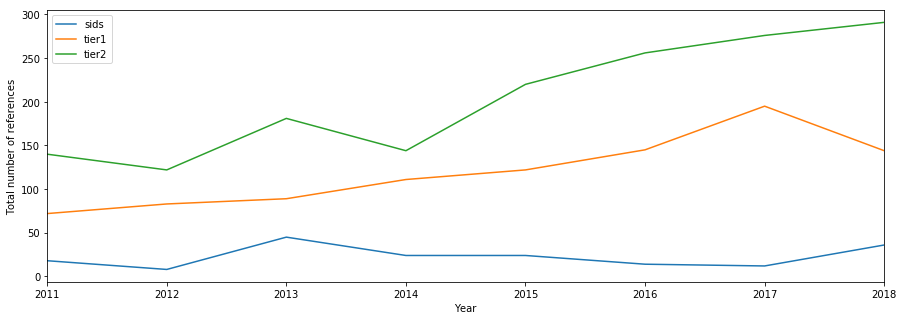

In [76]:
df_per_region_year_intersection = pd.DataFrame(data=per_region_year_intersection)
ax = df_per_region_year_intersection[['sids','tier1','tier2']].filter(items=['2011','2012','2013','2014','2015','2016','2017','2018'],axis=0).plot.line(figsize=(15,5))
ax.set_xticklabels(['2011','2012','2013','2014','2015','2016','2017','2018'])
ax.set_xlabel("Year")
ax.set_ylabel("Total number of references")
ax

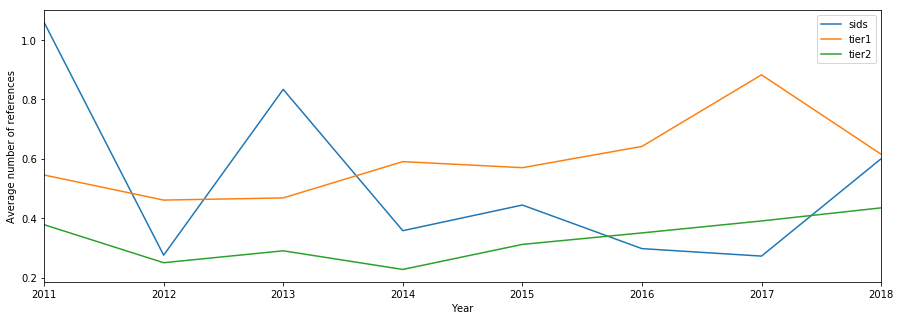

In [75]:
df_average_per_region_year_intersection = pd.DataFrame(data=average_per_region_year_intersection)
ax = df_average_per_region_year_intersection[['sids','tier1','tier2']].filter(items=['2011','2012','2013','2014','2015','2016','2017','2018'],axis=0).plot.line(figsize=(15,5))
ax.set_xticklabels(['2011','2012','2013','2014','2015','2016','2017','2018'])
ax.set_xlabel("Year")
ax.set_ylabel("Average number of references")
ax

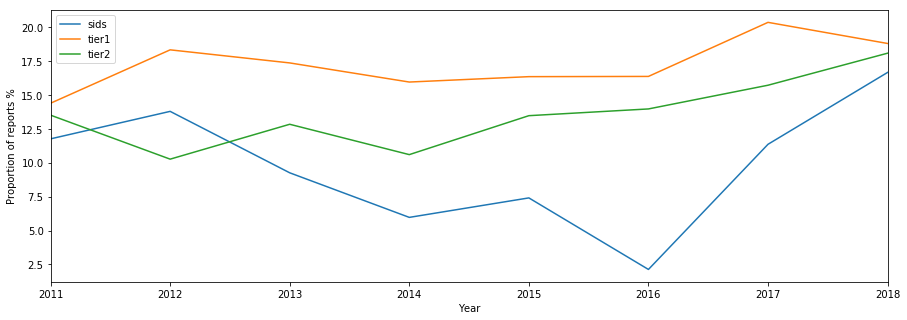

In [77]:
df_proportion_per_region_year_intersection = pd.DataFrame(proportion_per_region_year_intersection)
ax = df_proportion_per_region_year_intersection[['sids','tier1','tier2']].filter(items=['2011','2012','2013','2014','2015','2016','2017','2018'],axis=0).plot.line(figsize=(15,5))
ax.set_xticklabels(['2011','2012','2013','2014','2015','2016','2017','2018'])
ax.set_xlabel("Year")
ax.set_ylabel("Proportion of reports %")
ax

### References per sector: total, average, proportion

For one specific sector “Health Care Equipment and Services” produce graphs of trend lines for health, climate change, and intersection over the complete time period:

- 2.1 Total count of mentions
- 2.2 Proportion of all reports for this sector that mention at least once
- 2.3 Proportion per country group (sids,  tier1,  tier 2)
- 2.4 Proportion per WHO region

#### 2.1 Total Count of Mentions

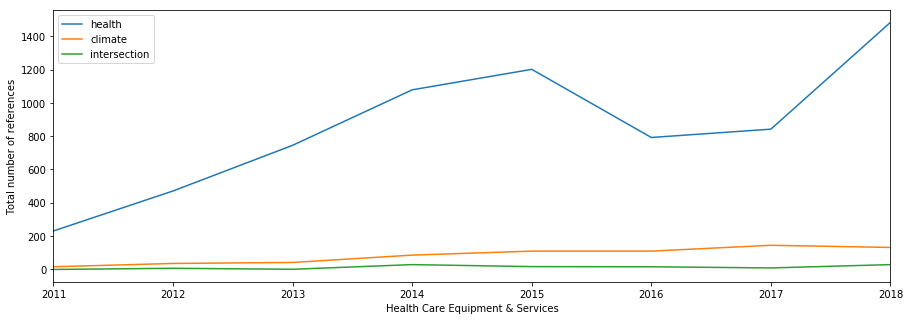

In [37]:
df_per_sector_year_climate = pd.DataFrame(per_sector_year_climate)
df_per_sector_year_health = pd.DataFrame(per_sector_year_health)
df_per_sector_year_intersection = pd.DataFrame(per_sector_year_intersection)
df_hces_per_year = pd.concat([df_per_sector_year_health['Health Care Equipment & Ser...'], df_per_sector_year_climate['Health Care Equipment & Ser...'], df_per_sector_year_intersection['Health Care Equipment & Ser...']], axis=1, keys=['health', 'climate', 'intersection'])

ax = df_hces_per_year.filter(items=['2011','2012','2013','2014','2015','2016','2017','2018'],axis=0).plot.line(figsize=(15,5))
ax.set_xticklabels(['2011','2012','2013','2014','2015','2016','2017','2018'])
ax.set_xlabel("Health Care Equipment & Services")
ax.set_ylabel("Total number of references")
ax

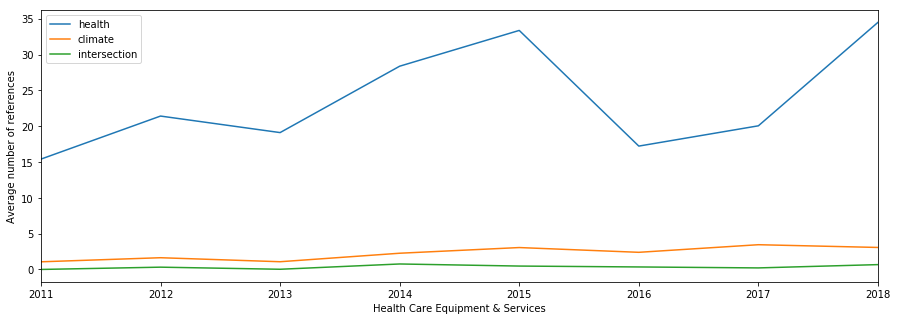

In [40]:
df_average_per_sector_year_health = pd.DataFrame(average_per_sector_year_health)
df_average_per_sector_year_climate = pd.DataFrame(average_per_sector_year_climate)
df_average_per_sector_year_intersection = pd.DataFrame(average_per_sector_year_intersection)
df_hces_average_per_year = pd.concat([df_average_per_sector_year_health['Health Care Equipment & Ser...'], df_average_per_sector_year_climate['Health Care Equipment & Ser...'], df_average_per_sector_year_intersection['Health Care Equipment & Ser...']], axis=1, keys=['health', 'climate', 'intersection'])

ax = df_hces_average_per_year.filter(items=['2011','2012','2013','2014','2015','2016','2017','2018'],axis=0).plot.line(figsize=(15,5))
ax.set_xticklabels(['2011','2012','2013','2014','2015','2016','2017','2018'])
ax.set_xlabel("Health Care Equipment & Services")
ax.set_ylabel("Average number of references")
ax

#### 2.2 Proportion of all reports for this sector that mention at least once

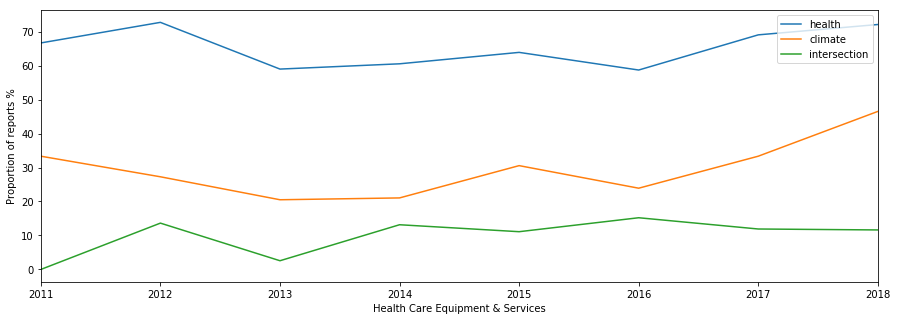

In [42]:
df_proportion_per_sector_year_health = pd.DataFrame(proportion_per_sector_year_health)
df_proportion_per_sector_year_climate = pd.DataFrame(proportion_per_sector_year_climate)
df_proportion_per_sector_year_intersection = pd.DataFrame(proportion_per_sector_year_intersection)
df_hces_proportion_per_year = pd.concat([df_proportion_per_sector_year_health['Health Care Equipment & Ser...'], df_proportion_per_sector_year_climate['Health Care Equipment & Ser...'], df_proportion_per_sector_year_intersection['Health Care Equipment & Ser...']], axis=1, keys=['health', 'climate', 'intersection'])

ax = df_hces_proportion_per_year.filter(items=['2011','2012','2013','2014','2015','2016','2017','2018'],axis=0).plot.line(figsize=(15,5))
ax.set_xticklabels(['2011','2012','2013','2014','2015','2016','2017','2018'])
ax.set_xlabel("Health Care Equipment & Services")
ax.set_ylabel("Proportion of reports %")
ax

#### 2.3 Proportion per country group (sids,  tier1,  tier 2)

In [72]:
df_selected_pdfs = pd.DataFrame(selected_pdfs).transpose().filter(items=['country', 'sector', 'year'])

In [85]:
sps_regions = []
for i in selected_pdfs_sector['country']:
    sps_region = get_new_region(i)
    sps_regions.append(sps_region)

In [103]:
selected_pdfs_sector = df_selected_pdfs[df_selected_pdfs.sector == "Health Care Equipment & Ser..."]
selected_pdfs_sector['region'] = pd.DataFrame(sps_regions).values

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [136]:
selected_pdfs_sector_region_year = selected_pdfs_sector[['year', 'region']]

0.6666666666666666

In [180]:
other_year_sum = []
for year in selected_sectors_years['Health Care Equipment & Ser...'].keys():
    year_sum=(sum(selected_pdfs_sector_region_year[selected_pdfs_sector_region_year.region=="other"].year==year)/sum(selected_pdfs_sector_region_year.year==year))*100
    other_year_sum.append(year_sum)
tier1_year_sum = []
for year in selected_sectors_years['Health Care Equipment & Ser...'].keys():
    year_sum=(sum(selected_pdfs_sector_region_year[selected_pdfs_sector_region_year.region=="tier1"].year==year)/sum(selected_pdfs_sector_region_year.year==year))*100
    tier1_year_sum.append(year_sum)
tier2_year_sum = []
for year in selected_sectors_years['Health Care Equipment & Ser...'].keys():
    year_sum=(sum(selected_pdfs_sector_region_year[selected_pdfs_sector_region_year.region=="tier2"].year==year)/sum(selected_pdfs_sector_region_year.year==year))*100
    tier2_year_sum.append(year_sum)
sids_year_sum = []
for year in selected_sectors_years['Health Care Equipment & Ser...'].keys():
    year_sum=(sum(selected_pdfs_sector_region_year[selected_pdfs_sector_region_year.region=="sids"].year==year)/sum(selected_pdfs_sector_region_year.year==year))*100
    sids_year_sum.append(year_sum)

In [181]:
df_selected_pdfs_sector_region_year = pd.DataFrame([other_year_sum, tier1_year_sum, tier2_year_sum, sids_year_sum], columns=['2011','2012','2013','2014','2015','2016','2017','2018'])

df_selected_pdfs_sector_region_year = df_selected_pdfs_sector_region_year.rename(index = {0: "other", 
                                                    1: "tier1", 
                                                    2: "tier2",
                                                    3: "sids"}).transpose() 

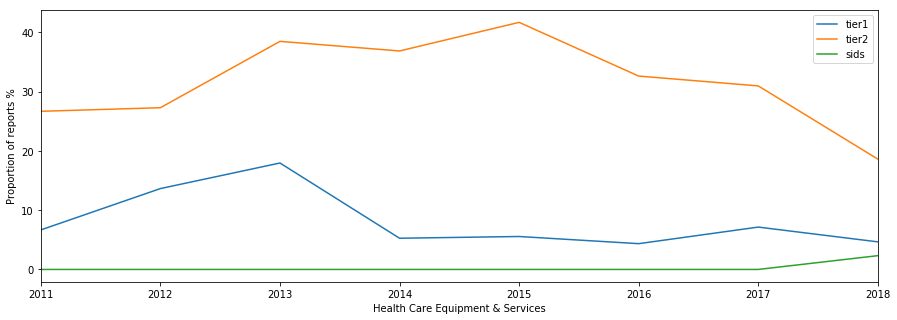

In [182]:
ax = df_selected_pdfs_sector_region_year[['tier1', 'tier2', 'sids']].plot.line(figsize=(15,5))
ax.set_xlabel("Health Care Equipment & Services")
ax.set_ylabel("Proportion of reports %")
ax

#### 2.4 Proportion per WHO region

For one specific sector “Health Care Equipment and Services” produce a **trend line of proportion of reports per country** that mention at least once climate change, health, and intersection references over the whole time period. For the following countries (English speaking):
- 3.1 USA
- 3.2 UK
- 3.3 Australia
- 3.4 Canada
- 3.5 New Zealand
- 3.6 South Africa

### Keywords

Produce the tables of frequency of keywords (health and climate) for the “Health Care Equipment and Services” sector.

In [193]:
dict_selected_pdfs_sector = selected_pdfs_sector.transpose().to_dict()

In [194]:
hces_count_health_keywords = {}
hces_health_contexts = []
hces_count_climate_keywords = {}
hces_climate_contexts = []

for pdf in dict_selected_pdfs_sector.keys():
    filenametxt = txts_folder + filenameregex.search(pdf)[0] + ".txt"
    print("Loading %s" % (filenametxt))

    try:
        txtFileObj = open(filenametxt, 'r')
    except:
        print("Could not open {}".format(filenametxt))
        continue

    wordlist = re.split(r'[\W0-9]+', txtFileObj.read().lower())
    tokens_count += len(wordlist)
    histogram_tokens_count.append(len(wordlist))
    
    for word in wordlist:
        types_count[word] = types_count.get(word, 0) + 1
    
    compounds_wordlist = tokenizer.tokenize(wordlist)
    filtered_compounds_wordlist = [w for w in compounds_wordlist if (len(w) > 3)]

    health_contexts = []
    climate_contexts = []
    health_words = []
    
    for i in range(0,len(filtered_compounds_wordlist)):
        word = filtered_compounds_wordlist[i]
        if word in health_dict:
            context = get_context(i, filtered_compounds_wordlist)
            health_contexts.append(context)
            health_words.append(word)            
            hces_count_health_keywords[word] = hces_count_health_keywords.get(word, 0) + 1
            hces_health_contexts.extend(context)
            
        if word in climate_dict:
            context = get_context(i, filtered_compounds_wordlist)
            climate_contexts.append(context)
            hces_count_climate_keywords[word] = hces_count_climate_keywords.get(word, 0) + 1
            hces_climate_contexts.extend(context)

Loading ../data/cops/txts/Tana_Netting_CSR_Report_2010.pdf?1303879734.txt
Loading ../data/cops/txts/WDH_UNGC_COP_2011.pdf?1305122127.txt
Loading ../data/cops/txts/COP_CDI_Dental_-_2011-05-15..pdf?1306151456.txt
Loading ../data/cops/txts/Radiometer_Medical_-_CSR_Status_GC_2010.pdf?1306482668.txt
Loading ../data/cops/txts/ESSILOR_RegistrationDocument_2010.pdf?1307612983.txt
Loading ../data/cops/txts/COP_2011_Renewed_Committment_of_the_Chairman_of_the_Board_of_Directors.pdf?1307612983.txt
Loading ../data/cops/txts/ELARD_COP-10_principles_June_2011.pdf?1308225730.txt
Loading ../data/cops/txts/Sawaf_20Medical_20Institute_20for_20Imaging_20COP_20FINAL._1_.pdf?1310025099.txt
Loading ../data/cops/txts/Communication_on_Progress_-_WaterHealth_India_-_2011_Version_2_.pdf?1312956935.txt
Loading ../data/cops/txts/Merkez_la_COP.pdf?1319629628.txt
Loading ../data/cops/txts/UN_Global_Report_2011_Final.pdf?1321298747.txt
Loading ../data/cops/txts/sysmex_sustainability_report_2011.pdf?1324270204.txt
Loa

Loading ../data/cops/txts/carta.pdf?1427914236.txt
Loading ../data/cops/txts/COP_CDI_Dental_-_2015-04-15.pdf?1429371989.txt
Loading ../data/cops/txts/2014_Registration_Document_Essilor.pdf?1432026288.txt
Loading ../data/cops/txts/See_Change_Report.pdf?1432026288.txt
Loading ../data/cops/txts/CSR_report_EN_2014.pdf?1432583068.txt
Loading ../data/cops/txts/CSR_report_2014.pdf?1432814805.txt
Loading ../data/cops/txts/COP_2014.pdf?1433491279.txt
Loading ../data/cops/txts/cop.pdf?1433536879.txt
Loading ../data/cops/txts/Aleris_Corporate_social_responsibility_in_healthcare___care_services_2015.pdf?1435148447.txt
Loading ../data/cops/txts/Ceylon_Hospital_PLC_-_Annual_Report_1415.pdf?1438410593.txt
Loading ../data/cops/txts/2014_Sustainability_Report.pdf?1438952107.txt
Loading ../data/cops/txts/COP_REPORT-DEBRA_LIMITED_2.pdf?1441198571.txt
Loading ../data/cops/txts/UNGC_Communication_on_Progress_2015.pdf?1441639507.txt
Loading ../data/cops/txts/International_SOS_UNGC_submission_2015.pdf?144298

Loading ../data/cops/txts/Netcare_Advanced_COP.pdf?1519737681.txt
Loading ../data/cops/txts/Ossur_2017_CSR_Report_Final.pdf?1519848778.txt
Loading ../data/cops/txts/Ascom_Annual_Report_2017.pdf?1520247214.txt
Loading ../data/cops/txts/WOM_Sustainability_Report_2017_CoP.pdf?1521565301.txt
Loading ../data/cops/txts/ESSILOR_Sustainability_Report_2017.pdf?1523627184.txt
Loading ../data/cops/txts/CSR_report_2017_Final_approved.pdf?1525710293.txt
Loading ../data/cops/txts/FN_GC_2018.pdf?1526296877.txt
Loading ../data/cops/txts/Sivantos_COP_2018_05_23.pdf?1527075990.txt
Loading ../data/cops/txts/Sonova_AR17_CSR_Report_en.pdf?1527143839.txt
Loading ../data/cops/txts/Report_Interlux_2017.pdf?1527257263.txt
Loading ../data/cops/txts/AAR_Health_Care_Holdings_Ltd__Communication_of_Progress_2017.pdf?1527744759.txt
Loading ../data/cops/txts/2018_Communication_on_Progress%28UNIVERA%29_update.pdf?1528230984.txt
Loading ../data/cops/txts/2018_Sustainability_Report_Europe.pdf?1530020182.txt
Loading ../d

In [196]:
df_hces_health_keywords = pd.DataFrame(sorted(hces_count_health_keywords.items(), key=lambda k: k[1], reverse=True), columns=["Keyword", "Number of mentions"])
df_hces_health_keywords

,Keyword,Number of mentions
0,health,3407
1,healthcare,1991
2,health_care,440
3,disease,280
4,infection,133
5,malaria,117
6,infectious,104
7,public_health,90
8,illness,83
9,nutrition,72


In [197]:
df_hces_climate_keywords = pd.DataFrame(sorted(hces_count_climate_keywords.items(), key=lambda k: k[1], reverse=True), columns=["Keyword", "Number of mentions"])
df_hces_climate_keywords

,Keyword,Number of mentions
0,greenhouse,303
1,climate_change,191
2,renewable_energy,63
3,temperature,50
4,low_carbon,39
5,global_warming,14
6,carbon_emission,8
7,extreme_weather,5
8,green_house,4


### Network graphs

Network graph of co-occurrence for the Health sector.